# Lab Test Harmonization

*by Holly Cui*

#### Given two lab test names, can we deduplicate to see whether they are of the same type?


What is **Harmonization**?

Essentially a process of deduplication. In this project, we attempt to: 
- match messy lab test data of poor quality 
- identify same test type based on texts provided by the structured dataset
- validate the process of cross-connection between different datasets or test representations


More on BERT: https://docs.google.com/presentation/d/1tCqjBRsl3fW9TjSYCGKtXaSswkXwlyfSaqDJqcTCKN4/edit#slide=id.g13a6eedfe78_0_105

#### Path
/Users/hollycui/Desktop/HDS/lab_test_harmonization_REDO.ipynb

### Import library

In [2]:
import os
import boto3
import json
import numpy as np
import pandas as pd
import spacy
import torch
import csv
import tqdm

import transformers
from transformers import AutoTokenizer, AutoModel

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns

### Import model
Different versions: 
- BioBERT v1.0 (+PubMed +PMC)
- BioBERT v1.0 (+PubMed)
- BioBERT v1.0 (+PMC)
- BioBERT v1.1 (+PubMed): 1M steps

For our purpose, we choose v1.1 as embedding model. 

From hugging face: https://huggingface.co/dmis-lab/biobert-v1.1

In [5]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Import data

In [6]:
grouper_df = pd.read_csv("/Users/hollycui/Desktop/HDS/analyte_grouper.csv")

In [7]:
grouper_df

component_id                                      raw_name grouper_name
0        12300243                             ALBUMIN     (BKR)      albumin
1        12311700                           ALBUMIN     (BKRAF)      albumin
2      3043005213                             ALBUMIN - LABCORP      albumin
3         1534247             ALBUMIN ELECTROPHORESIS - LABCORP      albumin
4      3043002268                             ALBUMIN - LABCORP      albumin
..            ...                                           ...          ...
368    3043000383                                 WBC - LABCORP          wbc
369    3043002310                                 WBC - LABCORP          wbc
370      12311935  WBC (WHITE BLOOD CELL COUNT) EXTERNAL (ARMC)          wbc
371    2100000020                   DUAP WHITE BLOOD CELL COUNT          wbc
372    3041000001         WBC (WHITE BLOOD CELL COUNT EXTERNAL)          wbc

[373 rows x 3 columns]

### Conduct embeddings

#### Test on single text string

In [7]:
raw = "ALBUMIN (BKR)"
raw_token = tokenizer.encode(raw, add_special_tokens=True)
raw_embedding = torch.tensor([raw_token])

raw = "POTASSIUM"
raw_token = tokenizer.encode(raw, add_special_tokens=True)
raw_embedding = torch.tensor([raw_token])

In [8]:
raw_embedding

tensor([[ 101, 1312, 1394,  113,  171, 1377, 1197,  114,  102]])

In [9]:
grouper = "albumin"
grouper_token = tokenizer.encode(grouper, add_special_tokens=True)
grouper_embedding = torch.tensor([grouper_token])

grouper = "potassium"
grouper_token = tokenizer.encode(grouper, add_special_tokens=True)
grouper_embedding = torch.tensor([grouper_token])

In [10]:
grouper_embedding

tensor([[ 101, 1312, 1394,  102]])

Under BERT model structure, the model( ) function has two output: 
- **sequence output / last_hidden_state** (normally of shape [batch_size, max_sequence_length, 768]): last layer of Bert.
- **pooler output** (normally of shape [batch_size, 768]): the output of an additional “pooler” layer who takes sequence_output[:, 0](first token, i.e. CLS token) followed by dense layer and Tanh activation. 

Both serve the same purpose and have the same column dimension. Here, we use the last_hidden_states as our embedding function. 

In [11]:
model(raw_embedding)[0] # last_hidden_state
model(raw_embedding)[1] # pooler_output

tensor([[-9.7067e-02, -2.3798e-02,  8.4039e-01, -9.9999e-01,  9.9999e-01,
          7.4557e-02, -3.1813e-02,  6.6505e-01,  6.9335e-02,  2.5105e-02,
          5.8916e-01,  9.9940e-01, -7.8167e-01, -6.6476e-01,  1.0469e-01,
         -4.3121e-02,  9.9999e-01, -1.6521e-02, -9.6836e-01, -1.1930e-01,
          9.2670e-02, -8.6782e-01,  1.9091e-02,  9.9952e-01,  1.2100e-01,
          2.5436e-02,  9.9902e-01,  9.7068e-01,  1.0609e-02, -8.8107e-04,
          2.8022e-02, -9.9999e-01,  9.9872e-01, -9.9948e-01,  8.7926e-02,
         -1.9623e-01,  1.3434e-01,  4.0282e-03,  7.9464e-01, -9.9978e-01,
         -1.8316e-03, -8.9381e-01,  1.0553e-01,  3.8892e-02,  9.9968e-01,
          2.2281e-02,  6.2762e-02,  6.4272e-02, -9.7309e-02, -6.5007e-01,
          2.7952e-02,  7.1778e-01, -3.7283e-01,  9.7300e-01,  9.9551e-01,
         -1.4731e-02,  9.9999e-01, -1.3028e-02,  3.8048e-01, -5.0777e-02,
          9.9998e-01, -1.1986e-02, -5.4806e-02, -1.4503e-01, -3.4280e-03,
          5.3034e-02, -9.7330e-01,  5.

In [12]:
model(raw_embedding)[0].shape

torch.Size([1, 9, 768])

In [13]:
with torch.no_grad():
    last_hidden_states_raw = model(raw_embedding)[0]
    last_hidden_states_grouper = model(grouper_embedding)[0]

# There are nine layers of output --> take mean value to get the actual embeddings
last_hidden_states_raw_ = last_hidden_states_raw.mean(1)
last_hidden_states_grouper_ = last_hidden_states_grouper.mean(1)

In [14]:
last_hidden_states_raw_

tensor([[ 2.0664e-01, -3.5016e-01, -1.5213e-02,  7.4697e-02, -2.3472e-01,
         -1.7307e-01,  5.3204e-02,  6.7581e-02,  4.7030e-02, -5.0737e-02,
         -1.7947e-01,  1.1390e-01, -4.3294e-01,  1.6195e-01, -4.8571e-01,
          2.0829e-01,  1.0580e-01, -5.6087e-02,  3.9062e-02,  4.6992e-02,
         -1.1718e-02, -2.6541e-01, -6.9473e-03,  2.6371e-01,  2.5130e-01,
         -2.1457e-02,  3.5225e-01,  2.6503e-01, -1.2128e-01,  3.1129e-01,
         -2.0436e-01,  1.7562e-01,  8.8023e-02, -8.8994e-02, -6.7442e-02,
          1.4191e-01, -1.2234e-01,  2.5567e-01,  1.0888e-01,  2.3045e-01,
          2.3278e-01,  3.6455e-02,  1.3753e-01,  3.7782e-03, -2.9278e-01,
         -3.3498e-01,  1.2258e-02,  2.3580e-01, -4.4647e-02,  2.3444e-01,
         -7.5126e-02,  5.3117e-02, -1.4388e-01, -6.9261e-02,  3.0128e-01,
         -1.9318e-01, -1.8176e-01,  1.6641e-02, -1.0237e-01,  5.1786e-01,
          1.5718e-01,  4.8879e-02,  3.4548e-02, -1.8415e-01, -2.5268e-01,
         -5.4494e-02, -1.0779e-01,  1.

In [15]:
last_hidden_states_grouper_.size()

torch.Size([1, 768])

### Calculate cosine similarity

- ***sklearn*** is for pairwise cosine similairty comparison.
- ***scipy*** is only for 1D array comparison.

#### Test on single text string

In [18]:
raw_final = last_hidden_states_raw_[0].detach().numpy()
grouper_final = last_hidden_states_grouper_[0].detach().numpy()

In [19]:
similarity = 1 - cosine(raw_final, grouper_final)
similarity

0.8638389110565186

### Apply on dataframe

#### Format dataframe

In [10]:
raw_embeddings = []
grouper_embeddings = []
similarity = []

for i in tqdm.tqdm(range(grouper_df.shape[0])):
    
    # retrieve names in each row
    raw_name = grouper_df['raw_name'][i]
    grouper_name = grouper_df['grouper_name'][i]
    
    # create embeddings
    ## raw_name: 
    raw_token = tokenizer.encode(raw_name, add_special_tokens=True)
    raw_embedding = torch.tensor([raw_token])
    with torch.no_grad():
        last_hidden_states_raw = model(raw_embedding)[0]
    last_hidden_states_raw_ = last_hidden_states_raw.mean(1)
    raw_final = last_hidden_states_raw_[0].detach().numpy()
    
    ## grouper_name:
    grouper_token = tokenizer.encode(grouper_name, add_special_tokens=True)
    grouper_embedding = torch.tensor([grouper_token])
    with torch.no_grad():
        last_hidden_states_grouper = model(grouper_embedding)[0]
    last_hidden_states_grouper_ = last_hidden_states_grouper.mean(1)
    grouper_final = last_hidden_states_grouper_[0].detach().numpy()
    
    # calculate similarity
    row_similarity = 1 - cosine(raw_final, grouper_final)
    
    # add all useful info to new lists for new columns creation
    raw_embeddings.append(raw_final)
    grouper_embeddings.append(grouper_final)
    similarity.append(row_similarity)

100%|██████████| 373/373 [00:50<00:00,  7.45it/s]


In [11]:
grouper_df['raw_embeddings'] = raw_embeddings
grouper_df['grouper_embeddings'] = grouper_embeddings
grouper_df['similarity'] = similarity

In [12]:
grouper_df

component_id                                      raw_name grouper_name  \
0        12300243                             ALBUMIN     (BKR)      albumin   
1        12311700                           ALBUMIN     (BKRAF)      albumin   
2      3043005213                             ALBUMIN - LABCORP      albumin   
3         1534247             ALBUMIN ELECTROPHORESIS - LABCORP      albumin   
4      3043002268                             ALBUMIN - LABCORP      albumin   
..            ...                                           ...          ...   
368    3043000383                                 WBC - LABCORP          wbc   
369    3043002310                                 WBC - LABCORP          wbc   
370      12311935  WBC (WHITE BLOOD CELL COUNT) EXTERNAL (ARMC)          wbc   
371    2100000020                   DUAP WHITE BLOOD CELL COUNT          wbc   
372    3041000001         WBC (WHITE BLOOD CELL COUNT EXTERNAL)          wbc   

                                        raw_embeddings  \
0    [0.20664178, -0.3501551, -0.015212804, 0.07469...   
1    [-0.008407947, -0.33557537, 0.039858513, 0.127...   
2    [0.22360916, -0.191205, -0.06626989, -0.083718...   
3    [0.12664483, -0.06891488, -0.0037260514, -0.16...   
4    [0.22360916, -0.191205, -0.06626989, -0.083718...   
..                                                 ...   
368  [0.43384254, -0.268469, 0.07817535, -0.1895038...   
369  [0.43384254, -0.268469, 0.07817535, -0.1895038...   
370  [-0.15846933, -0.12877153, -0.0916198, -0.0012...   
371  [-0.25241944, -0.14406157, 0.13864484, 0.12266...   
372  [-0.28665784, -0.21344791, 0.005305566, 0.0555...   

                                    grouper_embeddings  similarity  
0    [0.08558647, -0.07638013, -0.037009418, -0.133...    0.863839  
1    [0.08558647, -0.07638013, -0.037009418, -0.133...    0.875775  
2    [0.08558647, -0.07638013, -0.037009418, -0.133...    0.837030  
3    [0.08558647, -0.07638013, -0.037009418, -0.133...    0.777643  
4    [0.08558647, -0.07638013, -0.037009418, -0.133...    0.837030  
..                                                 ...         ...  
368  [0.30396086, -0.28398386, -0.049159437, -0.097...    0.871596  
369  [0.30396086, -0.28398386, -0.049159437, -0.097...    0.871596  
370  [0.30396086, -0.28398386, -0.049159437, -0.097...    0.832027  
371  [0.30396086, -0.28398386, -0.049159437, -0.097...    0.794682  
372  [0.30396086, -0.28398386, -0.049159437, -0.097...    0.841097  

[373 rows x 6 columns]

In [74]:
#os.makedirs('/Users/hollycui/Desktop/HDS/data', exist_ok=True)
#grouper_df.to_csv('/Users/hollycui/Desktop/HDS/data/grouper_df.csv')

In [13]:
grouper_df[grouper_df['grouper_name'] == "potassium"].sort_values(by='similarity', ascending = False)

component_id                                   raw_name grouper_name  \
310       1534081                                  POTASSIUM    potassium   
317    2100006306                                  POTASSIUM    potassium   
311       1554105                            POTASSIUM BLOOD    potassium   
316    2100003685                           I STAT POTASSIUM    potassium   
320      12311917                  POTASSIUM EXTERNAL (ARMC)    potassium   
312       1554316                     POTASSIUM BLOOD VENOUS    potassium   
315    2100000625                     POTASSIUM. WHOLE BLOOD    potassium   
302      12311689                      POTASSIUM     (BKRAF)    potassium   
313    2100000620                          POTASSIUM, VENOUS    potassium   
301      12303597                        POTASSIUM     (BKR)    potassium   
321    3041000019                    K+ (POTASSIUM EXTERNAL)    potassium   
314    2100000624                        POTASSIUM, ARTERIAL    potassium   
309    3043002273                        POTASSIUM - LABCORP    potassium   
318    3043000120                        POTASSIUM - LABCORP    potassium   
319    3043002273                        POTASSIUM - LABCORP    potassium   
307      12303607           POTASSIUM. WHOLE BLOOD     (BKR)    potassium   
306      12302358             POC I STAT POTASSIUM     (BKR)    potassium   
304      12303606                POTASSIUM, VENOUS     (BKR)    potassium   
303      12303600              POTASSIUM, ARTERIAL     (BKR)    potassium   
305      12307275          POC POTASSIUM, ARTERIAL     (BKR)    potassium   
308      12307320  POC BLOOD GAS POTASSIUM, VENOUS     (BKR)    potassium   

                                        raw_embeddings  \
310  [-0.031462703, -0.25102335, 0.08120355, -0.187...   
317  [-0.031462703, -0.25102335, 0.08120355, -0.187...   
311  [-0.097371355, -0.13642979, 0.010173388, 0.041...   
316  [0.13620156, 0.04381487, -0.028019905, -0.1451...   
320  [-0.062960275, 0.008616268, 0.15842453, -0.212...   
312  [-0.19329868, -0.006261083, 0.050228495, -0.16...   
315  [-0.07200631, -0.13092697, 0.41087827, -0.3407...   
302  [-0.08716015, -0.28447443, 0.2279944, -0.00545...   
313  [-0.102952726, 0.17717205, 0.07185292, 0.00878...   
301  [0.3051651, -0.14543216, 0.2552228, 0.02875541...   
321  [0.08140141, 0.053490095, 0.12128816, -0.17847...   
314  [-0.13722809, 0.007833083, 0.07301312, 0.17452...   
309  [0.18746424, -0.20123227, 0.15860608, -0.00482...   
318  [0.18746424, -0.20123227, 0.15860608, -0.00482...   
319  [0.18746424, -0.20123227, 0.15860608, -0.00482...   
307  [0.14131966, -0.38109055, 0.2449945, 0.0029937...   
306  [0.18304504, -0.12628537, 0.21507008, -0.07376...   
304  [0.14251657, -0.055827543, 0.11492226, -0.0671...   
303  [0.04954957, -0.22757053, 0.16378492, 0.135242...   
305  [0.017963905, -0.21450666, 0.1206616, 0.149719...   
308  [0.038313285, -0.10959749, -0.004150816, -0.11...   

                                    grouper_embeddings  similarity  
310  [-0.031462703, -0.25102335, 0.08120355, -0.187...    1.000000  
317  [-0.031462703, -0.25102335, 0.08120355, -0.187...    1.000000  
311  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.940143  
316  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.824723  
320  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.801328  
312  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.801262  
315  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.796799  
302  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.794041  
313  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.793799  
301  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.790045  
321  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.777369  
314  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.773453  
309  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.761276  
318  [-0.031462703, -0.25102335, 0.08120355, -0.187...    0.761276 

### Cross comparison between all raw and all groupers

#### Get unique raw and grouper names w/ embeddings

In [14]:
# df containing only unqiue raw names
raw_df = grouper_df.filter(['raw_name', 'raw_embeddings', 'grouper_name'], axis=1)
unique_raws = raw_df.groupby('raw_name', as_index=False).first()

In [15]:
unique_raws # 324 unique raw names

raw_name  \
0              ACT PARTIAL THROMBOPLASTIN TIME   
1    ACT PARTIAL THROMBOPLASTIN TIME     (BKR)   
2                     ALANINE AMINOTRANSFERASE   
3           ALANINE AMINOTRANSFERASE     (BKR)   
4           ALANINE AMINOTRANSFERASE - LABCORP   
..                                         ...   
319                              WBC - LABCORP   
320                     WHITE BLOOD CELL COUNT   
321           WHITE BLOOD CELL COUNT - LABCORP   
322           WHITE BLOOD CELL COUNT     (BKR)   
323         WHITE BLOOD CELL COUNT     (BKRAF)   

                                        raw_embeddings grouper_name  
0    [-0.043434776, 0.14844556, 0.387562, 0.2261370...         aptt  
1    [0.006014225, -0.071402945, 0.1353107, 0.14703...         aptt  
2    [-0.29025212, -0.023859639, -0.24285176, 0.269...          alt  
3    [0.051441953, -0.11221792, -0.19198377, 0.2875...          alt  
4    [-0.010348107, -0.1366414, -0.22694756, 0.1375...          alt  
..                                                 ...          ...  
319  [0.43384254, -0.268469, 0.07817535, -0.1895038...          wbc  
320  [-0.38417935, -0.11811775, 0.10874232, 0.06481...          wbc  
321  [-0.05833601, -0.21440165, 0.114036605, -0.085...          wbc  
322  [-0.16550025, -0.40610754, 0.10297487, -0.0011...          wbc  
323  [-0.31062075, -0.38943914, 0.069153674, -0.056...          wbc  

[324 rows x 3 columns]

In [16]:
# df containing only unqiue grouper names
group_df = grouper_df.filter(['grouper_name', 'grouper_embeddings'], axis=1)
unique_groups = group_df.groupby('grouper_name', as_index=False).first()

In [17]:
unique_groups # 36 unique groupers

grouper_name                                 grouper_embeddings
0                   ESR  [0.29189637, -0.23742639, -0.043175455, -0.252...
1               albumin  [0.08558647, -0.07638013, -0.037009418, -0.133...
2                   alt  [0.25289917, -0.23679826, -0.15975142, -0.0516...
3               ammonia  [-0.09556136, -0.051205263, -0.23730528, -0.27...
4                  aptt  [0.25414523, -0.14685968, -0.24449036, 0.09410...
5                   ast  [0.047332563, -0.15196654, -0.106446065, -0.27...
6              bandemia  [0.12614255, -0.16819745, -0.13873099, 0.04170...
7       bicarb_arterial  [0.16082264, -0.23231581, -0.09725845, -0.1322...
8         bicarb_venous  [0.15299852, -0.1379596, -0.049962737, -0.2716...
9             bilirubin  [0.22253877, -0.18823092, -0.38237095, -0.4486...
10        blood_culture  [0.21799107, 0.1724962, -0.2885532, -0.2368791...
11                  bun  [0.11418143, -0.20854041, -0.21565351, -0.1035...
12                 ckmb  [0.4530353, -0.2501374, -0.18317306, -0.036244...
13         co2_arterial  [0.3078967, -0.01613462, -0.14595833, -0.02111...
14           co2_venous  [0.30690655, 0.12501113, -0.13183399, -0.15615...
15           creatinine  [-0.15739588, -0.10941378, -0.12982352, -0.143...
16               ddimer  [0.25713816, -0.22373176, -0.17759661, -0.1549...
17           fibrinogen  [0.22476663, 0.07966434, 0.09630739, 0.0063262...
18              glucose  [-0.089972615, -0.19694275, -0.10902107, -0.09...
19           hematocrit  [-0.48798397, 0.0008097738, 0.10189275, -0.122...
20            influenza  [0.24760243, -0.10928263, -0.18876526, -0.1582...
21                  inr  [0.17117813, -0.26785767, 0.09433715, -0.20816...
22      ionized calcium  [-0.06563672, 0.04152087, 0.11051383, -0.22278...
23              lactate  [-0.16952984, -0.023161221, -0.16579512, -0.31...
24                  ldh  [0.25777736, -0.26665664, -0.42358506, -0.2451...
25            magnesium  [-0.011376977, -0.16976504, 0.1623523, -0.0285...
26        pco2_arterial  [0.39695066, 0.039283916, -0.11920294, -0.0511...
27          pco2_venous  [0.3407097, 0.16888362, -0.13748196, -0.203135...
28          ph_arterial  [0.12989378, -0.11178509, -0.07304925, -0.1606...
29            ph_venous  [0.11598652, -0.033015985, -0.01523384, -0.282...
30             platelet  [0.2619082, -0.115343764, -0.019982684, 0.1630...
31         po2_arterial  [0.11003137, -0.060645215, 0.06521182, -0.2013...
32            potassium  [-0.031462703, -0.25102335, 0.08120355, -0.187...
33  random_urine_sodium  [0.11026122, 0.15564026, -0.057538185, -0.1949...
34               sodium  [0.12637287, -0.20021187, -0.063151196, -0.219...
35                  wbc  [0.30396086, -0.28398386, -0.049159437, -0.097...

#### Create cross comparison similarity df

In [18]:
# Cross comparison
raw_names = []
paired_groupers = []
true_groupers = []
similarity = []

for i in tqdm.tqdm(range(unique_raws.shape[0])):
    raw_em = unique_raws['raw_embeddings'][i]
    raw = unique_raws['raw_name'][i]
    true_grouper = unique_raws['grouper_name'][i]
    
    for j in range(unique_groups.shape[0]):
        group_em = unique_groups['grouper_embeddings'][j]
        grouper = unique_groups['grouper_name'][j]
        sim = 1-cosine(raw_em, group_em)
        
        similarity.append(sim)
        raw_names.append(raw)
        paired_groupers.append(grouper)
        true_groupers.append(true_grouper)

100%|██████████| 324/324 [00:00<00:00, 585.04it/s]


In [19]:
cross_comp = pd.DataFrame()
cross_comp['raw'] = raw_names
cross_comp['paired_grouper'] = paired_groupers
cross_comp['true_grouper'] = true_groupers
cross_comp['similarity'] = similarity

In [20]:
cross_comp.shape   # 11664 = 324 * 36

(11664, 4)

In [162]:
cross_comp

raw       paired_grouper true_grouper  \
0         ACT PARTIAL THROMBOPLASTIN TIME                  ESR         aptt   
1         ACT PARTIAL THROMBOPLASTIN TIME              albumin         aptt   
2         ACT PARTIAL THROMBOPLASTIN TIME                  alt         aptt   
3         ACT PARTIAL THROMBOPLASTIN TIME              ammonia         aptt   
4         ACT PARTIAL THROMBOPLASTIN TIME                 aptt         aptt   
...                                   ...                  ...          ...   
11659  WHITE BLOOD CELL COUNT     (BKRAF)         po2_arterial          wbc   
11660  WHITE BLOOD CELL COUNT     (BKRAF)            potassium          wbc   
11661  WHITE BLOOD CELL COUNT     (BKRAF)  random_urine_sodium          wbc   
11662  WHITE BLOOD CELL COUNT     (BKRAF)               sodium          wbc   
11663  WHITE BLOOD CELL COUNT     (BKRAF)                  wbc          wbc   

       similarity  label_true  
0        0.546079           0  
1        0.625443           0  
2        0.551337           0  
3        0.587482           0  
4        0.605780           1  
...           ...         ...  
11659    0.826786           0  
11660    0.671411           0  
11661    0.786711           0  
11662    0.664441           0  
11663    0.812837           1  

[11664 rows x 5 columns]

In [21]:
cross_comp.sort_values(by = 'similarity', ascending = False).head(20)

raw   paired_grouper     true_grouper  similarity
3725          FIBRINOGEN       fibrinogen       fibrinogen    1.000000
941                  AST              ast              ast    1.000000
651              AMMONIA          ammonia          ammonia    1.000000
217              ALBUMIN          albumin          albumin    1.000000
9500           POTASSIUM        potassium        potassium    1.000000
10546             SODIUM           sodium           sodium    1.000000
3834             GLUCOSE          glucose          glucose    1.000000
6613           MAGNESIUM        magnesium        magnesium    1.000000
6034     IONIZED CALCIUM  ionized calcium  ionized calcium    1.000000
2643          CREATININE       creatinine       creatinine    1.000000
4735          HEMATOCRIT       hematocrit       hematocrit    1.000000
4987    HEMATOCRIT BLOOD       hematocrit       hematocrit    0.984230
868        APTT EXTERNAL             aptt             aptt    0.978820
9502           POTASSIUM           sodium        potassium    0.976378
10544             SODIUM        potassium           sodium    0.976378
2967   CREATININE, SERUM       creatinine       creatinine    0.969284
759     AMMONIA EXTERNAL          ammonia          ammonia    0.964771
8259      POC CREATININE       creatinine       creatinine    0.953126
1930     CALCIUM IONIZED  ionized calcium  ionized calcium    0.952662
3475     DUAP HEMATOCRIT       hematocrit       hematocrit    0.951087

#### Add binary label on grouper names

In [22]:
# Some comparisons with high similarity scores do not align with true grouper labels
cross_comp.loc[9502:9502]['paired_grouper'] == cross_comp.loc[9502:9502]['true_grouper']

9502    False
dtype: bool

In [23]:
label_true = []

for i in tqdm.tqdm(range(cross_comp.shape[0])):
    pair_grouper = cross_comp['paired_grouper'][i]
    true_grouper = cross_comp['true_grouper'][i]
    if (pair_grouper == true_grouper):
        label_true.append(1)  # 1 - Correctly labeled
    else:
        label_true.append(0)  # 0 - Incorrectly labeled

100%|██████████| 11664/11664 [00:00<00:00, 106451.54it/s]


In [24]:
cross_comp['label_true'] = label_true

In [78]:
#cross_comp.to_csv('/Users/hollycui/Desktop/HDS/data/cross_comp.csv')

In [25]:
cross_comp.sort_values(by = 'similarity', ascending = False).head(20)

raw   paired_grouper     true_grouper  similarity  \
3725          FIBRINOGEN       fibrinogen       fibrinogen    1.000000   
941                  AST              ast              ast    1.000000   
651              AMMONIA          ammonia          ammonia    1.000000   
217              ALBUMIN          albumin          albumin    1.000000   
9500           POTASSIUM        potassium        potassium    1.000000   
10546             SODIUM           sodium           sodium    1.000000   
3834             GLUCOSE          glucose          glucose    1.000000   
6613           MAGNESIUM        magnesium        magnesium    1.000000   
6034     IONIZED CALCIUM  ionized calcium  ionized calcium    1.000000   
2643          CREATININE       creatinine       creatinine    1.000000   
4735          HEMATOCRIT       hematocrit       hematocrit    1.000000   
4987    HEMATOCRIT BLOOD       hematocrit       hematocrit    0.984230   
868        APTT EXTERNAL             aptt             aptt    0.978820   
9502           POTASSIUM           sodium        potassium    0.976378   
10544             SODIUM        potassium           sodium    0.976378   
2967   CREATININE, SERUM       creatinine       creatinine    0.969284   
759     AMMONIA EXTERNAL          ammonia          ammonia    0.964771   
8259      POC CREATININE       creatinine       creatinine    0.953126   
1930     CALCIUM IONIZED  ionized calcium  ionized calcium    0.952662   
3475     DUAP HEMATOCRIT       hematocrit       hematocrit    0.951087   

       label_true  
3725            1  
941             1  
651             1  
217             1  
9500            1  
10546           1  
3834            1  
6613            1  
6034            1  
2643            1  
4735            1  
4987            1  
868             1  
9502            0  
10544           0  
2967            1  
759             1  
8259            1  
1930            1  
3475            1

We can see row 9502 and 10544 have incorrect grouper names, even though their similarity scores are very high. 

### AUC evaluation

Based on the current cross validation, we intend to see if the Bio-BERT model and current embeddings can successfully differentiate groupers based on raw lab test names. 

In [26]:
# frequency table of different groupers 
grouper_df['grouper_name'].value_counts()

glucose                34
hematocrit             27
creatinine             22
influenza              22
sodium                 21
potassium              21
inr                    16
po2_arterial           15
wbc                    14
platelet               13
albumin                12
bandemia               11
alt                    11
ddimer                 11
lactate                11
ast                    10
ESR                    10
ionized calcium         9
pco2_arterial           9
ph_arterial             6
magnesium               6
ckmb                    6
aptt                    6
ph_venous               5
ammonia                 5
pco2_venous             5
bun                     5
bilirubin               5
ldh                     4
blood_culture           4
bicarb_arterial         3
bicarb_venous           3
co2_arterial            3
fibrinogen              3
co2_venous              3
random_urine_sodium     2
Name: grouper_name, dtype: int64

* **glucose**

We take grouper name "glucose" as an example to see whether our similarity can be used to differentiate grouper labels. 

In [27]:
# Create the glucose dataframe
glucose_df = cross_comp[cross_comp['paired_grouper'] == 'glucose']

In [28]:
glucose_df

raw paired_grouper true_grouper  \
18               ACT PARTIAL THROMBOPLASTIN TIME        glucose         aptt   
54     ACT PARTIAL THROMBOPLASTIN TIME     (BKR)        glucose         aptt   
90                      ALANINE AMINOTRANSFERASE        glucose          alt   
126           ALANINE AMINOTRANSFERASE     (BKR)        glucose          alt   
162           ALANINE AMINOTRANSFERASE - LABCORP        glucose          alt   
...                                          ...            ...          ...   
11502                              WBC - LABCORP        glucose          wbc   
11538                     WHITE BLOOD CELL COUNT        glucose          wbc   
11574           WHITE BLOOD CELL COUNT - LABCORP        glucose          wbc   
11610           WHITE BLOOD CELL COUNT     (BKR)        glucose          wbc   
11646         WHITE BLOOD CELL COUNT     (BKRAF)        glucose          wbc   

       similarity  label_true  
18       0.530562           0  
54       0.577065           0  
90       0.655210           0  
126      0.627945           0  
162      0.647656           0  
...           ...         ...  
11502    0.672073           0  
11538    0.704579           0  
11574    0.648648           0  
11610    0.663683           0  
11646    0.671073           0  

[324 rows x 5 columns]

In [29]:
glucose_df.sort_values(by = 'similarity', ascending = False).head(20)

raw paired_grouper   true_grouper  similarity  label_true
3834            GLUCOSE        glucose        glucose    1.000000           1
10530            SODIUM        glucose         sodium    0.941700           0
3978      GLUCOSE BLOOD        glucose        glucose    0.936287           1
9486          POTASSIUM        glucose      potassium    0.933556           0
4050   GLUCOSE EXTERNAL        glucose        glucose    0.927675           1
10674      SODIUM BLOOD        glucose         sodium    0.905110           0
9630    POTASSIUM BLOOD        glucose      potassium    0.893735           0
6606          MAGNESIUM        glucose      magnesium    0.871687           0
666             AMMONIA        glucose        ammonia    0.867519           0
7110                 PH        glucose      ph_venous    0.860887           0
1206               BAND        glucose       bandemia    0.860583           0
234             ALBUMIN        glucose        albumin    0.848998           0
954                 AST        glucose            ast    0.837744           0
774    AMMONIA EXTERNAL        glucose        ammonia    0.830081           0
3366        DPC GLUCOSE        glucose        glucose    0.828645           1
5490           ILACTATE        glucose        lactate    0.826974           0
2322       CORRECTED PH        glucose    ph_arterial    0.825033           0
7578                PO2        glucose   po2_arterial    0.822303           0
4122    GLUCOSE FASTING        glucose        glucose    0.821895           1
6822               PCO2        glucose  pco2_arterial    0.819558           0

**Boxplot**

In [31]:
glu = glucose_df.reset_index() # reset index for upcoming for loop

In [32]:
label = []
for i in tqdm.tqdm(range(glu.shape[0])):
    if (glu.loc[i,'label_true'] == 1):
        label.append("Glucose")  # 1 - Correctly labeled
    else:
        label.append("Non-Glucose")  # 0 - Incorrectly labeled
        
glu['label'] = label

100%|██████████| 324/324 [00:00<00:00, 31733.48it/s]


In [33]:
glucose_final = glu.loc[:, ("similarity", "label")]

In [34]:
glucose_final # keep the changed label for plotting 

similarity        label
0      0.530562  Non-Glucose
1      0.577065  Non-Glucose
2      0.655210  Non-Glucose
3      0.627945  Non-Glucose
4      0.647656  Non-Glucose
..          ...          ...
319    0.672073  Non-Glucose
320    0.704579  Non-Glucose
321    0.648648  Non-Glucose
322    0.663683  Non-Glucose
323    0.671073  Non-Glucose

[324 rows x 2 columns]

Text(0, 0.5, 'Similarity')

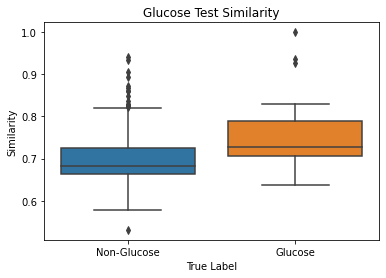

In [35]:
sns.boxplot(x="label", y="similarity", data=glucose_final)

plt.title('Glucose Test Similarity')
plt.xlabel('True Label')
plt.ylabel('Similarity')

**AUC**

In [37]:
# Calculate ROC and AUC
glucose_fpr, glucose_tpr, _ = roc_curve(glucose_df['label_true'], glucose_df['similarity'])
auc_glucose = auc(glucose_fpr, glucose_tpr)

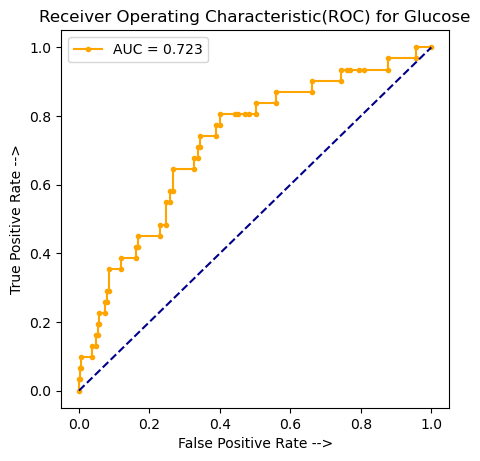

In [38]:
# Plot 
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(glucose_fpr, glucose_tpr, marker='.', color='orange', label='AUC = %0.3f' % auc_glucose)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.title('Receiver Operating Characteristic(ROC) for Glucose')
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

**Precision Recall**

Precision = True Positives / (True Positives + False Positives)

Recall = True Positives / (True Positives + False Negatives) = Sensitivity

In [40]:
precision_glucose, recall_glucose, __ = precision_recall_curve(glucose_df['label_true'], glucose_df['similarity'])
auc_glucose = metrics.auc(recall_glucose, precision_glucose)
aps_glucose = average_precision_score(glucose_df['label_true'], glucose_df['similarity'])

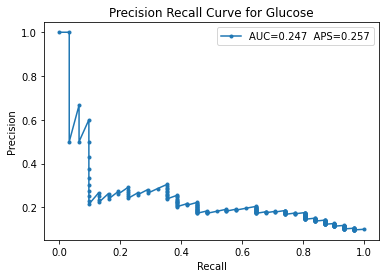

In [41]:
# plot the precision-recall curves
plt.plot(recall_glucose, precision_glucose, marker='.', label='AUC={:.3f}  APS={:.3f}'.format(auc_glucose, aps_glucose))
# axis labels
plt.title('Precision Recall Curve for Glucose')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

APS: Balanced - 0.5; Perfect - 1.0

* **hematocrit**

In [42]:
# Create the hematocrit dataframe
hematocrit_df = cross_comp[cross_comp['paired_grouper'] == 'hematocrit']

In [43]:
hematocrit_df.sort_values(by='similarity', ascending = False).head(30)

raw paired_grouper true_grouper  \
4735                              HEMATOCRIT     hematocrit   hematocrit   
4987                        HEMATOCRIT BLOOD     hematocrit   hematocrit   
3475                         DUAP HEMATOCRIT     hematocrit   hematocrit   
5203                      HEMATOCRIT, VENOUS     hematocrit   hematocrit   
4843                  HEMATOCRIT     (BKRAF)     hematocrit   hematocrit   
4699               HCT (HEMATOCRIT EXTERNAL)     hematocrit   hematocrit   
5059                    HEMATOCRIT, ARTERIAL     hematocrit   hematocrit   
5023                    HEMATOCRIT     (BKR)     hematocrit   hematocrit   
4771                    HEMATOCRIT     (BKR)     hematocrit   hematocrit   
4807                   HEMATOCRIT     (BKR)      hematocrit   hematocrit   
4879                   HEMATOCRIT   (BKRREF)     hematocrit   hematocrit   
5347                       I STAT HEMATOCRIT     hematocrit   hematocrit   
4915                    HEMATOCRIT (LABCORP)     hematocrit   hematocrit   
5167                 HEMATOCRIT, ARTERIAL OR     hematocrit   hematocrit   
4951                    HEMATOCRIT - LABCORP     hematocrit   hematocrit   
5311            HEMATOCRIT-WHOLE BLOOD (BKR)     hematocrit   hematocrit   
5239            HEMATOCRIT, VENOUS     (BKR)     hematocrit   hematocrit   
5275                HEMATOCRIT, VENOUS (BKR)     hematocrit   hematocrit   
5095          HEMATOCRIT, ARTERIAL     (BKR)     hematocrit   hematocrit   
5131              HEMATOCRIT, ARTERIAL (BKR)     hematocrit   hematocrit   
7327                          PLATELET COUNT     hematocrit     platelet   
8551      POC HEMATOCRIT, ARTERIAL     (BKR)     hematocrit   hematocrit   
7507          PLT (PLATELET COUNT  EXTERNAL)     hematocrit     platelet   
7399              PLATELET COUNT     (BKRAF)     hematocrit     platelet   
8659             POC I STAT HEMATOCRIT (BKR)     hematocrit   hematocrit   
11647     WHITE BLOOD CELL COUNT     (BKRAF)     hematocrit          wbc   
7543    PLT (PLATELET COUNT) EXTERNAL (ARMC)     hematocrit     platelet   
11431  WBC (WHITE BLOOD CELL COUNT EXTERNAL)     hematocrit          wbc   
7363                PLATELET COUNT     (BKR)     hematocrit     platelet   
11539                 WHITE BLOOD CELL COUNT     hematocrit          wbc   

       similarity  label_true  
4735     1.000000           1  
4987     0.984230           1  
3475     0.951087           1  
5203     0.947249           1  
4843     0.941620           1  
4699     0.939409           1  
5059     0.938570           1  
5023     0.935014           1  
4771     0.935014           1  
4807     0.935014           1  
4879     0.930815           1  
5347     0.930549           1  
4915     0.929708           1  
5167     0.918232           1  
4951     0.911982           1  
5311     0.898361           1  
5239     0.896586           1  
5275     0.896586           1  
5095     0.894081           1  
5131     0.894081           1  
7327     0.890563           0  
8551     0.879997           1  
7507     0.878027           0  
7399     0.876808           0  
8659     0.876619           1  
11647    0.874371           0  
7543     0.873620           0  
11431    0.871574           0  
7363     0.868892           0  
11539    0.867117           0

In [44]:
hem = hematocrit_df.reset_index() # reset index for upcoming for loop

label = []
for i in tqdm.tqdm(range(hem.shape[0])):
    if (hem.loc[i,'label_true'] == 1):
        label.append("Hematocrit")  # 1 - Correctly labeled
    else:
        label.append("Non-hematocrit")  # 0 - Incorrectly labeled
        
hem['label'] = label
hematocrit_final = hem.loc[:, ("similarity", "label")]

100%|██████████| 324/324 [00:00<00:00, 35046.28it/s]


In [45]:
hematocrit_final

similarity           label
0      0.752142  Non-hematocrit
1      0.798275  Non-hematocrit
2      0.766328  Non-hematocrit
3      0.770437  Non-hematocrit
4      0.775859  Non-hematocrit
..          ...             ...
319    0.755592  Non-hematocrit
320    0.867117  Non-hematocrit
321    0.843986  Non-hematocrit
322    0.855121  Non-hematocrit
323    0.874371  Non-hematocrit

[324 rows x 2 columns]

Text(0, 0.5, 'Similarity')

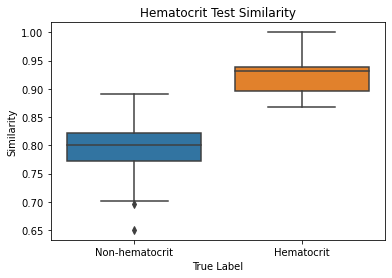

In [46]:
sns.boxplot(x="label", y="similarity", data=hematocrit_final)

plt.title('Hematocrit Test Similarity')
plt.xlabel('True Label')
plt.ylabel('Similarity')

In [47]:
# Calculate ROC and AUC
hematocrit_fpr, hematocrit_tpr, _ = roc_curve(hematocrit_df['label_true'], hematocrit_df['similarity'])
auc_hematocrit = auc(hematocrit_fpr, hematocrit_tpr)

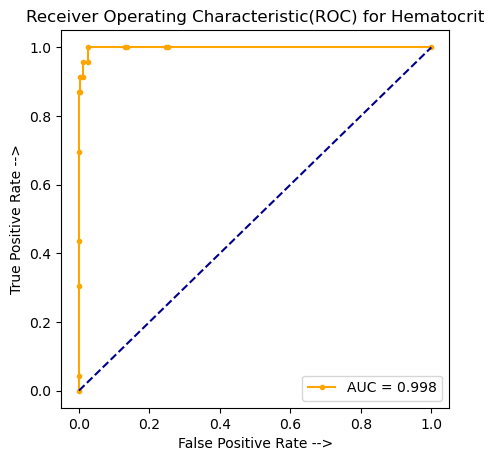

In [48]:
# Plot 
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(hematocrit_fpr, hematocrit_tpr, marker='.', color='orange', label='AUC = %0.3f' % auc_hematocrit)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.title('Receiver Operating Characteristic(ROC) for Hematocrit')
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [49]:
# Calculate Precision Recall
precision_hematocrit, recall_hematocrit, __ = precision_recall_curve(hematocrit_df['label_true'], hematocrit_df['similarity'])
auc_hematocrit = metrics.auc(recall_hematocrit, precision_hematocrit)
aps_hematocrit = average_precision_score(hematocrit_df['label_true'], hematocrit_df['similarity'])

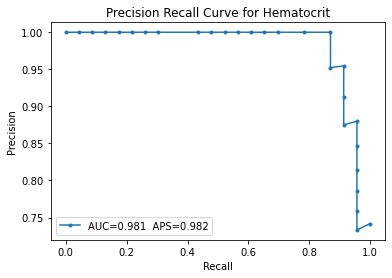

In [50]:
# plot the precision-recall curves
plt.plot(recall_hematocrit, precision_hematocrit, marker='.', label='AUC={:.3f}  APS={:.3f}'.format(auc_hematocrit, aps_hematocrit))
# axis labels
plt.title('Precision Recall Curve for Hematocrit')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

* **influenza**

In [51]:
# Create the hematocrit dataframe
influenza_df = cross_comp[cross_comp['paired_grouper'] == 'influenza']
inf = influenza_df.reset_index() # reset index for upcoming for loop

label = []
for i in tqdm.tqdm(range(inf.shape[0])):
    if (inf.loc[i,'label_true'] == 1):
        label.append("influenza")  # 1 - Correctly labeled
    else:
        label.append("non-influenza")  # 0 - Incorrectly labeled
        
inf['label'] = label
influenza_final = inf.loc[:, ("similarity", "label")]

100%|██████████| 324/324 [00:00<00:00, 38442.84it/s]


Text(0, 0.5, 'Similarity')

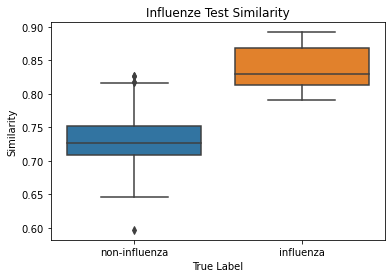

In [52]:
# boxplot
sns.boxplot(x="label", y="similarity", data=influenza_final)

plt.title('Influenze Test Similarity')
plt.xlabel('True Label')
plt.ylabel('Similarity')

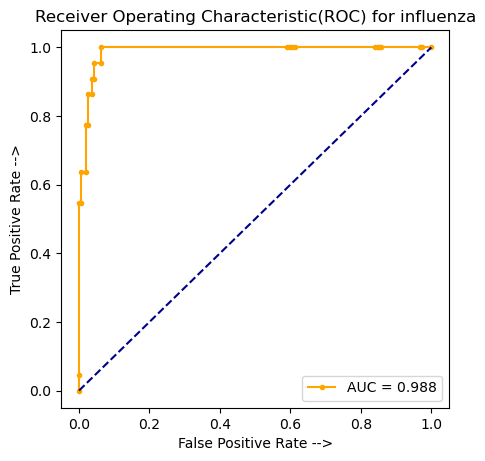

In [53]:
# Calculate ROC and AUC
influenza_fpr, influenza_tpr, _ = roc_curve(influenza_df['label_true'], influenza_df['similarity'])
auc_influenza = auc(influenza_fpr, influenza_tpr)

# Plot 
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(influenza_fpr, influenza_tpr, marker='.', color='orange', label='AUC = %0.3f' % auc_influenza)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.title('Receiver Operating Characteristic(ROC) for influenza')
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

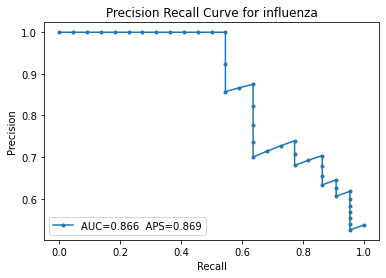

In [54]:
# Calculate Precision Recall
precision_influenza, recall_influenza, __ = precision_recall_curve(influenza_df['label_true'], influenza_df['similarity'])
auc_influenza = metrics.auc(recall_influenza, precision_influenza)
aps_influenza = average_precision_score(influenza_df['label_true'], influenza_df['similarity'])

# plot the precision-recall curves
plt.plot(recall_influenza, precision_influenza, marker='.', label='AUC={:.3f}  APS={:.3f}'.format(auc_influenza, aps_influenza))
# axis labels
plt.title('Precision Recall Curve for influenza')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

* **creatinine**

In [55]:
# Create the hematocrit dataframe
creatinine_df = cross_comp[cross_comp['paired_grouper'] == 'creatinine']
cre = creatinine_df.reset_index() # reset index for upcoming for loop

label = []
for i in tqdm.tqdm(range(cre.shape[0])):
    if (cre.loc[i,'label_true'] == 1):
        label.append("creatinine")  # 1 - Correctly labeled
    else:
        label.append("non-creatinine")  # 0 - Incorrectly labeled
        
cre['label'] = label
creatinine_final = cre.loc[:, ("similarity", "label")]

100%|██████████| 324/324 [00:00<00:00, 46260.71it/s]


Text(0, 0.5, 'Similarity')

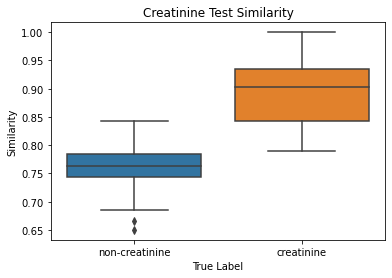

In [56]:
# boxplot
sns.boxplot(x="label", y="similarity", data=creatinine_final)

plt.title('Creatinine Test Similarity')
plt.xlabel('True Label')
plt.ylabel('Similarity')

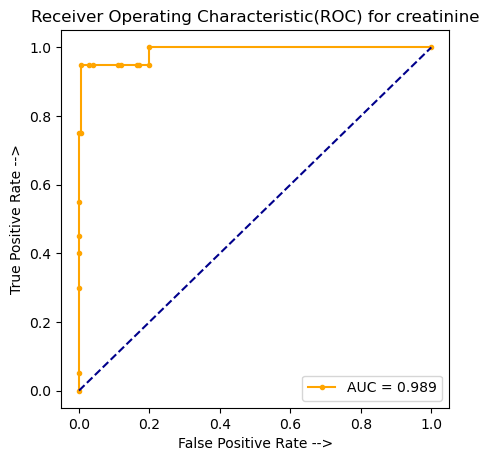

In [58]:
# Calculate ROC and AUC
creatinine_fpr, creatinine_tpr, _ = roc_curve(creatinine_df['label_true'], creatinine_df['similarity'])
auc_creatinine = auc(creatinine_fpr, creatinine_tpr)

# Plot 
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(creatinine_fpr, creatinine_tpr, marker='.', color='orange', label='AUC = %0.3f' % auc_creatinine)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.title('Receiver Operating Characteristic(ROC) for creatinine')
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

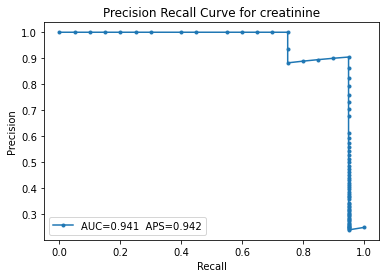

In [60]:
# Calculate Precision Recall
precision_creatinine, recall_creatinine, __ = precision_recall_curve(creatinine_df['label_true'], creatinine_df['similarity'])
auc_creatinine = metrics.auc(recall_creatinine, precision_creatinine)
aps_creatinine = average_precision_score(creatinine_df['label_true'], creatinine_df['similarity'])

# plot the precision-recall curves
plt.plot(recall_creatinine, precision_creatinine, marker='.', label='AUC={:.3f}  APS={:.3f}'.format(auc_creatinine, aps_creatinine))
# axis labels
plt.title('Precision Recall Curve for creatinine')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

* **Automated Function**

**Filtered Dataframe:**

`d` - a dictionary with key=grouper & value=labelled dataframe with similarity (*d["albumin"]*)

`auc_df / aps_df` - a dataframe with all groupers and AUC / APS scores

`evaluation` - a dataframe with both AUC and APS scores



In [61]:
# Create automated function
d = {}

for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    filter_df = cross_comp[cross_comp['paired_grouper'] == grouper].reset_index()

    label = []
    for j in tqdm.tqdm(range(filter_df.shape[0])):
        if (filter_df.loc[j,'label_true'] == 1):
            label.append(grouper)  # 1 - Correctly labeled
        else:
            label.append("non-%s" % grouper)  # 0 - Incorrectly labeled
        
    filter_df['label'] = label
    filter_final = filter_df.loc[:, ("similarity", "label")]
    
    d[grouper] = filter_final

100%|██████████| 324/324 [00:00<00:00, 81697.40it/s]

100%|██████████| 324/324 [00:00<00:00, 111645.95it/s]

100%|██████████| 324/324 [00:00<00:00, 122131.26it/s]

100%|██████████| 324/324 [00:00<00:00, 138881.40it/s]

100%|██████████| 324/324 [00:00<00:00, 136825.87it/s]

100%|██████████| 324/324 [00:00<00:00, 143243.86it/s]

100%|██████████| 324/324 [00:00<00:00, 145685.52it/s]

100%|██████████| 324/324 [00:00<00:00, 148147.23it/s]

100%|██████████| 324/324 [00:00<00:00, 172521.84it/s]

100%|██████████| 324/324 [00:00<00:00, 172259.41it/s]

100%|██████████| 324/324 [00:00<00:00, 144646.57it/s]

100%|██████████| 324/324 [00:00<00:00, 169108.32it/s]

100%|██████████| 324/324 [00:00<00:00, 160803.99it/s]

100%|██████████| 324/324 [00:00<00:00, 174091.02it/s]

100%|██████████| 324/324 [00:00<00:00, 166742.88it/s]

100%|██████████| 324/324 [00:00<00:00, 172521.84it/s]

100%|██████████| 324/324 [00:00<00:00, 174920.13it/s]

100%|██████████| 324/324 [00:00<00:00, 161587.93it/s]

100%|██████

**Boxplot:**

 56%|█████▌    | 20/36 [00:01<00:00, 19.46it/s]<ipython-input-104-89a0791f6f65>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 36/36 [00:01<00:00, 18.75it/s]


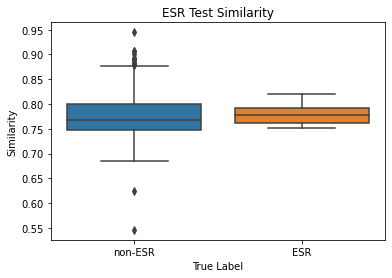

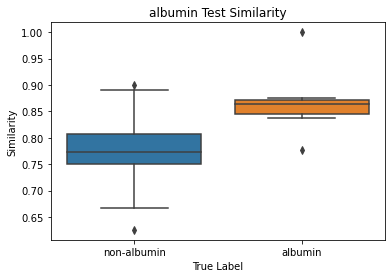

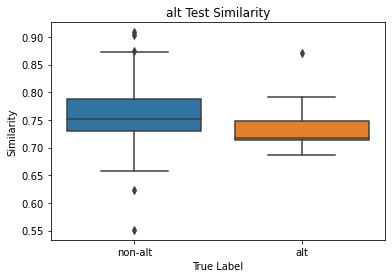

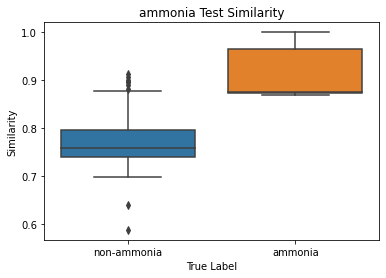

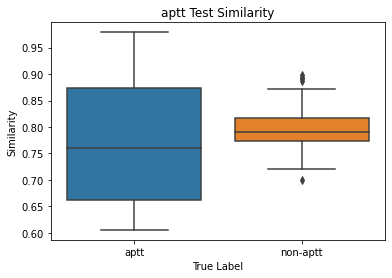

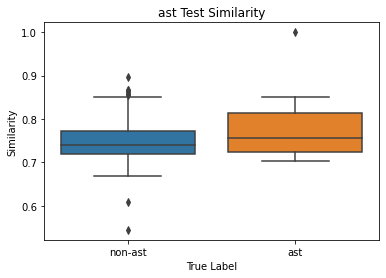

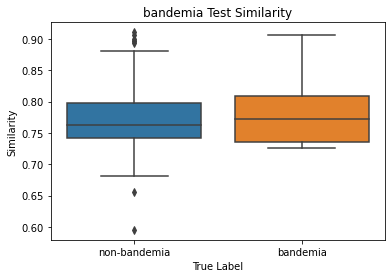

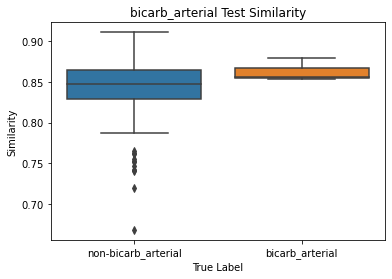

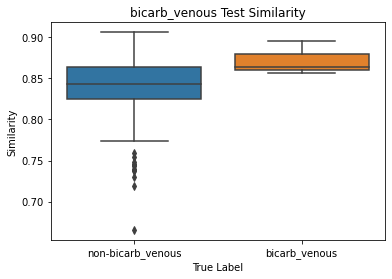

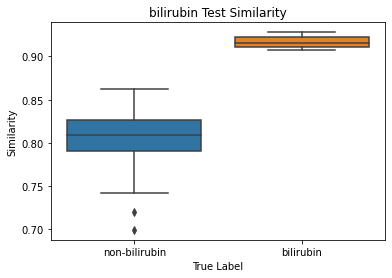

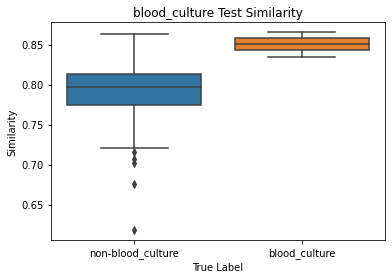

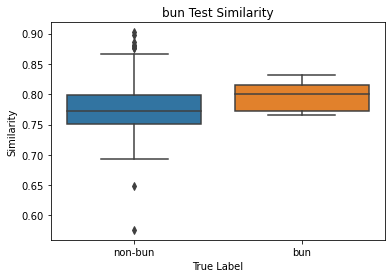

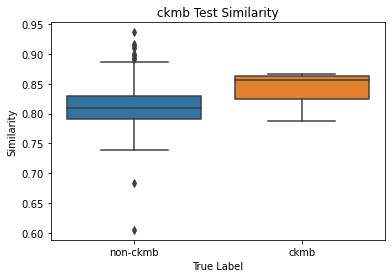

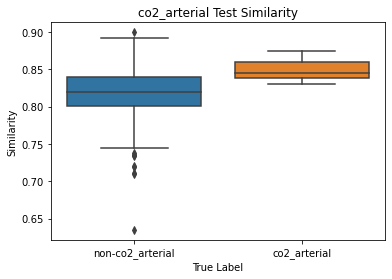

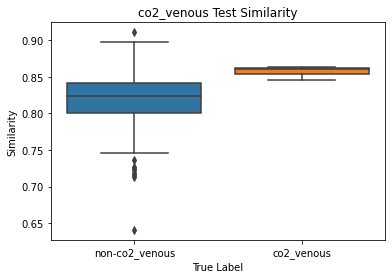

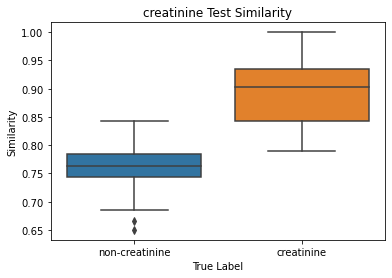

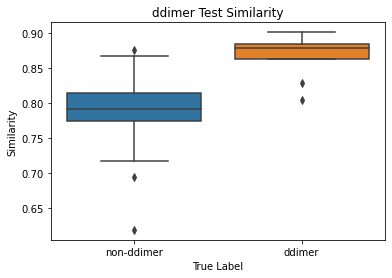

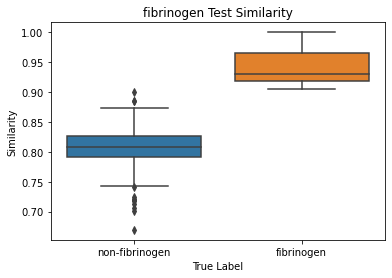

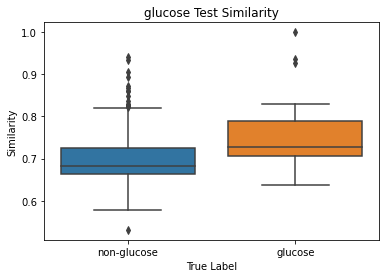

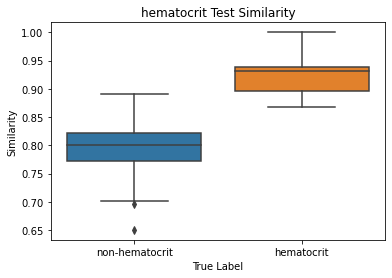

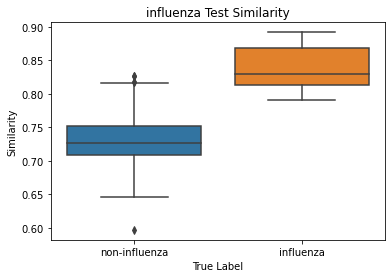

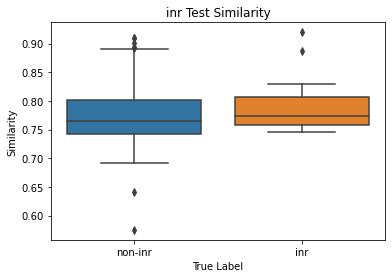

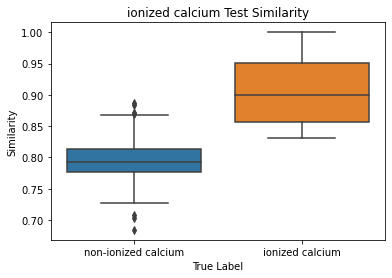

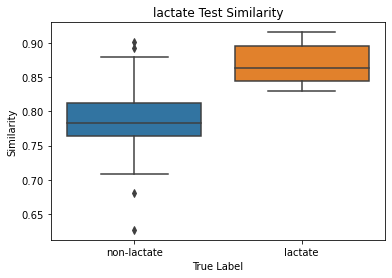

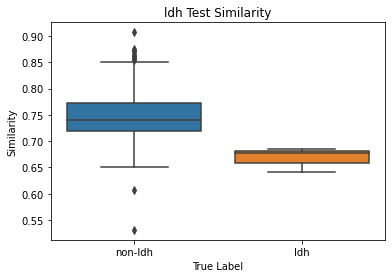

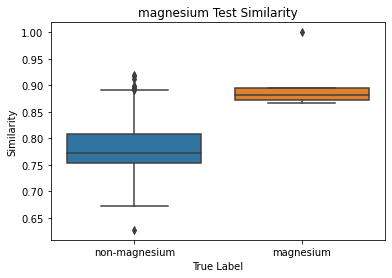

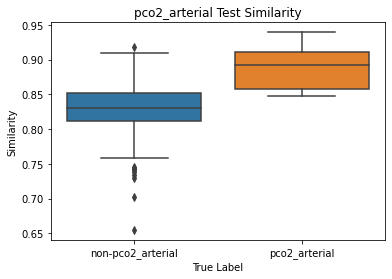

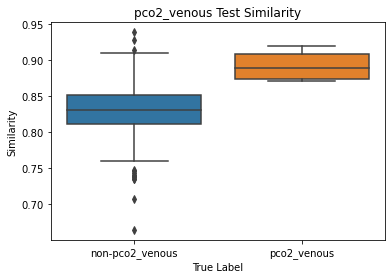

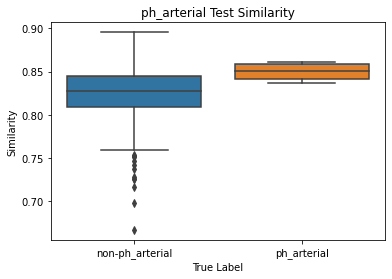

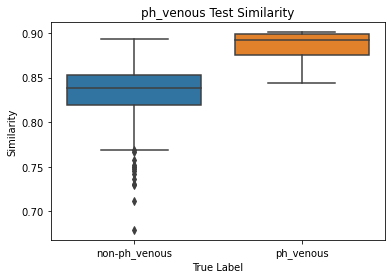

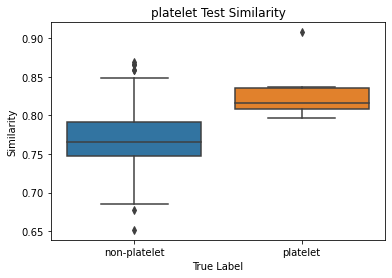

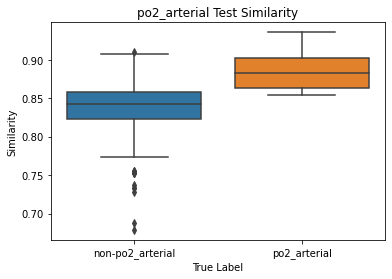

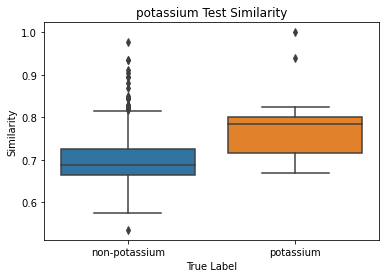

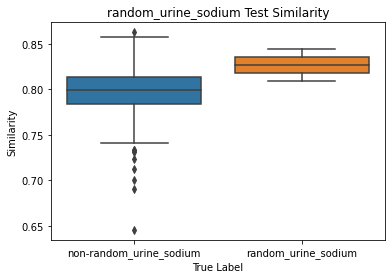

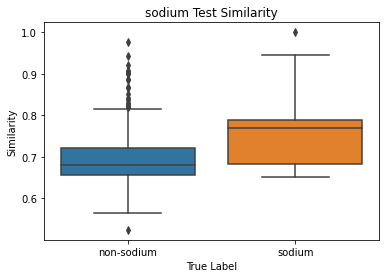

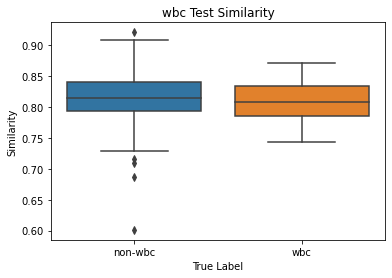

In [104]:
# Save all plots to local
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    
    plt.figure()
    sns.boxplot(x="label", y="similarity", data=d[grouper])
    plt.title('%s Test Similarity' % grouper)
    plt.xlabel('True Label')
    plt.ylabel('Similarity')
    #plt.show( block=False )
    #plt.savefig('/Users/hollycui/Desktop/HDS/plots/boxplot/%s_boxplot.png'%grouper)

In [ ]:
# Put all together
import math

i,j=0,0
PLOTS_PER_ROW = 6
fig, axs = plt.subplots(math.ceil(len(df.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in df.columns:
    axs[i][j].scatter(df['target_col'], df[col], s=3)
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

**ROC:**

 53%|█████▎    | 19/36 [00:01<00:01, 16.41it/s]<ipython-input-125-dbc145a6d654>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5), dpi=100)
100%|██████████| 36/36 [00:02<00:00, 15.12it/s]


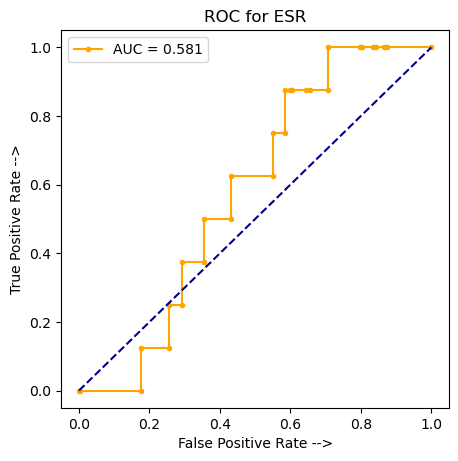

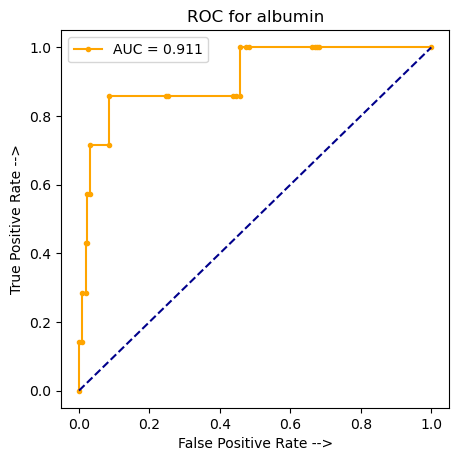

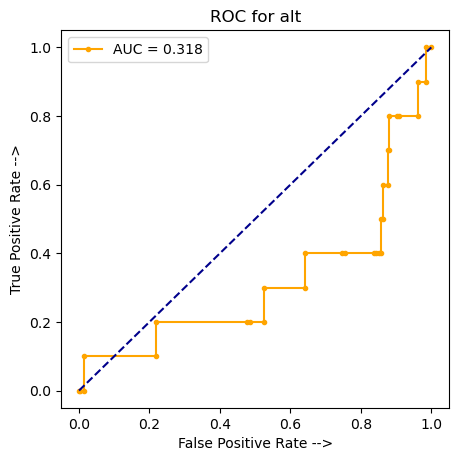

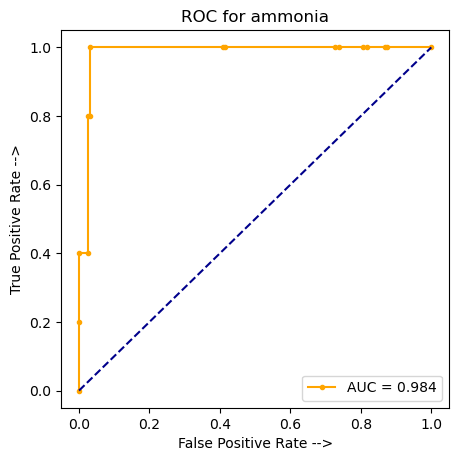

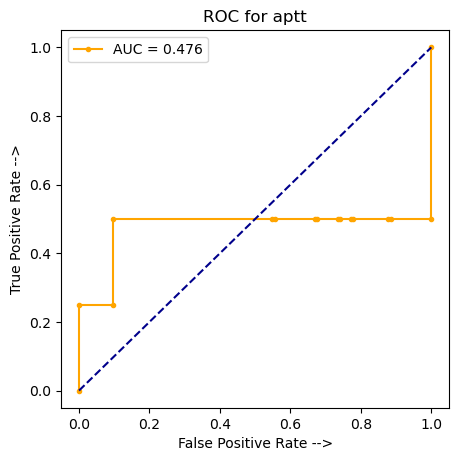

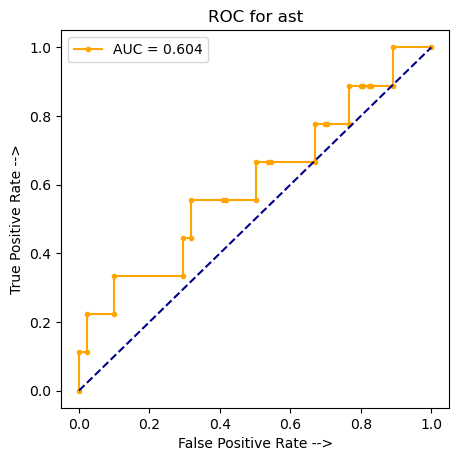

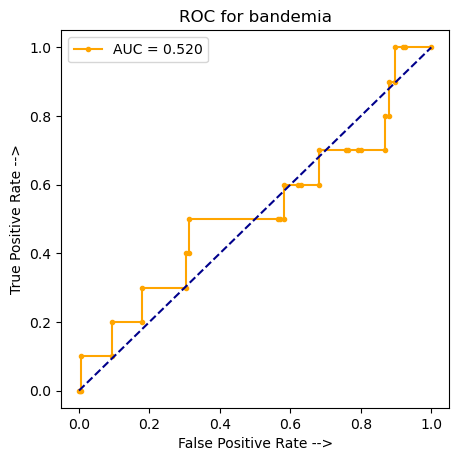

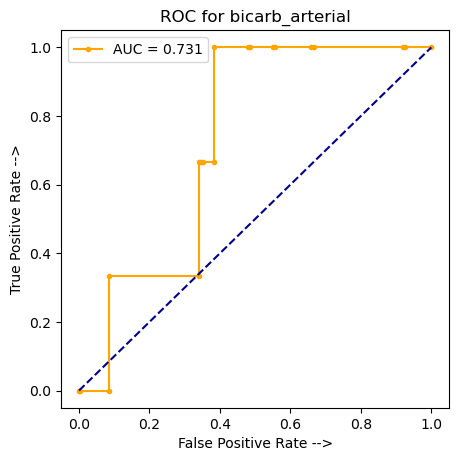

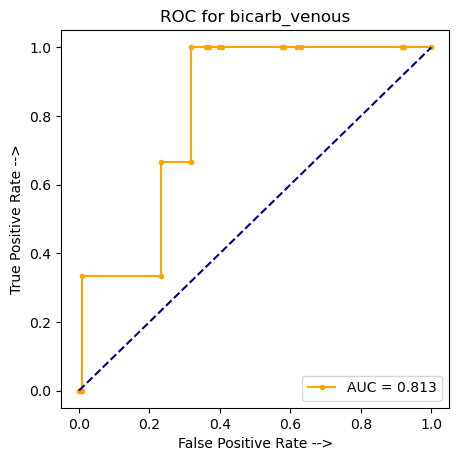

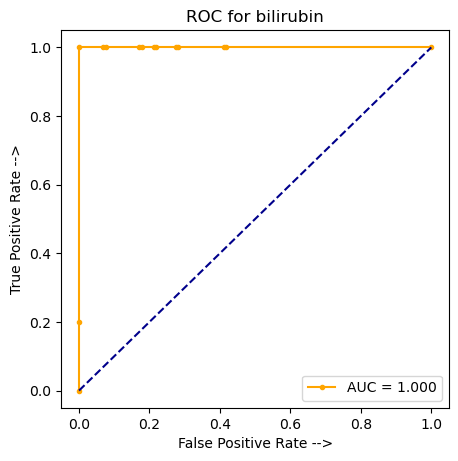

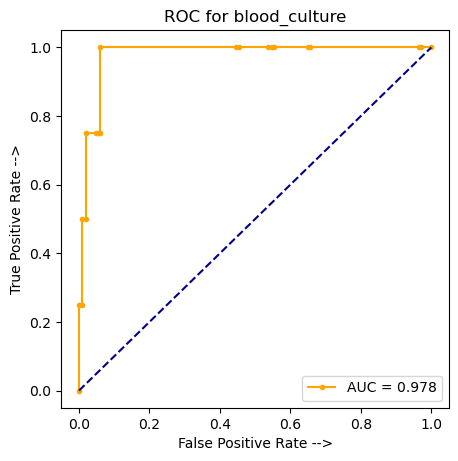

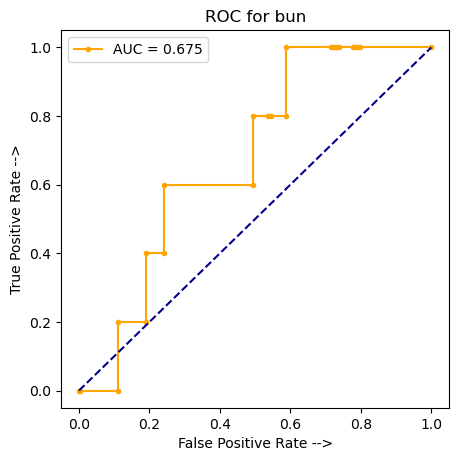

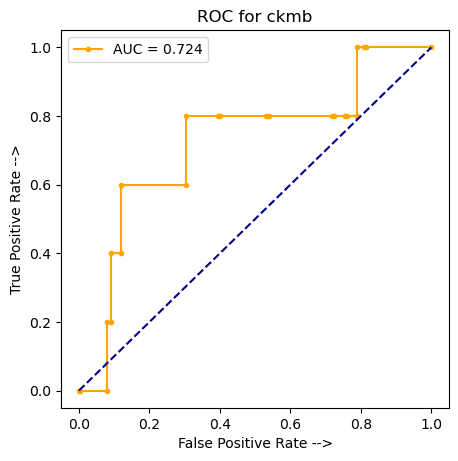

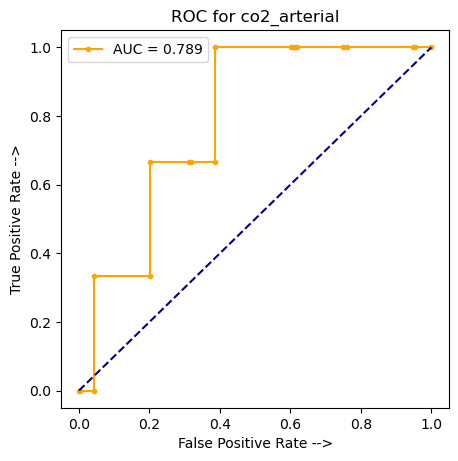

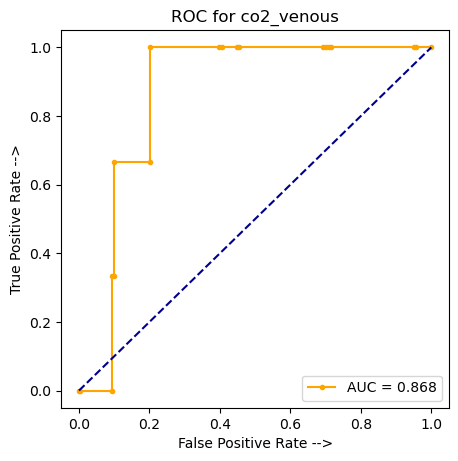

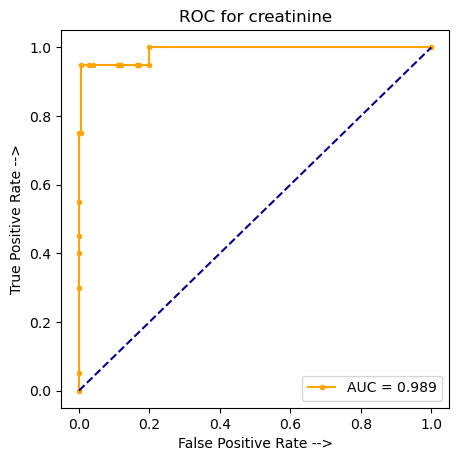

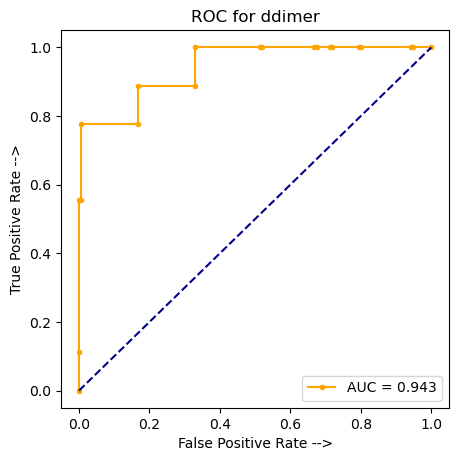

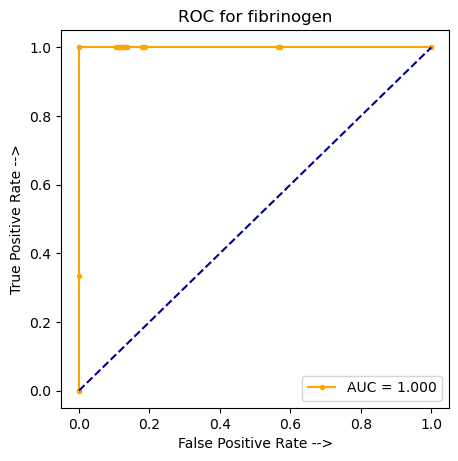

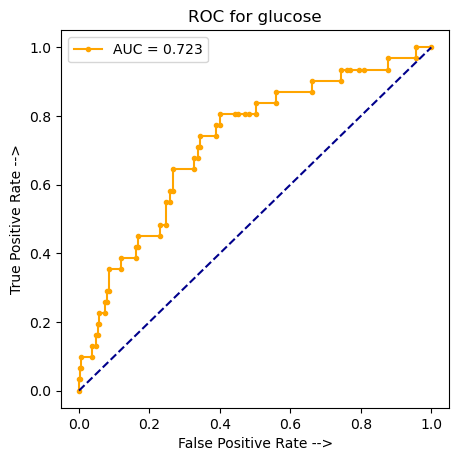

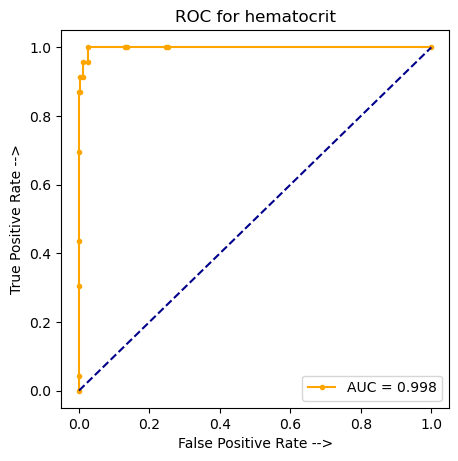

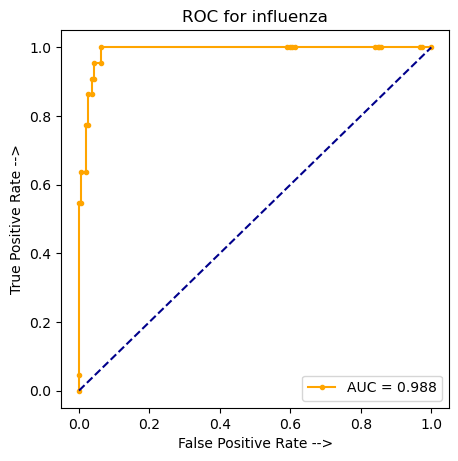

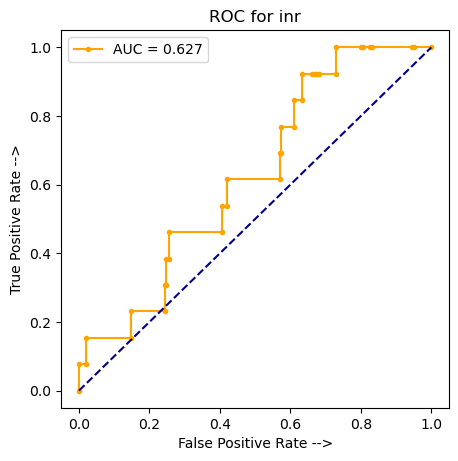

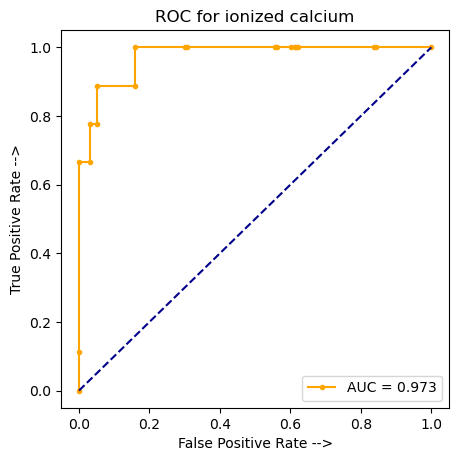

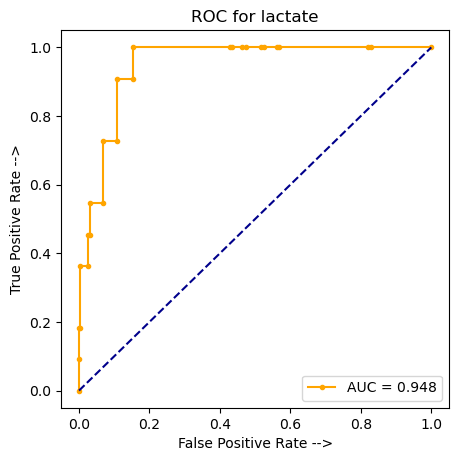

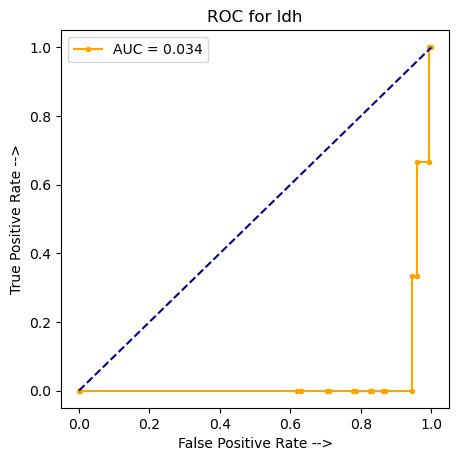

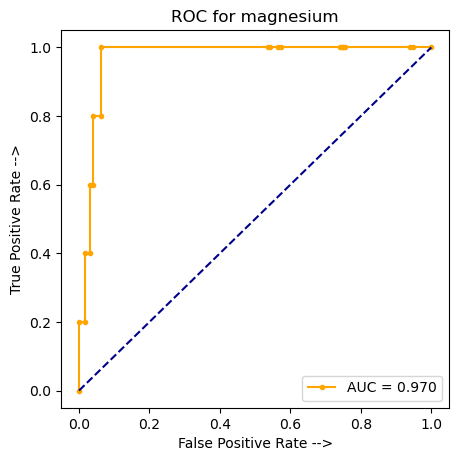

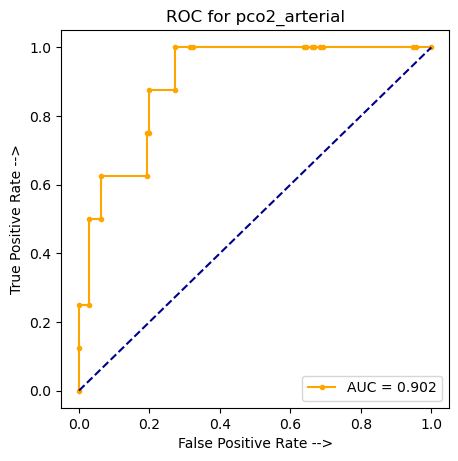

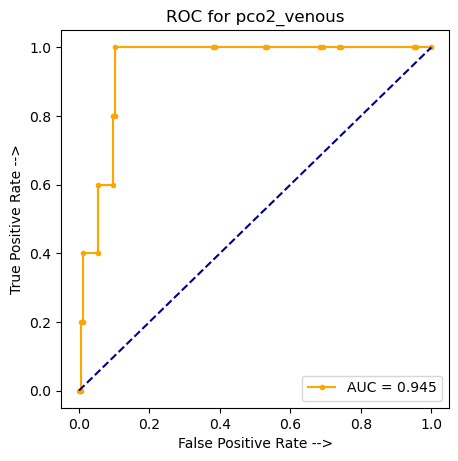

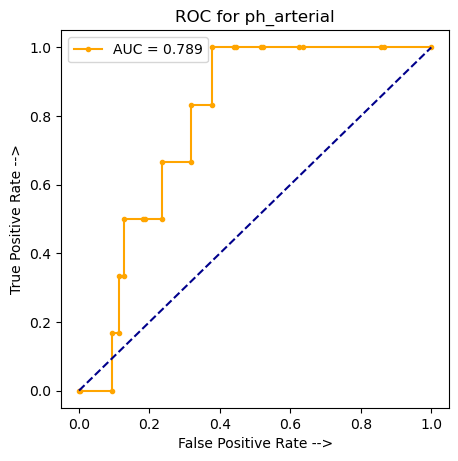

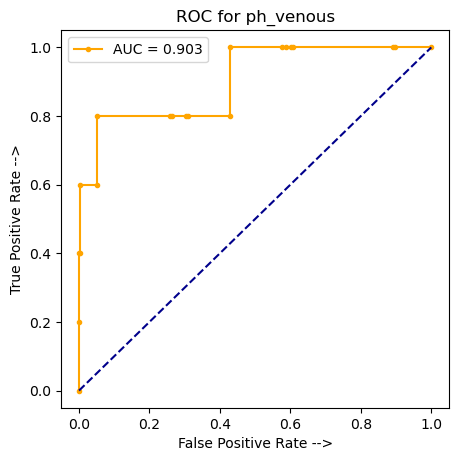

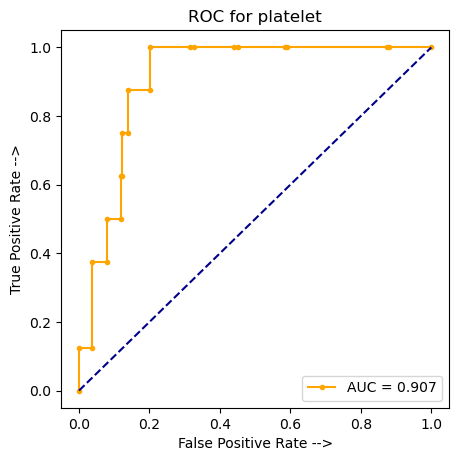

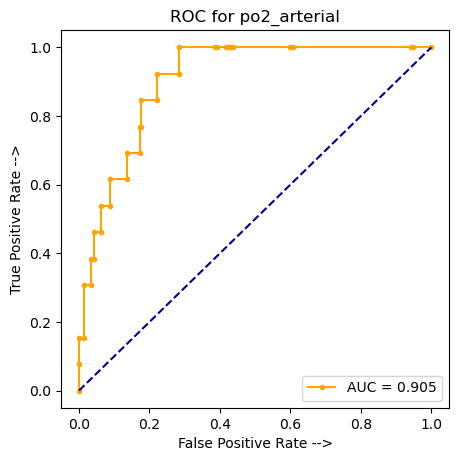

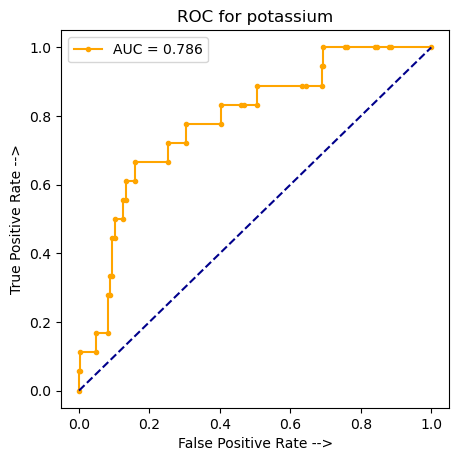

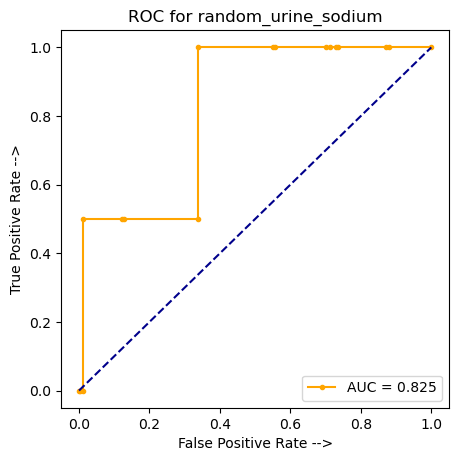

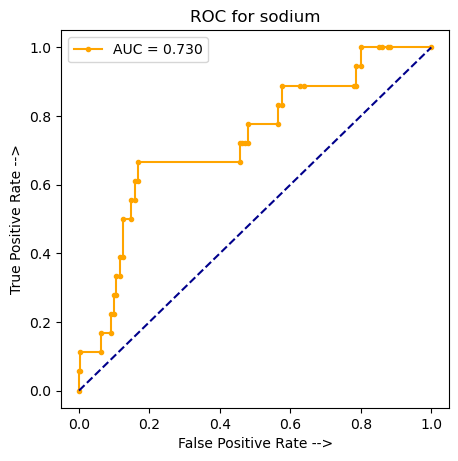

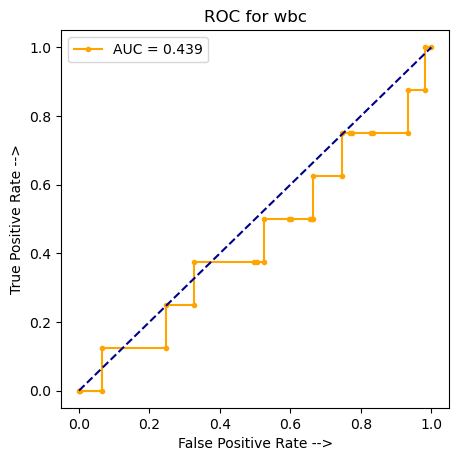

In [125]:
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_comp[cross_comp['paired_grouper'] == grouper].reset_index()
    
    fpr, tpr, _ = roc_curve(df['label_true'], df['similarity'])
    auc = metrics.auc(fpr, tpr)

    # Plot 
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, marker='.', color='orange', label='AUC = %0.3f' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

    plt.title('ROC for %s' % grouper)
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()

    #plt.savefig('/Users/hollycui/Desktop/HDS/plots/ROC/%s_roc.png'%grouper)

In [62]:
# Create auc dictionary
auc = {}
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_comp[cross_comp['paired_grouper'] == grouper].reset_index()
    
    fpr, tpr, _ = roc_curve(df['label_true'], df['similarity'])
    auc_calc = metrics.auc(fpr, tpr)
    
    auc[grouper] = auc_calc

100%|██████████| 36/36 [00:00<00:00, 453.18it/s]


In [63]:
auc_df = pd.DataFrame(list(auc.items()), columns = ['grouper', 'AUC'])

In [64]:
auc_df.sort_values(by='AUC', ascending=False)

grouper       AUC
9             bilirubin  1.000000
17           fibrinogen  1.000000
19           hematocrit  0.998267
15           creatinine  0.988816
20            influenza  0.987809
3               ammonia  0.983699
10        blood_culture  0.978125
22      ionized calcium  0.973192
25            magnesium  0.969906
23              lactate  0.948301
27          pco2_venous  0.945455
16               ddimer  0.943210
1               albumin  0.910771
30             platelet  0.907437
31         po2_arterial  0.904526
29            ph_venous  0.903448
26        pco2_arterial  0.901899
14           co2_venous  0.868120
33  random_urine_sodium  0.824534
8         bicarb_venous  0.813084
13         co2_arterial  0.789200
28          ph_arterial  0.788784
32            potassium  0.785585
7       bicarb_arterial  0.731049
34               sodium  0.729666
12                 ckmb  0.723511
18              glucose  0.722889
11                  bun  0.675235
21                  inr  0.626515
5                   ast  0.604233
0                   ESR  0.581092
6              bandemia  0.519745
4                  aptt  0.475781
35                  wbc  0.438687
2                   alt  0.318153
24                  ldh  0.034268

**Precision Recall Curve:**

 53%|█████▎    | 19/36 [00:01<00:00, 20.02it/s]<ipython-input-126-1ff0f4c9ecbf>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 36/36 [00:02<00:00, 17.82it/s]


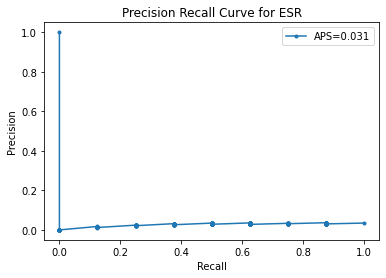

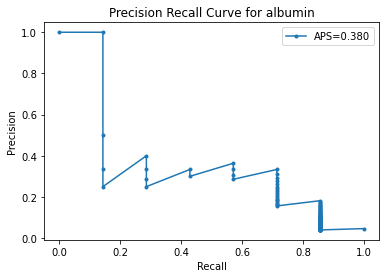

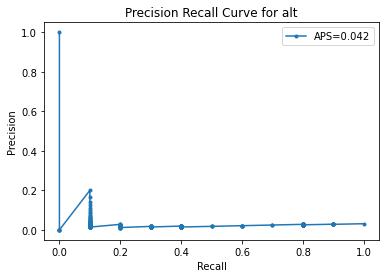

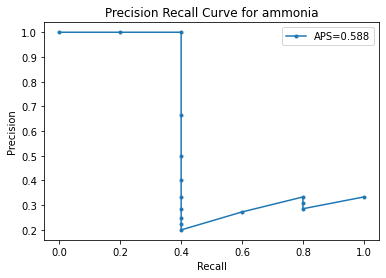

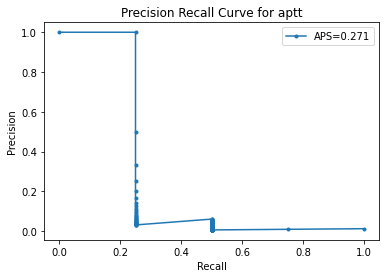

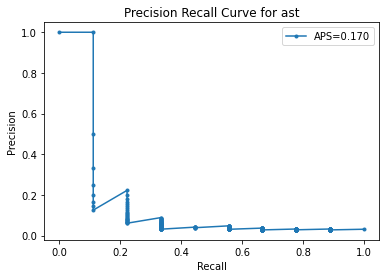

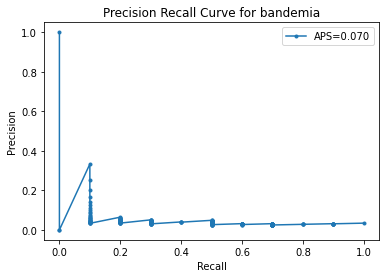

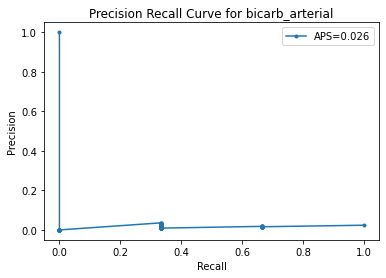

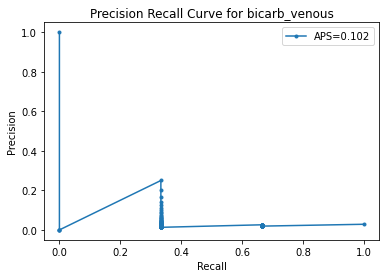

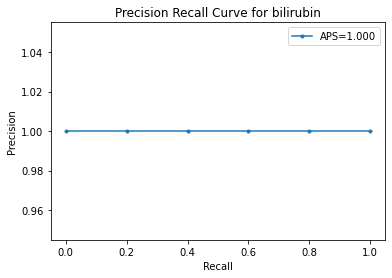

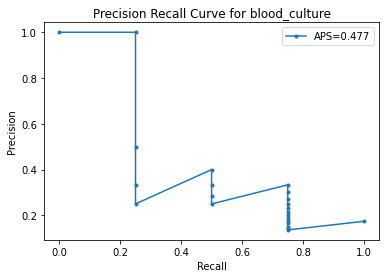

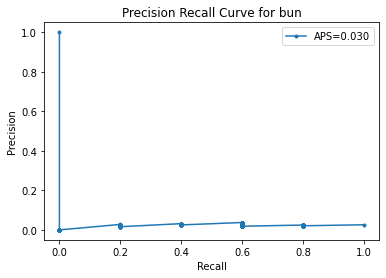

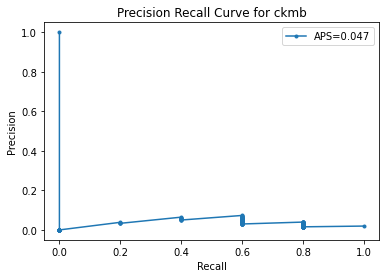

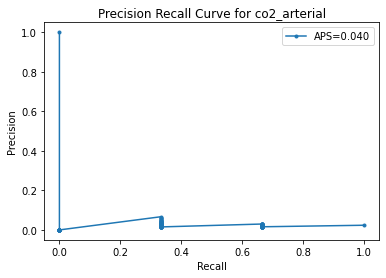

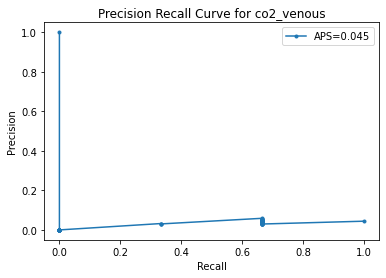

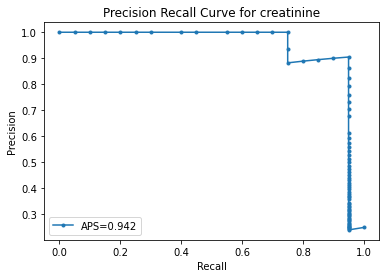

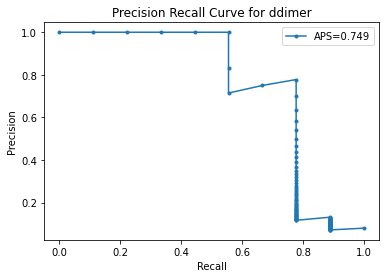

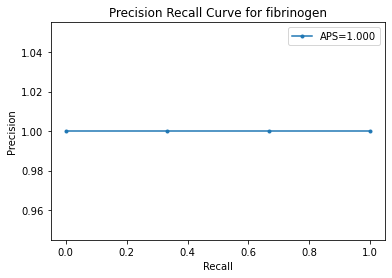

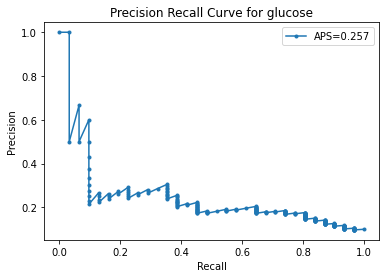

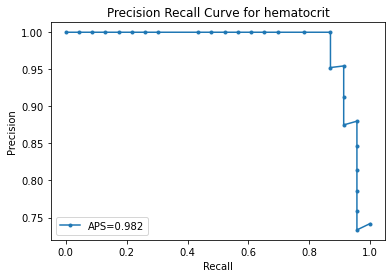

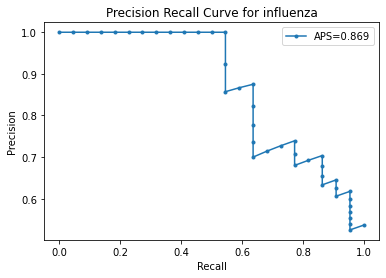

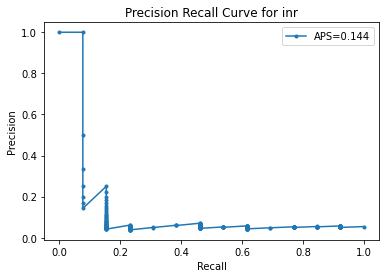

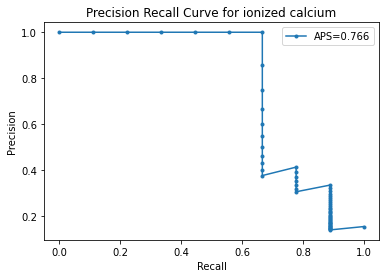

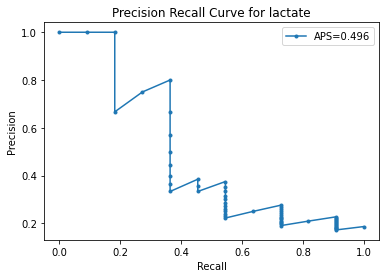

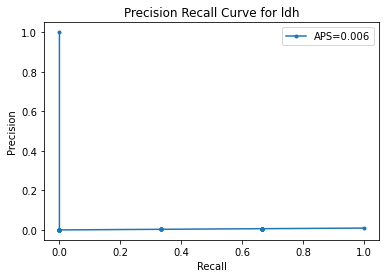

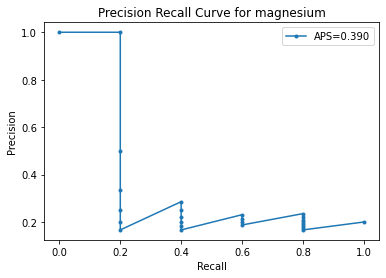

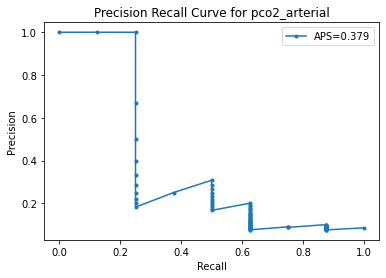

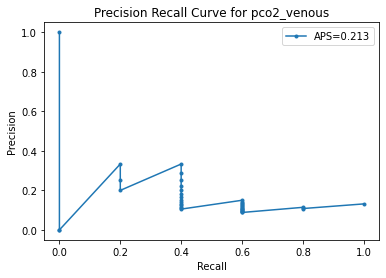

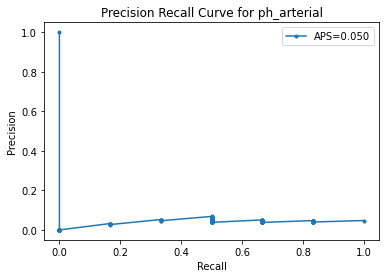

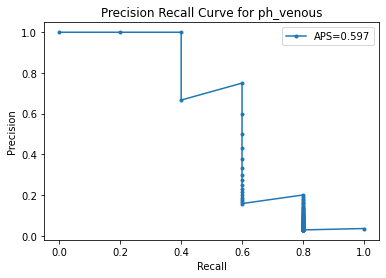

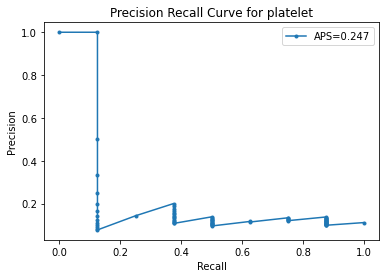

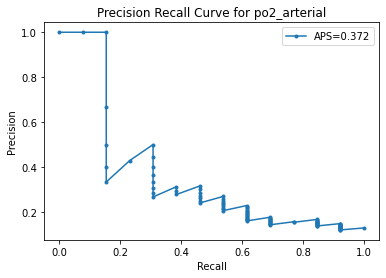

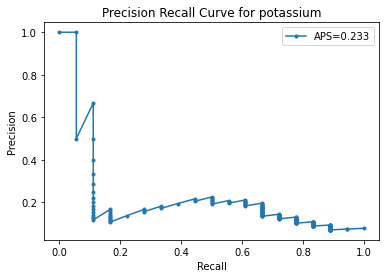

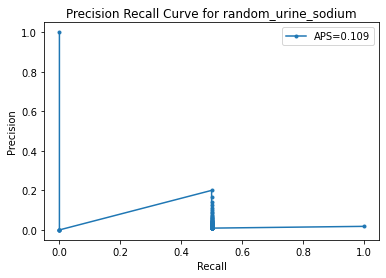

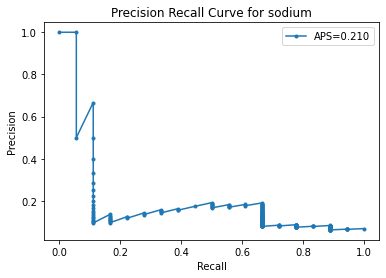

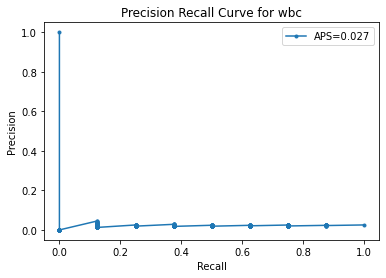

In [126]:
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_comp[cross_comp['paired_grouper'] == grouper].reset_index()

    # Calculate Precision Recall
    precision, recall, __ = precision_recall_curve(df['label_true'], df['similarity'])
    aps = average_precision_score(df['label_true'], df['similarity'])

    # plot the precision-recall curves
    plt.figure()
    plt.plot(recall, precision, marker='.', label='APS={:.3f}'.format(aps))
    # axis labels
    plt.title('Precision Recall Curve for %s' % grouper)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend()
    plt.savefig('/Users/hollycui/Desktop/HDS/plots/PRC/%s_prc.png' % grouper)

In [65]:
aps = {}
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_comp[cross_comp['paired_grouper'] == grouper].reset_index()

    # Calculate Precision Recall
    precision, recall, __ = precision_recall_curve(df['label_true'], df['similarity'])
    aps_calc = average_precision_score(df['label_true'], df['similarity'])
    
    aps[grouper] = aps_calc

100%|██████████| 36/36 [00:00<00:00, 375.94it/s]


In [66]:
aps_df = pd.DataFrame(list(aps.items()), columns = ['grouper', 'APS'])

In [67]:
aps_df.sort_values(by='APS', ascending=False)

grouper       APS
9             bilirubin  1.000000
17           fibrinogen  1.000000
19           hematocrit  0.981586
15           creatinine  0.941919
20            influenza  0.868989
22      ionized calcium  0.766404
16               ddimer  0.748730
29            ph_venous  0.597042
3               ammonia  0.587879
23              lactate  0.496227
10        blood_culture  0.476812
25            magnesium  0.390356
1               albumin  0.379739
26        pco2_arterial  0.379044
31         po2_arterial  0.371609
4                  aptt  0.270560
18              glucose  0.257343
30             platelet  0.247346
32            potassium  0.233465
27          pco2_venous  0.212506
34               sodium  0.210110
5                   ast  0.170130
21                  inr  0.143912
33  random_urine_sodium  0.109009
8         bicarb_venous  0.101515
6              bandemia  0.069536
28          ph_arterial  0.049749
12                 ckmb  0.047042
14           co2_venous  0.045066
2                   alt  0.041873
13         co2_arterial  0.040046
0                   ESR  0.030948
11                  bun  0.029551
35                  wbc  0.027334
7       bicarb_arterial  0.025847
24                  ldh  0.006353

In [68]:
evaluation = pd.merge(auc_df, aps_df, on="grouper")
evaluation.sort_values(by='AUC', ascending=False)

grouper       AUC       APS
9             bilirubin  1.000000  1.000000
17           fibrinogen  1.000000  1.000000
19           hematocrit  0.998267  0.981586
15           creatinine  0.988816  0.941919
20            influenza  0.987809  0.868989
3               ammonia  0.983699  0.587879
10        blood_culture  0.978125  0.476812
22      ionized calcium  0.973192  0.766404
25            magnesium  0.969906  0.390356
23              lactate  0.948301  0.496227
27          pco2_venous  0.945455  0.212506
16               ddimer  0.943210  0.748730
1               albumin  0.910771  0.379739
30             platelet  0.907437  0.247346
31         po2_arterial  0.904526  0.371609
29            ph_venous  0.903448  0.597042
26        pco2_arterial  0.901899  0.379044
14           co2_venous  0.868120  0.045066
33  random_urine_sodium  0.824534  0.109009
8         bicarb_venous  0.813084  0.101515
13         co2_arterial  0.789200  0.040046
28          ph_arterial  0.788784  0.049749
32            potassium  0.785585  0.233465
7       bicarb_arterial  0.731049  0.025847
34               sodium  0.729666  0.210110
12                 ckmb  0.723511  0.047042
18              glucose  0.722889  0.257343
11                  bun  0.675235  0.029551
21                  inr  0.626515  0.143912
5                   ast  0.604233  0.170130
0                   ESR  0.581092  0.030948
6              bandemia  0.519745  0.069536
4                  aptt  0.475781  0.270560
35                  wbc  0.438687  0.027334
2                   alt  0.318153  0.041873
24                  ldh  0.034268  0.006353

In [225]:
evaluation.sort_values(by='AUC', ascending=False).tail(10)

grouper       AUC       APS
18   glucose  0.722889  0.257343
11       bun  0.675235  0.029551
21       inr  0.626515  0.143912
5        ast  0.604233  0.170130
0        ESR  0.581092  0.030948
6   bandemia  0.519745  0.069536
4       aptt  0.475781  0.270560
35       wbc  0.438687  0.027334
2        alt  0.318153  0.041873
24       ldh  0.034268  0.006353

In [82]:
#evaluation.to_csv("/Users/hollycui/Desktop/HDS/data/evaluation.csv")

In [69]:
cross_comp[cross_comp['true_grouper'] == 'bun']

# bandemia - BAND in raw, full in grouper
# aptt - some full, most just use aptt
# ESR - not full, only part as raw
# inr - not a full form, used as inr both raw and grouper

raw       paired_grouper true_grouper  \
1872         BLOOD UREA NITROGEN - LABCORP                  ESR          bun   
1873         BLOOD UREA NITROGEN - LABCORP              albumin          bun   
1874         BLOOD UREA NITROGEN - LABCORP                  alt          bun   
1875         BLOOD UREA NITROGEN - LABCORP              ammonia          bun   
1876         BLOOD UREA NITROGEN - LABCORP                 aptt          bun   
...                                    ...                  ...          ...   
11407  UREA NITROGEN-WHOLE BLOOD     (BKR)         po2_arterial          bun   
11408  UREA NITROGEN-WHOLE BLOOD     (BKR)            potassium          bun   
11409  UREA NITROGEN-WHOLE BLOOD     (BKR)  random_urine_sodium          bun   
11410  UREA NITROGEN-WHOLE BLOOD     (BKR)               sodium          bun   
11411  UREA NITROGEN-WHOLE BLOOD     (BKR)                  wbc          bun   

       similarity  label_true  
1872     0.774119           0  
1873     0.797850           0  
1874     0.771726           0  
1875     0.779300           0  
1876     0.783263           0  
...           ...         ...  
11407    0.831377           0  
11408    0.671081           0  
11409    0.789101           0  
11410    0.658489           0  
11411    0.819777           0  

[180 rows x 5 columns]

### Fix & Check

In order to look into how acronyms affect our embeddings and final result, we attempt to complete the grouper acronyms and redo the comparisons. 

#### Quick check of specific groupers

In [220]:
glucose_test = cross_comp[cross_comp['true_grouper'] == 'glucose'].sort_values('raw').sort_values('similarity', ascending=False).groupby('raw', as_index=False).first()

In [221]:
glucose_test.sort_values('similarity', ascending=False)

raw   paired_grouper true_grouper  \
2                                 GLUCOSE          glucose      glucose   
6                           GLUCOSE BLOOD          glucose      glucose   
8                        GLUCOSE EXTERNAL          glucose      glucose   
26                   POC GLUCOSE WB (BKR)      pco2_venous      glucose   
1                            DUAP GLUCOSE              bun      glucose   
19                  GLUCOSE SMB     (BKR)             ckmb      glucose   
18               GLUCOSE RANDOM - LABCORP    bicarb_venous      glucose   
0                             DPC GLUCOSE              wbc      glucose   
4                      GLUCOSE    (BKRAF)             ckmb      glucose   
5                   GLUCOSE (2) - LABCORP  bicarb_arterial      glucose   
28           POC I STAT GLUCOSE     (BKR)    bicarb_venous      glucose   
21              GLUCOSE, PLASMA - LABCORP        ph_venous      glucose   
29                           POCT GLUCOSE              wbc      glucose   
3                        GLUCOSE    (BKR)              wbc      glucose   
22               GLUCOSE, SERUM - LABCORP        ph_venous      glucose   
9                 GLUCOSE EXTERNAL (ARMC)  bicarb_arterial      glucose   
27    POC GLUCOSE-WHOLE BLOOD    (DUKEAF)    bicarb_venous      glucose   
7                    GLUCOSE BLOOD VENOUS    bicarb_venous      glucose   
25        GLUCOSE-WHOLE BLOOD     (BKRAF)    bicarb_venous      glucose   
20           GLUCOSE, FASTING     (BKRAF)        ph_venous      glucose   
14     GLUCOSE NONFASTING / ABG     (BKR)     po2_arterial      glucose   
17    GLUCOSE NONFASTING-ABG OR     (BKR)     po2_arterial      glucose   
30             STUDENT HEALTH POC GLUCOSE        ph_venous      glucose   
12               GLUCOSE FINGERSTICK(DMC)        ph_venous      glucose   
24          GLUCOSE-WHOLE BLOOD     (BKR)        ph_venous      glucose   
11              GLUCOSE FASTING     (BKR)        ph_venous      glucose   
16    GLUCOSE NONFASTING,VENOUS     (BKR)        ph_venous      glucose   
13               GLUCOSE NONFASTING / ABG     po2_arterial      glucose   
10                        GLUCOSE FASTING          albumin      glucose   
23                    GLUCOSE-WHOLE BLOOD          lactate      glucose   
15  GLUCOSE NONFASTING,ARTERIAL     (BKR)     po2_arterial      glucose   

    similarity  label_true  
2     1.000000           1  
6     0.936287           1  
8     0.927675           1  
26    0.907158           0  
1     0.898094           0  
19    0.892250           0  
18    0.889542           0  
0     0.888131           0  
4     0.884819           0  
5     0.879200           0  
28    0.871321           0  
21    0.871092           0  
29    0.869312           0  
3     0.868418           0  
22    0.866840           0  
9     0.866821           0  
27    0.865975           0  
7     0.863120           0  
25    0.855762           0  
20    0.854315           0  
14    0.850733           0  
17    0.844138           0  
30    0.840317           0  
12    0.840309           0  
24    0.835138           0  
11    0.832973           0  
16    0.830911           0  
13    0.830819           0  
10    0.829893           0  
23    0.829350           0  
15    0.811367           0

In [222]:
test_duap = cross_comp[(cross_comp['raw'] == 'DUAP GLUCOSE')&(cross_comp['true_grouper'] == 'glucose')]

In [225]:
test_duap.sort_values('similarity', ascending=False)

raw       paired_grouper true_grouper  similarity  label_true
3431  DUAP GLUCOSE                  bun      glucose    0.898094           0
3428  DUAP GLUCOSE        bicarb_venous      glucose    0.864698           0
3420  DUAP GLUCOSE                  ESR      glucose    0.859240           0
3455  DUAP GLUCOSE                  wbc      glucose    0.858770           0
3432  DUAP GLUCOSE                 ckmb      glucose    0.854820           0
3441  DUAP GLUCOSE                  inr      glucose    0.853828           0
3444  DUAP GLUCOSE                  ldh      glucose    0.853613           0
3427  DUAP GLUCOSE      bicarb_arterial      glucose    0.851711           0
3424  DUAP GLUCOSE                 aptt      glucose    0.851220           0
3422  DUAP GLUCOSE                  alt      glucose    0.846827           0
3436  DUAP GLUCOSE               ddimer      glucose    0.843421           0
3426  DUAP GLUCOSE             bandemia      glucose    0.843076           0
3447  DUAP GLUCOSE          pco2_venous      glucose    0.839062           0
3446  DUAP GLUCOSE        pco2_arterial      glucose    0.834235           0
3434  DUAP GLUCOSE           co2_venous      glucose    0.831681           0
3449  DUAP GLUCOSE            ph_venous      glucose    0.825803           0
3445  DUAP GLUCOSE            magnesium      glucose    0.821560           0
3433  DUAP GLUCOSE         co2_arterial      glucose    0.820622           0
3425  DUAP GLUCOSE                  ast      glucose    0.814999           0
3451  DUAP GLUCOSE         po2_arterial      glucose    0.811489           0
3430  DUAP GLUCOSE        blood_culture      glucose    0.809578           0
3448  DUAP GLUCOSE          ph_arterial      glucose    0.804818           0
3454  DUAP GLUCOSE               sodium      glucose    0.801462           0
3438  DUAP GLUCOSE              glucose      glucose    0.800734           1
3423  DUAP GLUCOSE              ammonia      glucose    0.799366           0
3452  DUAP GLUCOSE            potassium      glucose    0.798603           0
3453  DUAP GLUCOSE  random_urine_sodium      glucose    0.796364           0
3421  DUAP GLUCOSE              albumin      glucose    0.793551           0
3429  DUAP GLUCOSE            bilirubin      glucose    0.787697           0
3443  DUAP GLUCOSE              lactate      glucose    0.776939           0
3450  DUAP GLUCOSE             platelet      glucose    0.775688           0
3440  DUAP GLUCOSE            influenza      glucose    0.772459           0
3439  DUAP GLUCOSE           hematocrit      glucose    0.746703           0
3442  DUAP GLUCOSE      ionized calcium      glucose    0.746076           0
3437  DUAP GLUCOSE           fibrinogen      glucose    0.742729           0
3435  DUAP GLUCOSE           creatinine      glucose    0.703569           0

#### Substitute acronyms with complete names

In [181]:
# Substitute acronyms to complete names
original_grouper = pd.read_csv("/Users/hollycui/Desktop/HDS/analyte_grouper.csv")
original_grouper["full_grouper"] = original_grouper["grouper_name"]
complete_grouper = original_grouper.replace({'full_grouper':{'ldh':'lactate dehydrogenase',
                                                             'alt':'alanine aminotransferase', 
                                                             'wbc':'white blood cell count', 
                                                             'aptt':'act partial thromboplastin time', 
                                                             'ESR':'sedimentation rate', 
                                                             'ast':'aspartate aminotransferase', 
                                                             'bun':'blood urea nitrogen', 
                                                             'inr':'international ratio external'} })

# generate embeddings for full grouper names
full_embeddings = []

for i in tqdm.tqdm(range(complete_grouper.shape[0])):
    full_grouper = complete_grouper['full_grouper'][i]
    
    full_token = tokenizer.encode(full_grouper, add_special_tokens=True)
    full_embedding = torch.tensor([full_token])
    with torch.no_grad():
        last_hidden_states_full = model(full_embedding)[0]
    last_hidden_states_full_ = last_hidden_states_full.mean(1)
    full_final = last_hidden_states_full_[0].detach().numpy()
    
    full_embeddings.append(full_final)

complete_grouper['full_embeddings'] = full_embeddings

# merge back to full dataframe
grouper_with_full = pd.merge(grouper_df, complete_grouper, on=["component_id", 'raw_name', 'grouper_name'], how='left')
grouper_with_full = grouper_with_full.rename(columns = {"similarity":"grouper_sim"})
new_cols = ["component_id","raw_name","grouper_name","full_grouper", 
            "raw_embeddings", "grouper_embeddings", "full_embeddings", "grouper_sim"]
grouper_with_full = grouper_with_full.reindex(columns=new_cols)
grouper_full_final = grouper_with_full.iloc[:, 0:7]

100%|██████████| 373/373 [00:20<00:00, 18.08it/s]


#### Calculate cross comparison

In [170]:
# merge raw_embeddings on raw
unique_raws_use = unique_raws.iloc[:, 0:2].rename(columns = {"raw_name":"raw"})
cross_raw = pd.merge(cross_comp, unique_raws_use)

# get unique full groupers
full_df = grouper_full_final.filter(['grouper_name', 'full_grouper', 'full_embeddings'], axis=1)
unique_full = full_df.groupby('full_grouper', as_index=False).first()
unique_full = unique_full.rename(columns = {"grouper_name":"paired_grouper"})

# merge full_grouper & full_embeddings on paired_grouper
cross_full = pd.merge(cross_raw, unique_full)
cross_full = cross_full.rename(columns = {"similarity":"grouper_sim"})
new_cols1 = ["raw","paired_grouper","full_grouper", 
            "raw_embeddings", "full_embeddings", 
            "true_grouper", "label_true", "grouper_sim"]
cross_final = cross_full.reindex(columns=new_cols1)

In [203]:
# calculate raw & full similarity
full_sim = []
max_sim = []

for i in tqdm.tqdm(range(cross_final.shape[0])):
    raw_em = cross_final['raw_embeddings'][i]
    full_em = cross_final['full_embeddings'][i]
    grouper_sim = cross_final['grouper_sim'][i]
    
    sim = 1-cosine(raw_em, full_em)
    full_sim.append(sim)
    
    max_sim.append(max(grouper_sim, sim)) # keep the max similarity 

cross_final['full_sim'] = full_sim
cross_final['max_sim'] = max_sim

cross_max = cross_final.filter(['raw', 'paired_grouper', 'full_grouper', 'true_grouper', 
                                'label_true', 'grouper_sim', 'full_sim', 'max_sim'], 
                               axis=1)

100%|██████████| 11664/11664 [00:00<00:00, 19632.80it/s]


In [206]:
cross_max
#cross_max.to_csv("/Users/hollycui/Desktop/HDS/data/cross_max.csv")

raw paired_grouper  \
0                ACT PARTIAL THROMBOPLASTIN TIME            ESR   
1      ACT PARTIAL THROMBOPLASTIN TIME     (BKR)            ESR   
2                       ALANINE AMINOTRANSFERASE            ESR   
3             ALANINE AMINOTRANSFERASE     (BKR)            ESR   
4             ALANINE AMINOTRANSFERASE - LABCORP            ESR   
...                                          ...            ...   
11659                              WBC - LABCORP            wbc   
11660                     WHITE BLOOD CELL COUNT            wbc   
11661           WHITE BLOOD CELL COUNT - LABCORP            wbc   
11662           WHITE BLOOD CELL COUNT     (BKR)            wbc   
11663         WHITE BLOOD CELL COUNT     (BKRAF)            wbc   

                 full_grouper true_grouper  label_true  grouper_sim  full_sim  \
0          sedimentation rate         aptt           0     0.546079  0.621815   
1          sedimentation rate         aptt           0     0.623693  0.677012   
2          sedimentation rate          alt           0     0.702398  0.724913   
3          sedimentation rate          alt           0     0.712407  0.730821   
4          sedimentation rate          alt           0     0.718359  0.733464   
...                       ...          ...         ...          ...       ...   
11659  white blood cell count          wbc           1     0.871596  0.722278   
11660  white blood cell count          wbc           1     0.743535  1.000000   
11661  white blood cell count          wbc           1     0.760642  0.878557   
11662  white blood cell count          wbc           1     0.802882  0.907802   
11663  white blood cell count          wbc           1     0.812837  0.912079   

        max_sim  
0      0.621815  
1      0.677012  
2      0.724913  
3      0.730821  
4      0.733464  
...         ...  
11659  0.871596  
11660  1.000000  
11661  0.878557  
11662  0.907802  
11663  0.912079  

[11664 rows x 8 columns]

In [211]:
cross_max.sort_values(by='max_sim', ascending=False).head(30)

raw   paired_grouper  \
5611                                  FIBRINOGEN       fibrinogen   
10631                                  POTASSIUM        potassium   
4933                                  CREATININE       creatinine   
7950                       LACTATE DEHYDROGENASE              ldh   
11660                     WHITE BLOOD CELL COUNT              wbc   
8283                                   MAGNESIUM        magnesium   
330                                      ALBUMIN          albumin   
6287                                  HEMATOCRIT       hematocrit   
7295                             IONIZED CALCIUM  ionized calcium   
11308                                     SODIUM           sodium   
1646                                         AST              ast   
286                           SEDIMENTATION RATE              ESR   
650                     ALANINE AMINOTRANSFERASE              alt   
990                                      AMMONIA          ammonia   
5938                                     GLUCOSE          glucose   
1296             ACT PARTIAL THROMBOPLASTIN TIME             aptt   
6294                            HEMATOCRIT BLOOD       hematocrit   
1320                               APTT EXTERNAL             aptt   
10660                                     SODIUM        potassium   
11279                                  POTASSIUM           sodium   
4942                           CREATININE, SERUM       creatinine   
1622                    ALANINE AMINOTRANSFERASE              ast   
993                             AMMONIA EXTERNAL          ammonia   
1649   AST (ASPARTATE AMINOTRANSFERASE EXTERNAL)              ast   
651           ALANINE AMINOTRANSFERASE     (BKR)              alt   
1645            ASPARTATE AMINOTRANSFERASE (BKR)              ast   
5089                              POC CREATININE       creatinine   
661      ALT (ALANINE AMINOTRANSFERASE EXTERNAL)              alt   
7181                             CALCIUM IONIZED  ionized calcium   
652           ALANINE AMINOTRANSFERASE - LABCORP              alt   

                          full_grouper     true_grouper  label_true  \
5611                        fibrinogen       fibrinogen           1   
10631                        potassium        potassium           1   
4933                        creatinine       creatinine           1   
7950             lactate dehydrogenase              ldh           1   
11660           white blood cell count              wbc           1   
8283                         magnesium        magnesium           1   
330                            albumin          albumin           1   
6287                        hematocrit       hematocrit           1   
7295                   ionized calcium  ionized calcium           1   
11308                           sodium           sodium           1   
1646        aspartate aminotransferase              ast           1   
286                 sedimentation rate              ESR           1   
650           alanine aminotransferase              alt           1   
990                            ammonia          ammonia           1   
5938                           glucose          glucose           1   
1296   act partial thromboplastin time             aptt           1   
6294                        hematocrit       hematocrit           1   
1320   act partial thromboplastin time             aptt           1   
10660                        potassium           sodium           0   
11279                           sodium        potassium           0   
4942                        creatinine       creatinine           1   
1622        aspartate aminotransferase              alt           0   
993                            ammonia          ammonia           1   
1649        aspartate aminotransferase              ast           1   
651           alanine aminotransferase              alt           1   
1645        aspartate aminotransferase              ast    

#### Redo performance metrics

- `d1` - dictionary of grouper label dataframe 

In [212]:
# Create automated function
d1 = {}

for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    filter_df = cross_max[cross_max['paired_grouper'] == grouper].reset_index()

    label = []
    for j in tqdm.tqdm(range(filter_df.shape[0])):
        if (filter_df.loc[j,'label_true'] == 1):
            label.append(grouper)  # 1 - Correctly labeled
        else:
            label.append("non-%s" % grouper)  # 0 - Incorrectly labeled
        
    filter_df['label'] = label
    filter_final = filter_df.loc[:, ("max_sim", "label")]
    
    d1[grouper] = filter_final

100%|██████████| 324/324 [00:00<00:00, 64463.47it/s]

100%|██████████| 324/324 [00:00<00:00, 71097.34it/s]

100%|██████████| 324/324 [00:00<00:00, 112310.29it/s]

100%|██████████| 324/324 [00:00<00:00, 131860.52it/s]

100%|██████████| 324/324 [00:00<00:00, 126367.35it/s]

100%|██████████| 324/324 [00:00<00:00, 63529.26it/s]

100%|██████████| 324/324 [00:00<00:00, 140199.58it/s]

100%|██████████| 324/324 [00:00<00:00, 118252.22it/s]

100%|██████████| 324/324 [00:00<00:00, 141043.54it/s]

100%|██████████| 324/324 [00:00<00:00, 151179.72it/s]

100%|██████████| 324/324 [00:00<00:00, 152400.41it/s]

100%|██████████| 324/324 [00:00<00:00, 154514.44it/s]

100%|██████████| 324/324 [00:00<00:00, 159128.16it/s]

100%|██████████| 324/324 [00:00<00:00, 132996.13it/s]

100%|██████████| 324/324 [00:00<00:00, 152110.42it/s]

100%|██████████| 324/324 [00:00<00:00, 156004.42it/s]

100%|██████████| 324/324 [00:00<00:00, 158849.15it/s]

100%|██████████| 324/324 [00:00<00:00, 161434.37it/s]

100%|████████

- Boxplot

 56%|█████▌    | 20/36 [00:01<00:00, 19.49it/s]<ipython-input-216-d6c865005cba>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 36/36 [00:01<00:00, 18.90it/s]


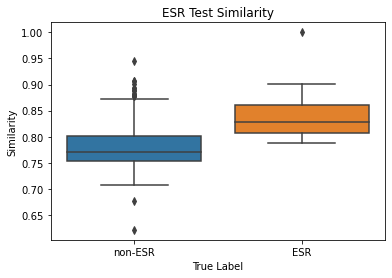

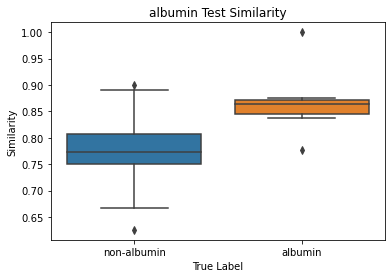

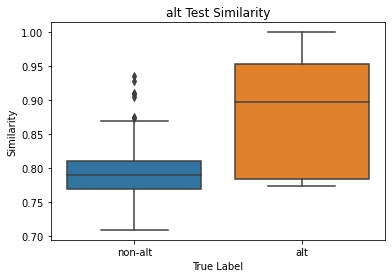

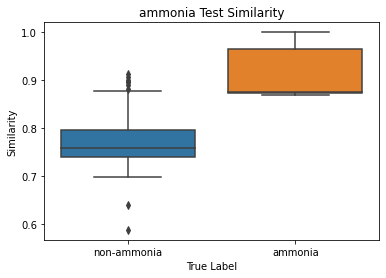

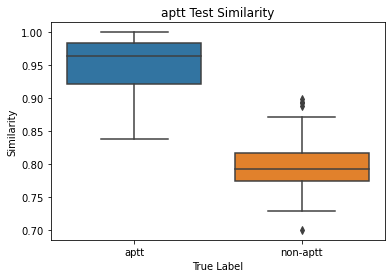

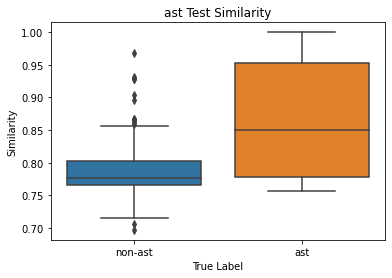

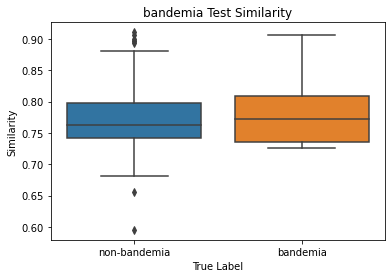

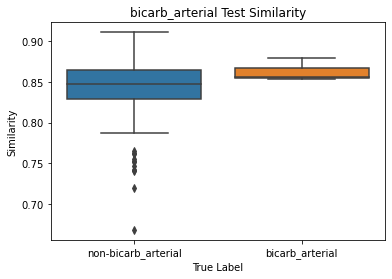

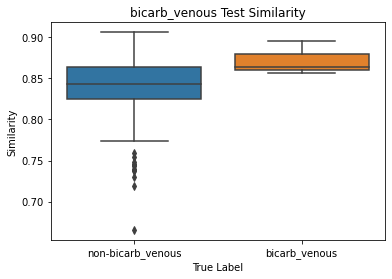

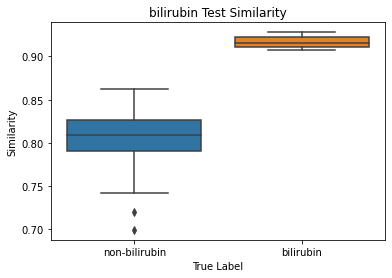

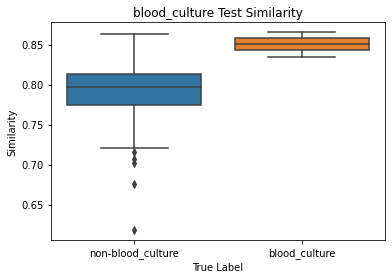

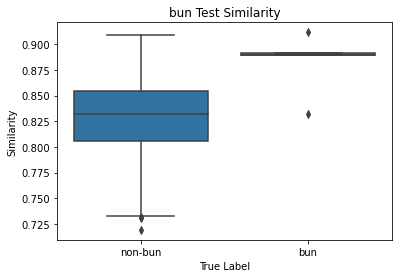

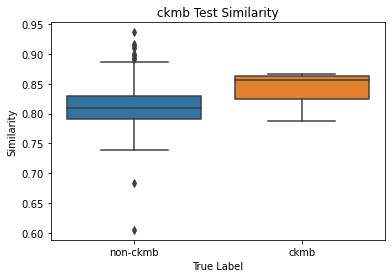

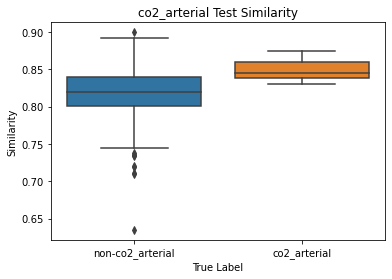

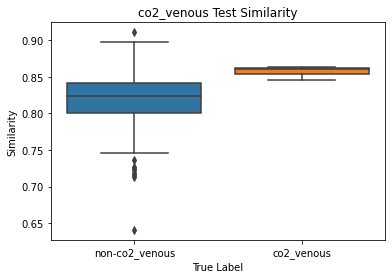

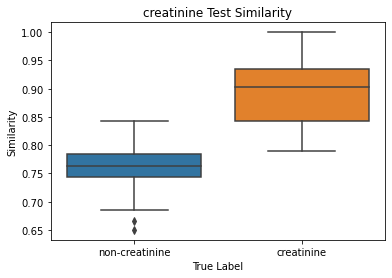

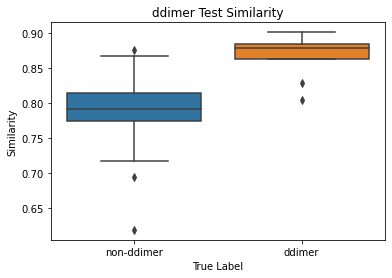

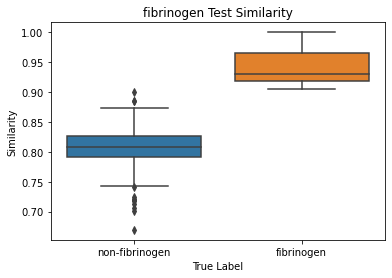

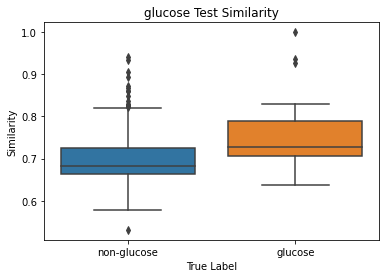

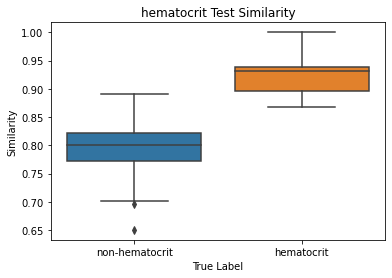

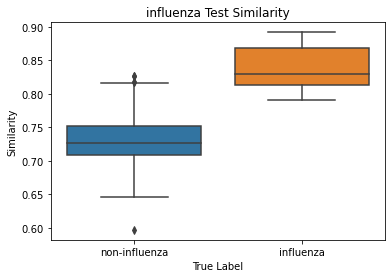

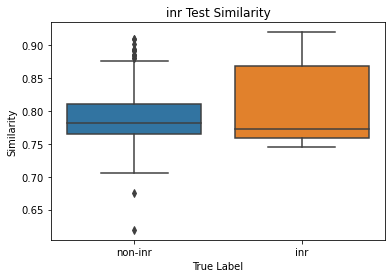

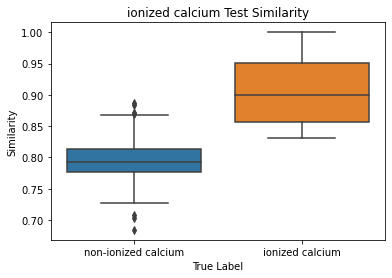

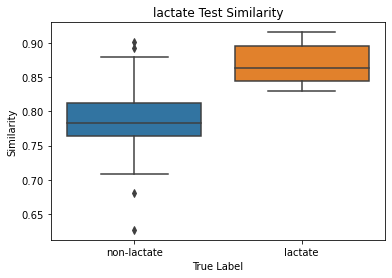

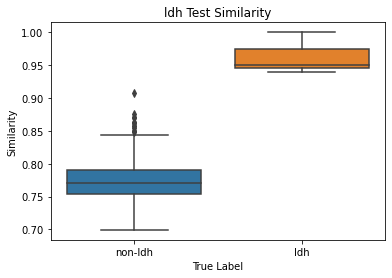

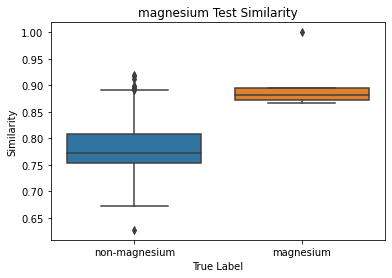

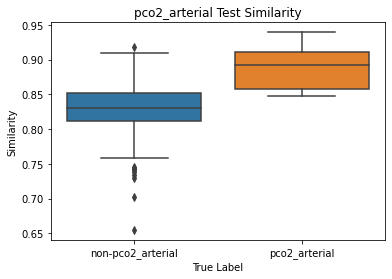

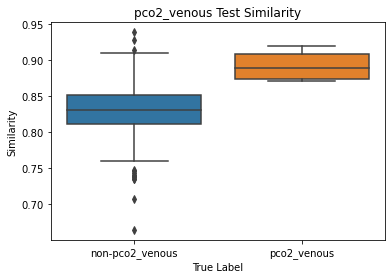

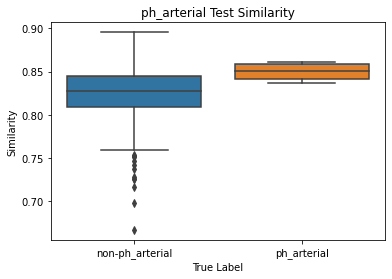

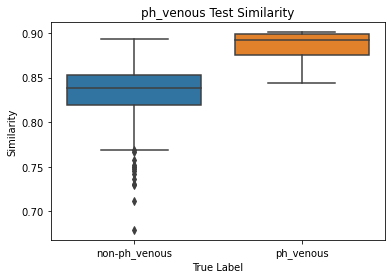

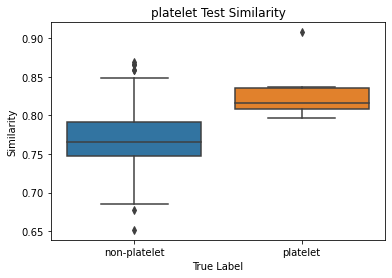

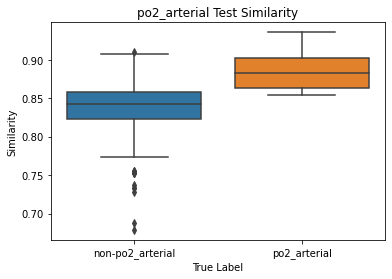

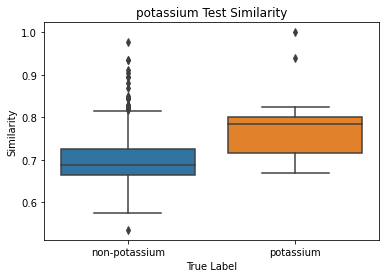

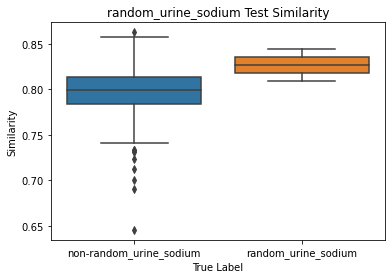

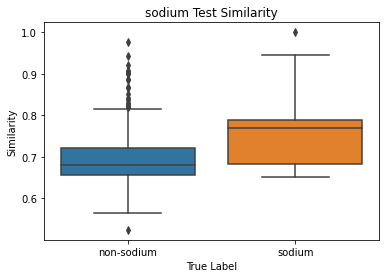

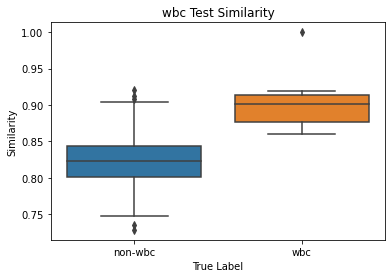

In [216]:
# Save all plots to local
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    
    plt.figure()
    sns.boxplot(x="label", y="max_sim", data=d1[grouper])
    plt.title('%s Test Similarity' % grouper)
    plt.xlabel('True Label')
    plt.ylabel('Similarity')
    #plt.show(block=False)
    plt.savefig('/Users/hollycui/Desktop/HDS/plots/boxplot_new/%s_boxplot_new.png'%grouper)

- ROC

 53%|█████▎    | 19/36 [00:01<00:01, 14.88it/s]<ipython-input-217-257adcc26ae8>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5), dpi=100)
100%|██████████| 36/36 [00:02<00:00, 14.76it/s]


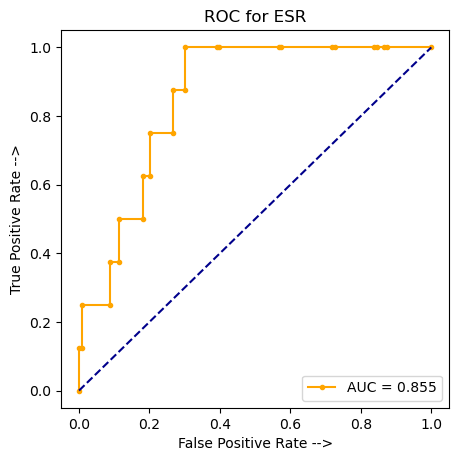

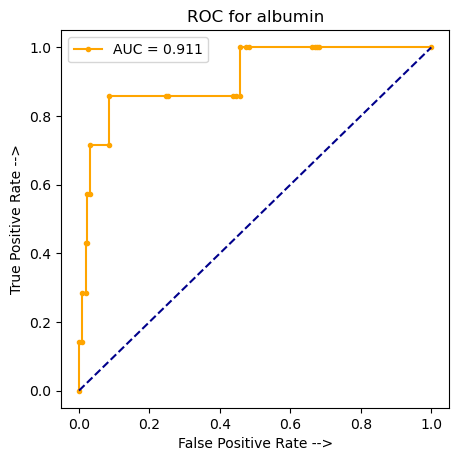

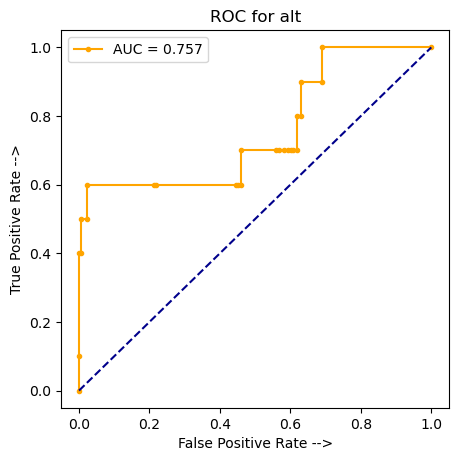

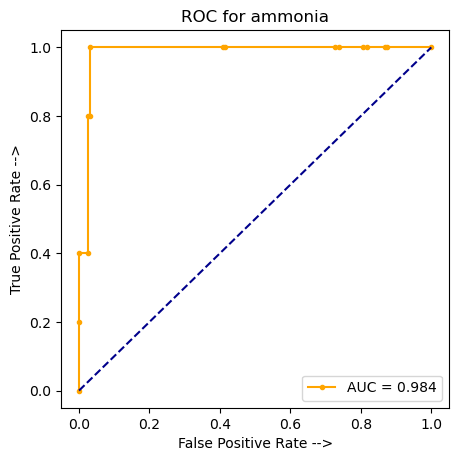

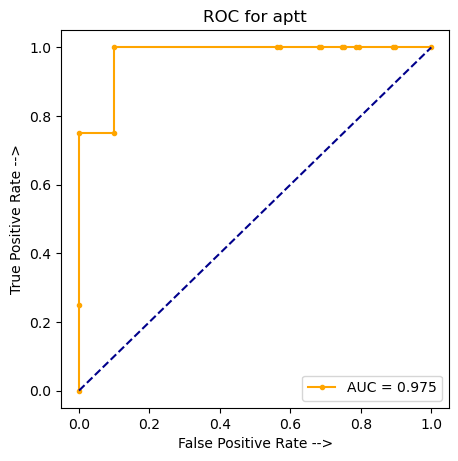

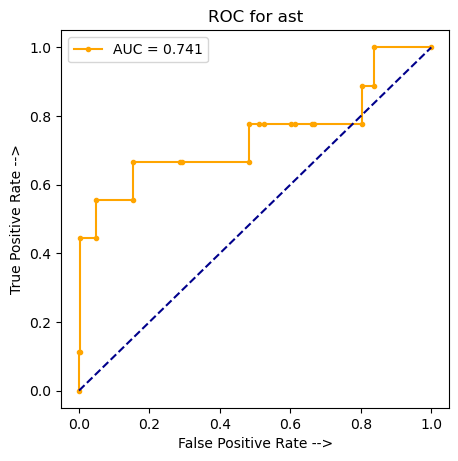

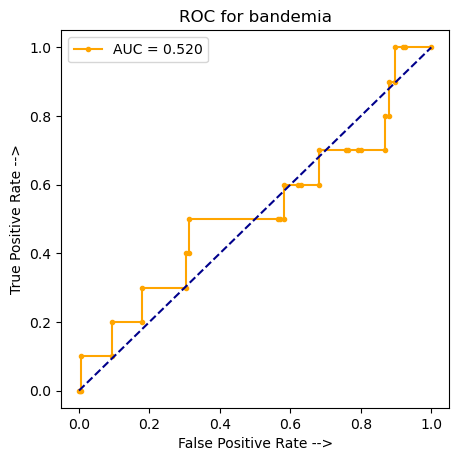

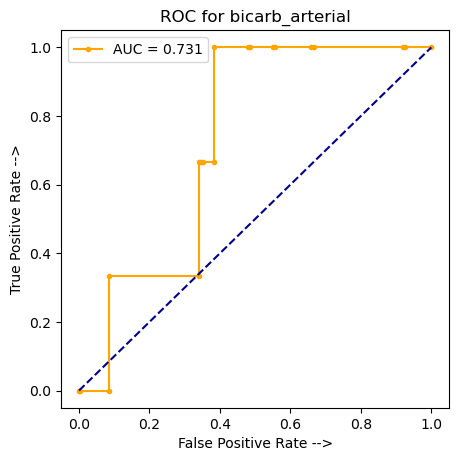

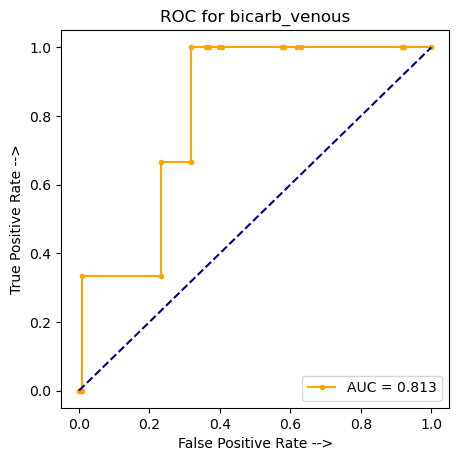

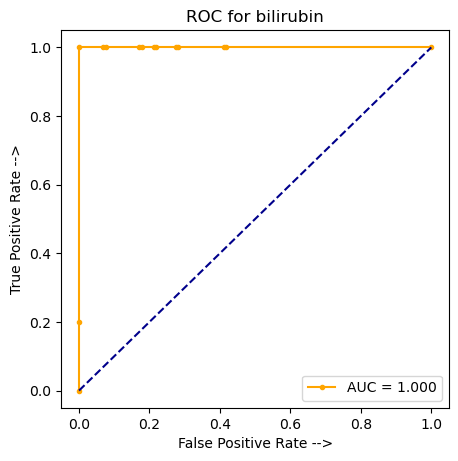

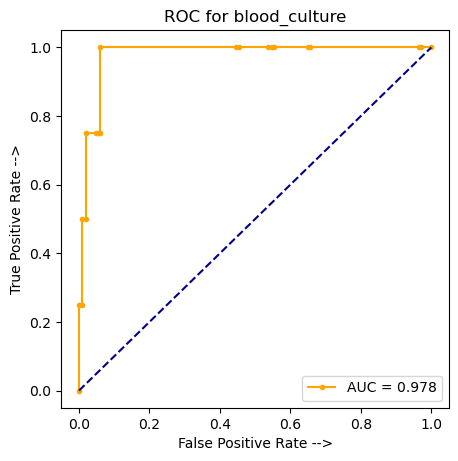

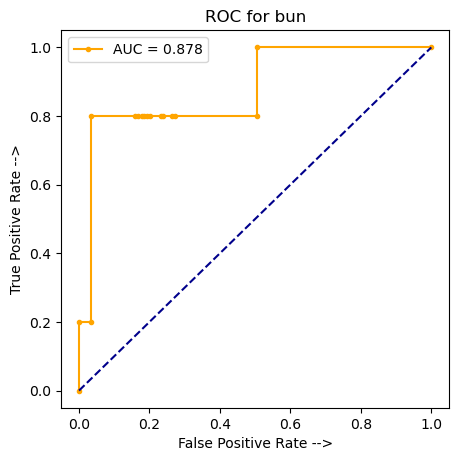

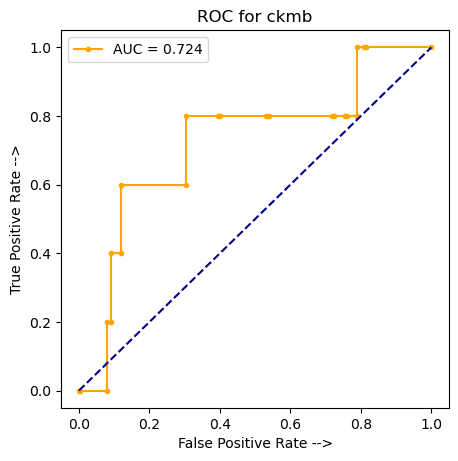

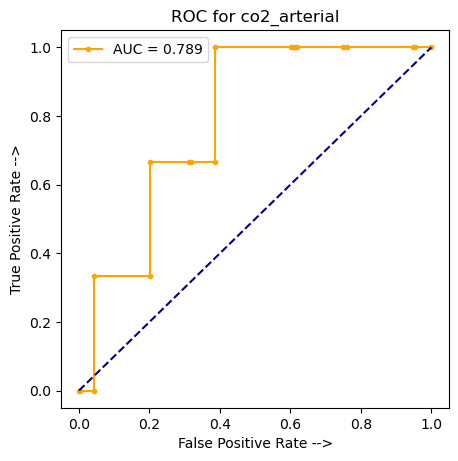

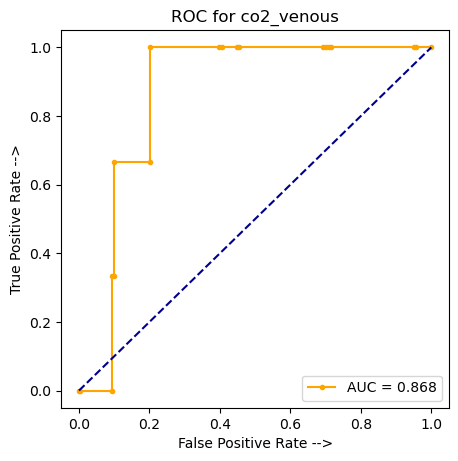

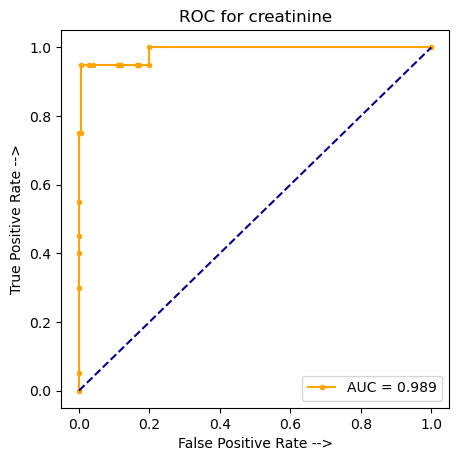

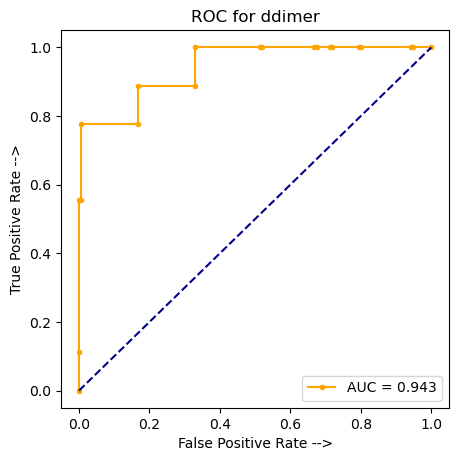

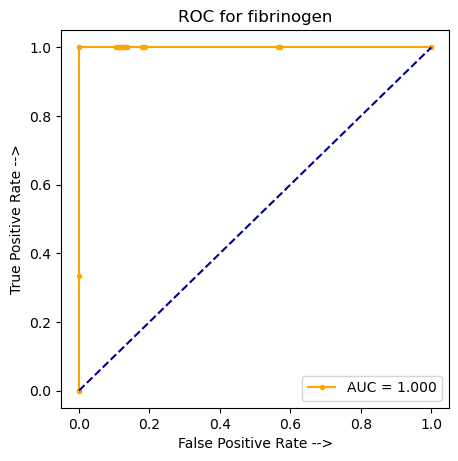

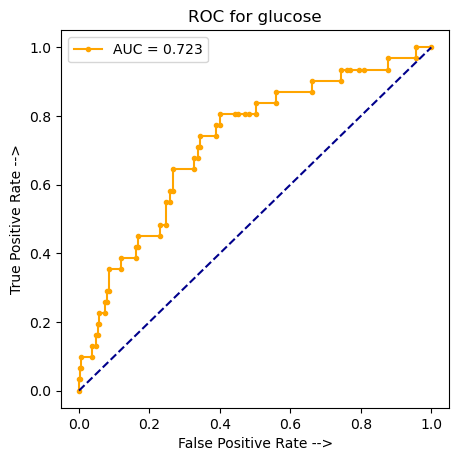

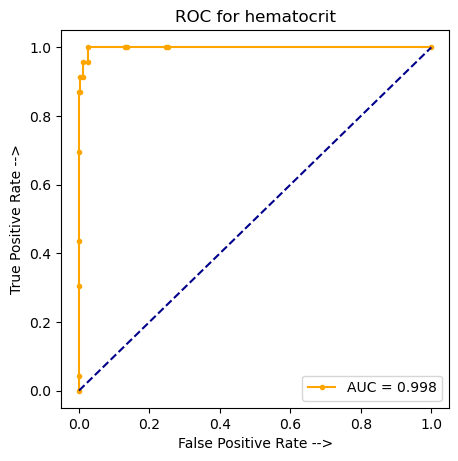

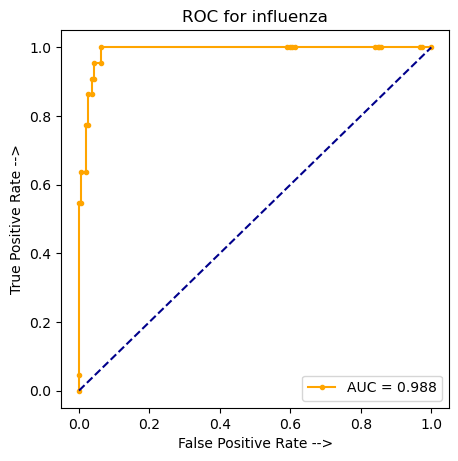

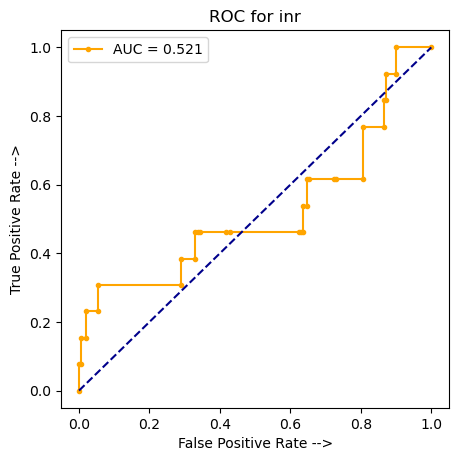

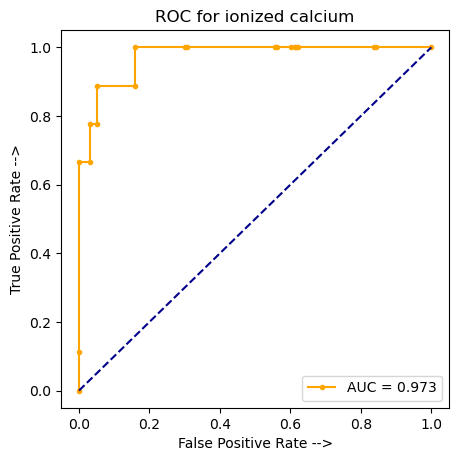

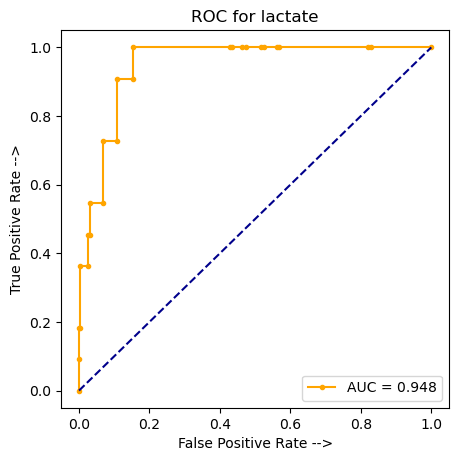

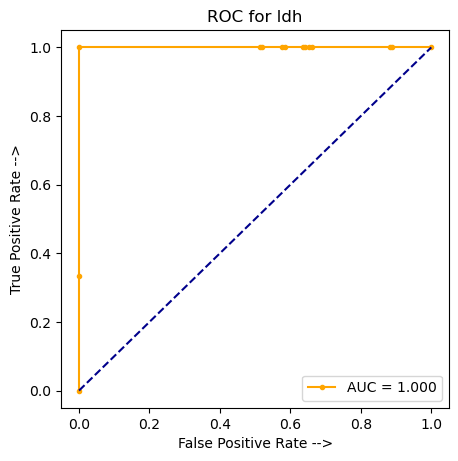

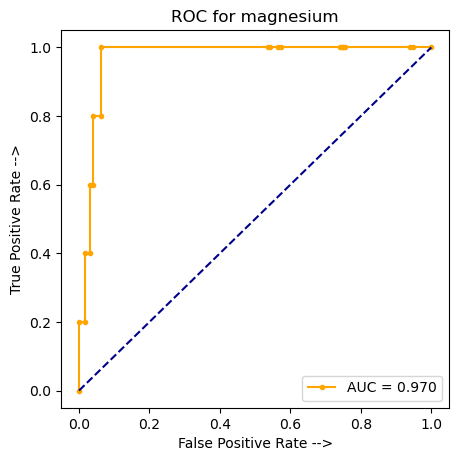

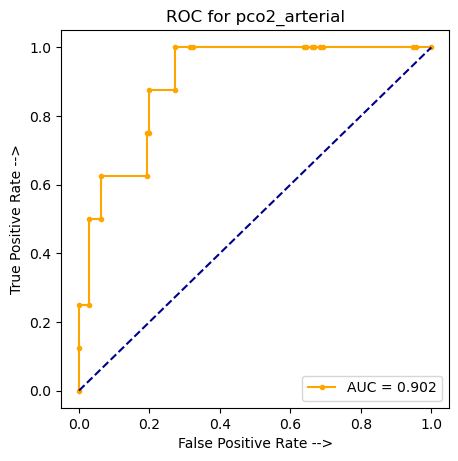

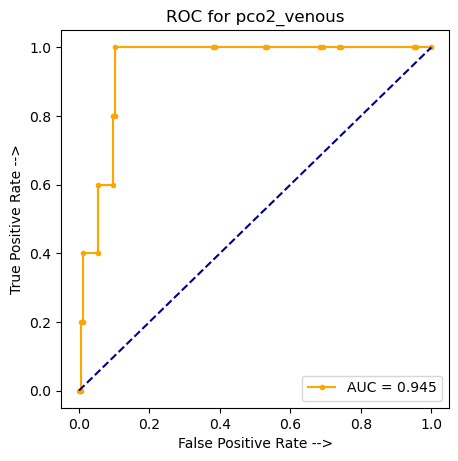

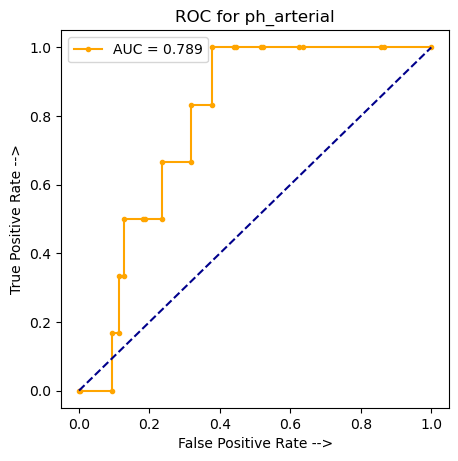

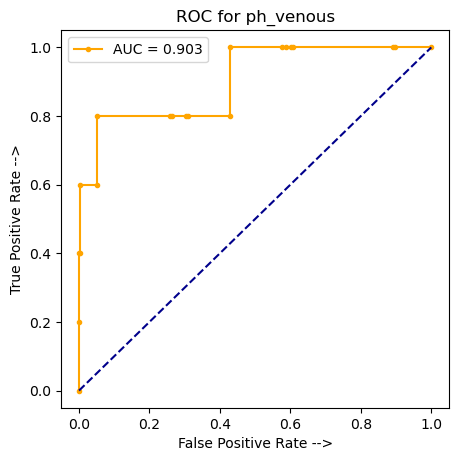

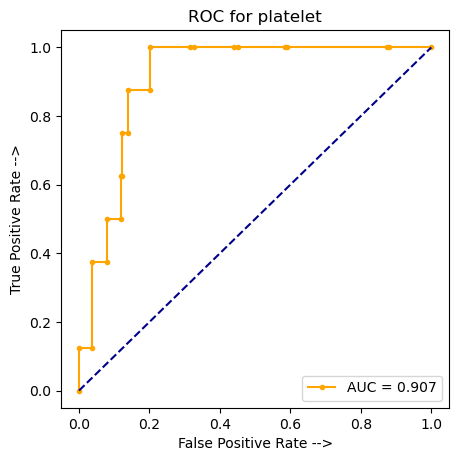

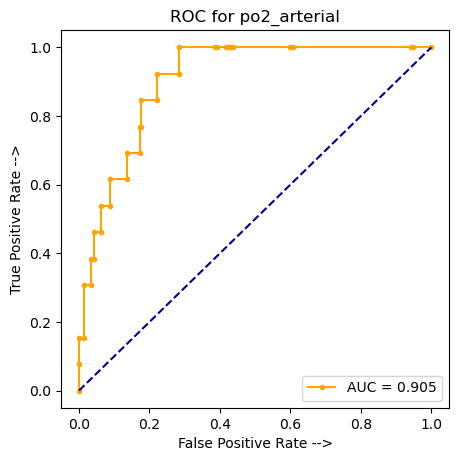

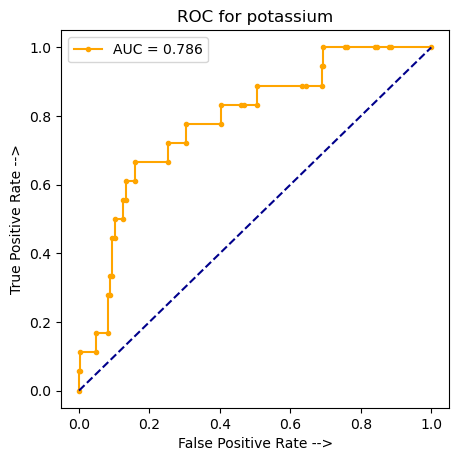

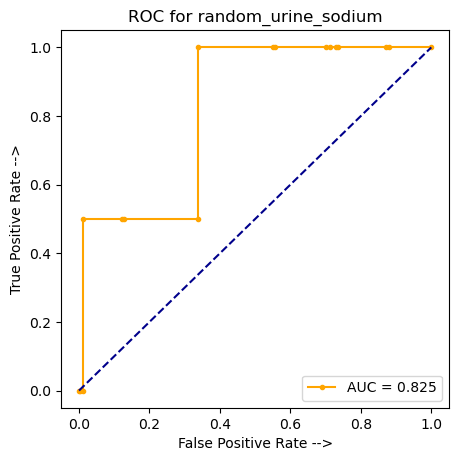

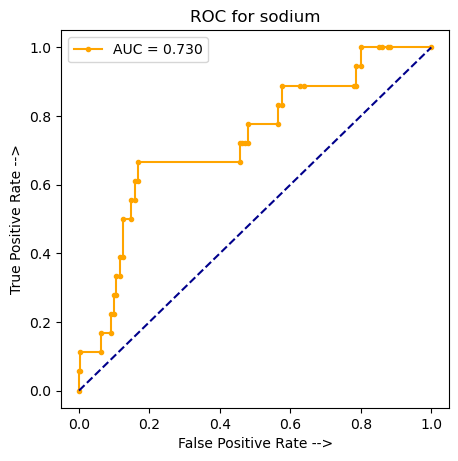

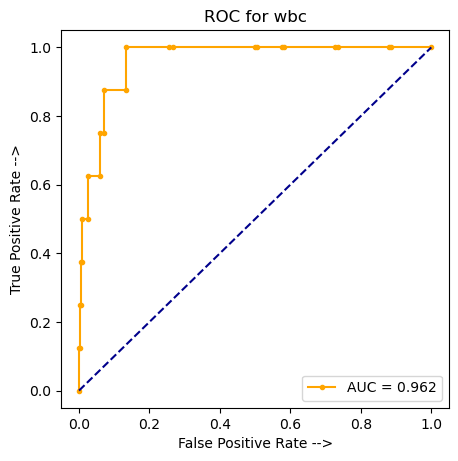

In [217]:
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_max[cross_max['paired_grouper'] == grouper].reset_index()
    
    fpr, tpr, _ = roc_curve(df['label_true'], df['max_sim'])
    auc = metrics.auc(fpr, tpr)

    # Plot 
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, marker='.', color='orange', label='AUC = %0.3f' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

    plt.title('ROC for %s' % grouper)
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()

    plt.savefig('/Users/hollycui/Desktop/HDS/plots/ROC_new/%s_roc_new.png'%grouper)

- Precision Recall Curve

 56%|█████▌    | 20/36 [00:01<00:01, 13.65it/s]<ipython-input-220-4ffbf6129ef8>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 36/36 [00:02<00:00, 17.82it/s]


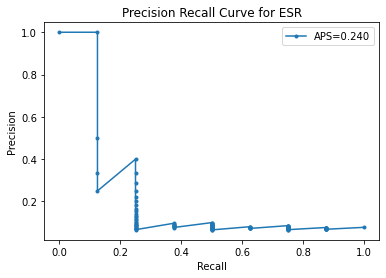

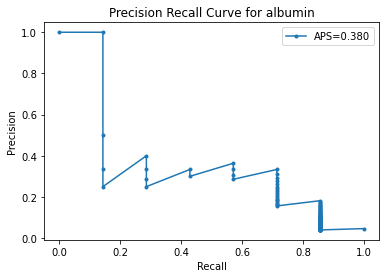

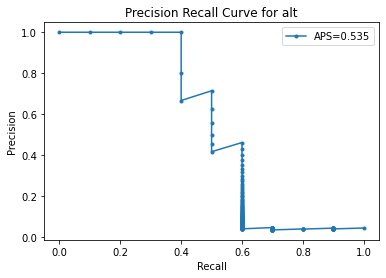

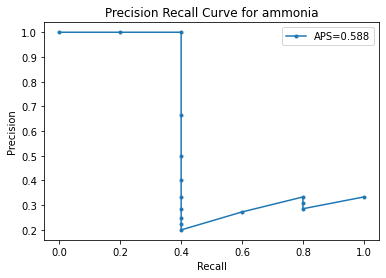

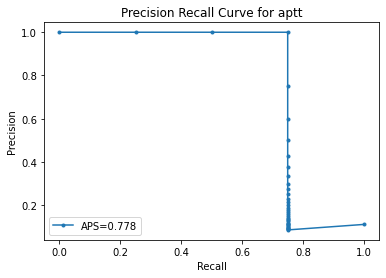

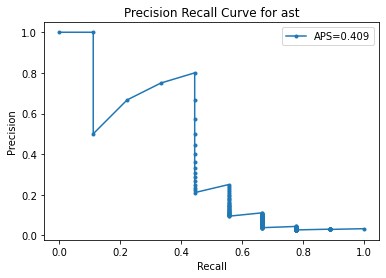

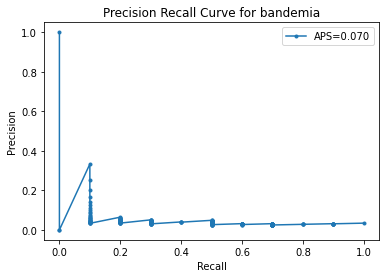

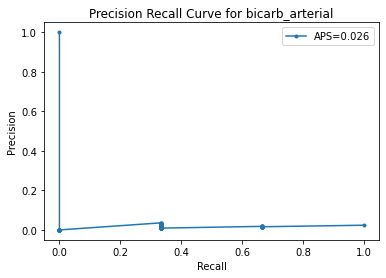

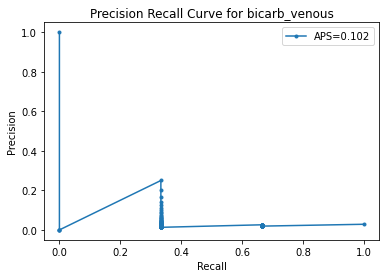

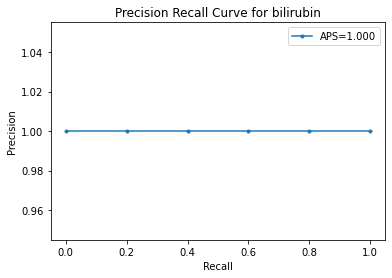

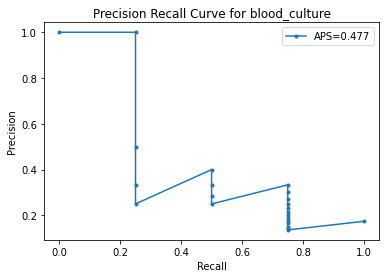

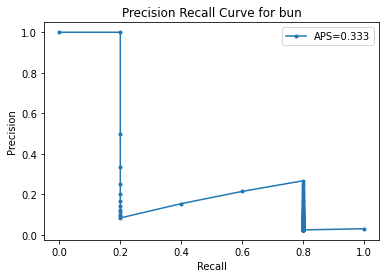

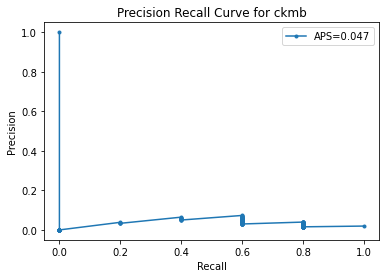

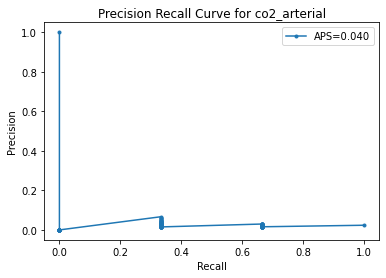

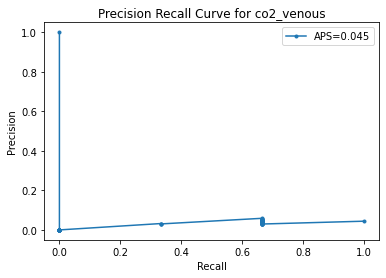

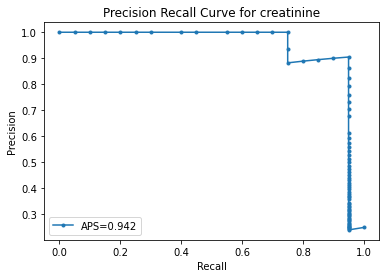

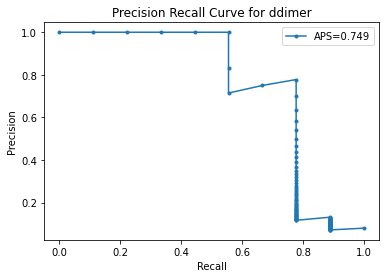

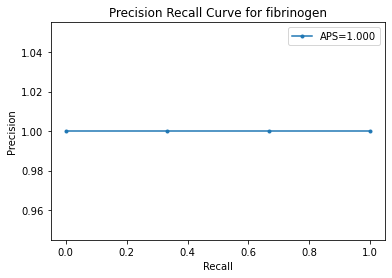

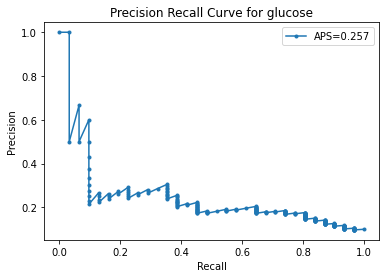

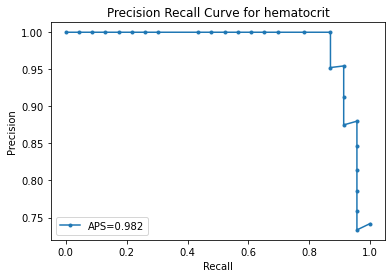

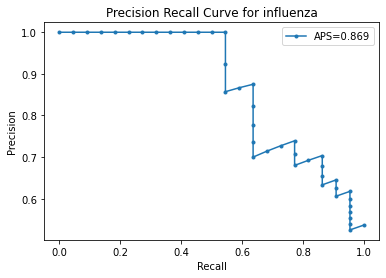

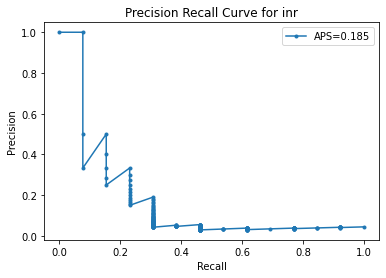

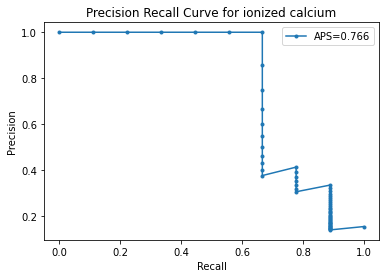

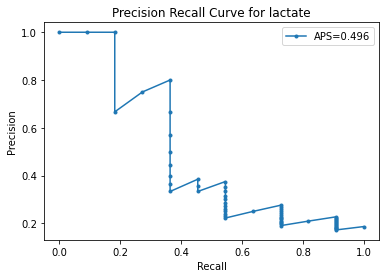

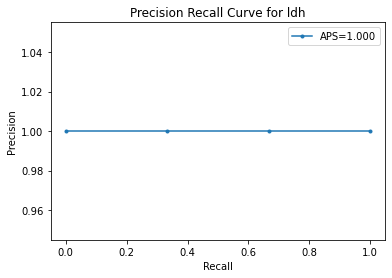

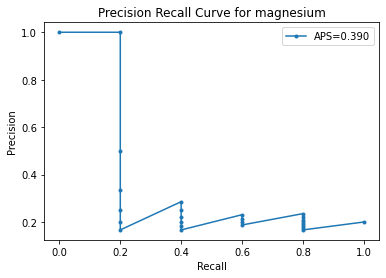

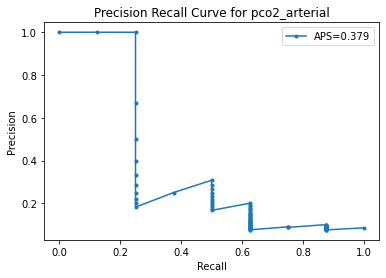

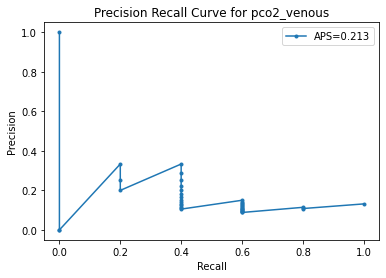

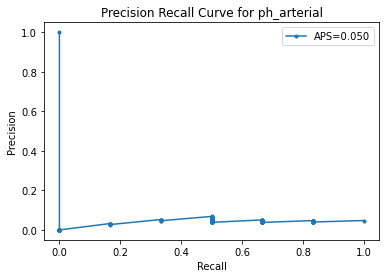

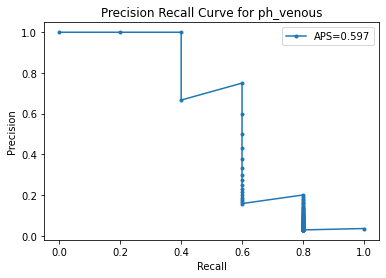

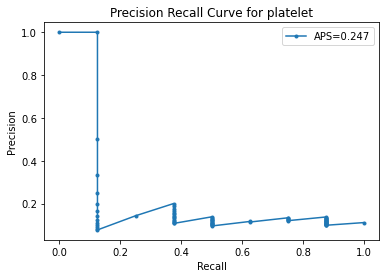

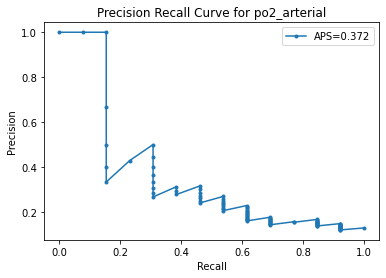

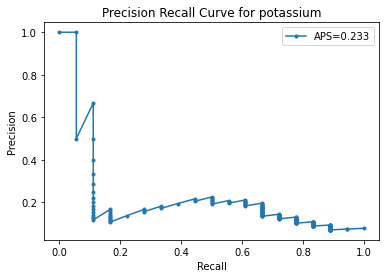

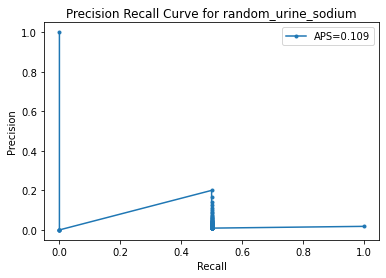

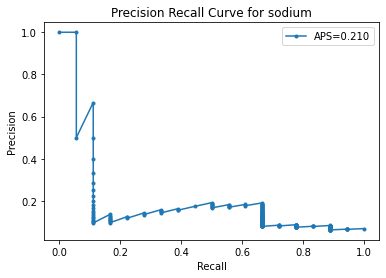

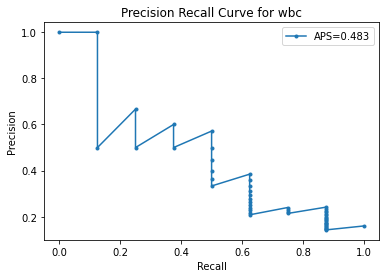

In [220]:
aps1 = {}

for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_max[cross_max['paired_grouper'] == grouper].reset_index()

    # Calculate Precision Recall
    precision, recall, __ = precision_recall_curve(df['label_true'], df['max_sim'])
    aps = average_precision_score(df['label_true'], df['max_sim'])
    aps1[grouper] = aps

    # plot the precision-recall curves
    plt.figure()
    plt.plot(recall, precision, marker='.', label='APS={:.3f}'.format(aps))
    # axis labels
    plt.title('Precision Recall Curve for %s' % grouper)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend()
    plt.savefig('/Users/hollycui/Desktop/HDS/plots/PRC_new/%s_prc_new.png' % grouper)

- Evaluation metrics

In [219]:
# Create AUC dictionary
auc1 = {}
for i in tqdm.tqdm(range(0, 36)):
    grouper = unique_groups['grouper_name'][i]
    df = cross_max[cross_max['paired_grouper'] == grouper].reset_index()
    
    fpr, tpr, _ = roc_curve(df['label_true'], df['max_sim'])
    auc_calc = metrics.auc(fpr, tpr)
    
    auc1[grouper] = auc_calc
auc1_df = pd.DataFrame(list(auc1.items()), columns = ['grouper', 'AUC'])

100%|██████████| 36/36 [00:00<00:00, 419.15it/s]


In [221]:
# APS dictionary
aps1_df = pd.DataFrame(list(aps1.items()), columns = ['grouper', 'APS'])

In [236]:
# Altogether
evaluation1 = pd.merge(auc1_df, aps1_df, on="grouper")
evaluation1.sort_values(by='AUC', ascending=False)

grouper       AUC       APS
17           fibrinogen  1.000000  1.000000
24                  ldh  1.000000  1.000000
9             bilirubin  1.000000  1.000000
19           hematocrit  0.998267  0.981586
15           creatinine  0.988816  0.941919
20            influenza  0.987809  0.868989
3               ammonia  0.983699  0.587879
10        blood_culture  0.978125  0.476812
4                  aptt  0.975000  0.777778
22      ionized calcium  0.973192  0.766404
25            magnesium  0.969906  0.390356
35                  wbc  0.961630  0.483011
23              lactate  0.948301  0.496227
27          pco2_venous  0.945455  0.212506
16               ddimer  0.943210  0.748730
1               albumin  0.910771  0.379739
30             platelet  0.907437  0.247346
31         po2_arterial  0.904526  0.371609
29            ph_venous  0.903448  0.597042
26        pco2_arterial  0.901899  0.379044
11                  bun  0.878370  0.332984
14           co2_venous  0.868120  0.045066
0                   ESR  0.854826  0.239716
33  random_urine_sodium  0.824534  0.109009
8         bicarb_venous  0.813084  0.101515
13         co2_arterial  0.789200  0.040046
28          ph_arterial  0.788784  0.049749
32            potassium  0.785585  0.233465
2                   alt  0.757325  0.534932
5                   ast  0.740741  0.409491
7       bicarb_arterial  0.731049  0.025847
34               sodium  0.729666  0.210110
12                 ckmb  0.723511  0.047042
18              glucose  0.722889  0.257343
21                  inr  0.520653  0.184877
6              bandemia  0.519745  0.069536

#### Plot evaluation

In [320]:
eval_order = evaluation1.sort_values(by='AUC', ascending=False)

In [340]:
# top 10
eval_top = eval_order.iloc[0:10, :]
eval_top_melt = pd.melt(eval_top, id_vars = "grouper")

In [357]:
# bottom 10
eval_bottom = eval_order.iloc[-10:, :]
eval_bottom_melt = pd.melt(eval_bottom, id_vars = "grouper")

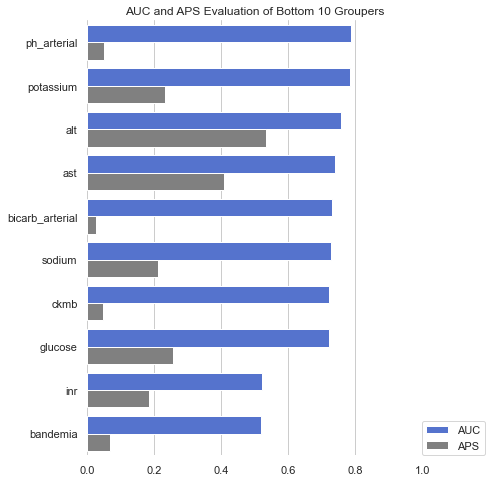

In [367]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Plot the total crashes
sns.barplot(x="value", y="grouper", hue="variable", data=eval_bottom_melt, palette=["royalblue", 'grey'], orient = 'h')

# Add a legend and informative axis label
ax.legend(ncol=1, loc = [1, 0], frameon=True)
ax.set(xlim=(0, 1), xlabel="", ylabel="")
plt.title('AUC and APS Evaluation of Bottom 10 Groupers')
sns.despine(left=True, bottom=True)

#plt.savefig('/Users/hollycui/Desktop/HDS/plots/eval_bar.png')

### Application: analyte_partial.csv

After exploring the grouper names on analyte_grouper dataset, we move on to test if our model works well given the results and relative insights.  

#### Read in analyte_partial.csv

In [229]:
analyte = pd.read_csv('/Users/hollycui/Desktop/HDS/analyte_partial.csv')

In [232]:
analyte = analyte.drop('Unnamed: 0', axis = 1)

In [237]:
analyte.head(10)

component_id                 common_name  \
0  c9fa2182-e393-42e8-9316-e401250e8165                 ATTESTATION   
1  e83ed120-d5fa-42fe-a21a-423f42df44d8       Statement of Adequacy   
2  2d553483-bc28-4fad-a452-392687b58f39           GROSS DESCRIPTION   
3  3a41fa2f-6ca0-416d-bc57-e29530527b52  CLINICAL INFORMATION (BKR)   
4  365d4e5c-1b75-42bd-9221-41405a839451                     Comment   
5  e29adc18-4086-4d36-a557-27dce8d864af                SP DIAGNOSIS   
6  5a33168d-7af8-4af4-92a7-e4aaa15f3ed4                SP DIAGNOSIS   
7  dea709d5-d917-4efa-9711-5aa7639c7dc6           Specimen Source A   
8  4491b275-85eb-4649-ae84-0a72f1538783                 Case Report   
9  da5118af-8ef4-45cf-99d1-b0d5ab6cacea               URINE CULTURE   

                                test_id                       test_label  \
0  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
1  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
2  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
3  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
4  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
5  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
6  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
7  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
8  4d2a0120-9d5d-4588-b9fc-3d356b585130  GENERAL CYTOLOGY SPECIMEN (RTF)   
9  c2452135-90e7-4942-bc79-17bace83e92d                   CULTURE, URINE   

                                proc_id                           proc_label  \
0  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
1  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
2  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
3  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
4  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
5  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
6  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
7  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
8  eb62e2f1-5fcf-44c2-b6d5-d90ffca5e100  CYTOLOGY, NON-GYN BODY CAVITY FLUID   
9  f652926c-d424-458f-899f-c84c7e82500d                       CULTURE, URINE   

                                     raw_name  raw_value raw_unit  
0                           ATTESTATION (BKR)        NaN      NaN  
1      NGYN STATEMENT OF ADEQUACY A     (BKR)  9999999.0      NaN  
2                 GROSS DESCRIPTION     (BKR)        NaN      NaN  
3                  CLINICAL INFORMATION (BKR)        NaN      NaN  
4                           COMMENT     (BKR)        NaN      NaN  
5                     NGYN FINDINGS A   (BKR)        NaN      NaN  
6  NGYN DIAGNOSTIC INTERPRETATION A     (BKR)  9999999.0      NaN  
7                 SPECIMEN SOURCE A     (BKR)        NaN      NaN  
8                       CASE REPORT     (BKR)        NaN      NaN  
9                     CULTURE URINE     (BKR)  9999999.0      NaN

#### Create groundtruth grouper dataset

In [242]:
gt_grouper = grouper_full_final.filter(["grouper_name", "full_grouper", "grouper_embeddings", "full_embeddings"], axis=1).groupby('grouper_name', as_index=False).first()

In [243]:
gt_grouper

grouper_name                     full_grouper  \
0                   ESR               sedimentation rate   
1               albumin                          albumin   
2                   alt         alanine aminotransferase   
3               ammonia                          ammonia   
4                  aptt  act partial thromboplastin time   
5                   ast       aspartate aminotransferase   
6              bandemia                         bandemia   
7       bicarb_arterial                  bicarb_arterial   
8         bicarb_venous                    bicarb_venous   
9             bilirubin                        bilirubin   
10        blood_culture                    blood_culture   
11                  bun              blood urea nitrogen   
12                 ckmb                             ckmb   
13         co2_arterial                     co2_arterial   
14           co2_venous                       co2_venous   
15           creatinine                       creatinine   
16               ddimer                           ddimer   
17           fibrinogen                       fibrinogen   
18              glucose                          glucose   
19           hematocrit                       hematocrit   
20            influenza                        influenza   
21                  inr     international ratio external   
22      ionized calcium                  ionized calcium   
23              lactate                          lactate   
24                  ldh            lactate dehydrogenase   
25            magnesium                        magnesium   
26        pco2_arterial                    pco2_arterial   
27          pco2_venous                      pco2_venous   
28          ph_arterial                      ph_arterial   
29            ph_venous                        ph_venous   
30             platelet                         platelet   
31         po2_arterial                     po2_arterial   
32            potassium                        potassium   
33  random_urine_sodium              random_urine_sodium   
34               sodium                           sodium   
35                  wbc           white blood cell count   

                                   grouper_embeddings  \
0   [0.29189637, -0.23742639, -0.043175455, -0.252...   
1   [0.08558647, -0.07638013, -0.037009418, -0.133...   
2   [0.25289917, -0.23679826, -0.15975142, -0.0516...   
3   [-0.09556136, -0.051205263, -0.23730528, -0.27...   
4   [0.25414523, -0.14685968, -0.24449036, 0.09410...   
5   [0.047332563, -0.15196654, -0.106446065, -0.27...   
6   [0.12614255, -0.16819745, -0.13873099, 0.04170...   
7   [0.16082264, -0.23231581, -0.09725845, -0.1322...   
8   [0.15299852, -0.1379596, -0.049962737, -0.2716...   
9   [0.22253877, -0.18823092, -0.38237095, -0.4486...   
10  [0.21799107, 0.1724962, -0.2885532, -0.2368791...   
11  [0.11418143, -0.20854041, -0.21565351, -0.1035...   
12  [0.4530353, -0.2501374, -0.18317306, -0.036244...   
13  [0.3078967, -0.01613462, -0.14595833, -0.02111...   
14  [0.30690655, 0.12501113, -0.13183399, -0.15615...   
15  [-0.15739588, -0.10941378, -0.12982352, -0.143...   
16  [0.25713816, -0.22373176, -0.17759661, -0.1549...   
17  [0.22476663, 0.07966434, 0.09630739, 0.0063262...   
18  [-0.089972615, -0.19694275, -0.10902107, -0.09...   
19  [-0.48798397, 0.0008097738, 0.10189275, -0.122...   
20  [0.24760243, -0.10928263, -0.18876526, -0.1582...   
21  [0.17117813, -0.26785767, 0.09433715, -0.20816...   
22  [-0.06563672, 0.04152087, 0.11051383, -0.22278...   
23  [-0.16952984, -0.023161221, -0.16579512, -0.31...   
24  [0.25777736, -0.26665664, -0.42358506, -0.2451...   
25  [-0.011376977, -0.16976504, 0.1623523, -0.0285...   
26  [0.39695066, 0.039283916, -0.11920294, -0.0511...   
27  [0.3407097, 0.16888362, -0.13748196, -0.203135...   
28  [0.12989378, -0.11178509, -0.07304925, -0.1606...   
29  [0.11598652, -0.033015985, -0.01523384, -0.282...   
30  [0.2619082, -0.1153

#### Create embeddings & Assign grouper label with max similarity

In [252]:
analyte_raw = analyte.groupby("raw_name", as_index=False).first()
a_unique_raw = analyte_raw["raw_name"]

In [260]:
a_raw = []
a_grouper_name = []
a_full_grouper = []

a_raw_embeddings = []
a_grouper_embeddings = []
a_full_embeddings = []

a_sim = []

for i in tqdm.tqdm(range(a_unique_raw.shape[0])):
    
    # retrieve names in each row
    raw_name = a_unique_raw[i]
    
    # create raw_embeddings
    raw_token = tokenizer.encode(raw_name, add_special_tokens=True)
    raw_embedding = torch.tensor([raw_token])
    with torch.no_grad():
        last_hidden_states_raw = model(raw_embedding)[0]
    last_hidden_states_raw_ = last_hidden_states_raw.mean(1)
    raw_final = last_hidden_states_raw_[0].detach().numpy()
    
    # create a list holding all similarity for a single raw compared to all groupers
    row_max_sim = []
    
    for j in tqdm.tqdm(range(gt_grouper.shape[0])):
        
        grouper_embeddings = gt_grouper["grouper_embeddings"][j]
        full_embeddings = gt_grouper["full_embeddings"][j]
        
        # calculate similarity
        gouper_similarity = 1 - cosine(raw_final, grouper_embeddings)
        full_similarity = 1 - cosine(raw_final, full_embeddings)
        max_similarity = max(gouper_similarity, full_similarity)
        
        row_max_sim.append(max_similarity)
    
    # keep only the highest similarity
    max_sim_ind = np.argmax(row_max_sim)
  
    # add all useful info to new lists for new columns creation
    a_raw.append(raw_name)
    a_grouper_name.append(gt_grouper["grouper_name"][max_sim_ind])
    a_full_grouper.append(gt_grouper["full_grouper"][max_sim_ind])
        
    a_raw_embeddings.append(raw_final)
    a_grouper_embeddings.append(gt_grouper["grouper_embeddings"][max_sim_ind])
    a_full_embeddings.append(gt_grouper["full_embeddings"][max_sim_ind])
        
    a_sim.append(row_max_sim[max_sim_ind])

100%|██████████| 36/36 [00:00<00:00, 9180.70it/s]

100%|██████████| 36/36 [00:00<00:00, 9500.72it/s]

100%|██████████| 36/36 [00:00<00:00, 9300.01it/s]

100%|██████████| 36/36 [00:00<00:00, 8458.63it/s]

100%|██████████| 36/36 [00:00<00:00, 9724.67it/s]

100%|██████████| 36/36 [00:00<00:00, 9535.52it/s]

100%|██████████| 36/36 [00:00<00:00, 9165.10it/s]

100%|██████████| 36/36 [00:00<00:00, 8714.43it/s]

100%|██████████| 36/36 [00:00<00:00, 9273.73it/s]

100%|██████████| 36/36 [00:00<00:00, 9743.50it/s]

100%|██████████| 36/36 [00:00<00:00, 9118.60it/s]

100%|██████████| 36/36 [00:00<00:00, 9446.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9309.18it/s]

100%|██████████| 36/36 [00:00<00:00, 9247.61it/s]

100%|██████████| 36/36 [00:00<00:00, 10095.94it/s]

100%|██████████| 36/36 [00:00<00:00, 9513.89it/s]

100%|██████████| 36/36 [00:00<00:00, 9418.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9278.29it/s]

  4%|▍         | 171/4263 [00:24<11:41,  5.83it/s]


100%|██████████| 36/36 [00:00<00:00, 8626.80it/s]

100%|██████████| 36/36 [00:00<00:00, 8050.06it/s]

100%|██████████| 36/36 [00:00<00:00, 9045.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9612.61it/s]

100%|██████████| 36/36 [00:00<00:00, 9040.53it/s]

100%|██████████| 36/36 [00:00<00:00, 8115.39it/s]

100%|██████████| 36/36 [00:00<00:00, 7644.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9247.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9254.98it/s]

100%|██████████| 36/36 [00:00<00:00, 8446.80it/s]

100%|██████████| 36/36 [00:00<00:00, 8778.27it/s]

100%|██████████| 36/36 [00:00<00:00, 9724.67it/s]

100%|██████████| 36/36 [00:00<00:00, 9596.73it/s]

100%|██████████| 36/36 [00:00<00:00, 9495.94it/s]

100%|██████████| 36/36 [00:00<00:00, 9343.17it/s]

100%|██████████| 36/36 [00:00<00:00, 8814.13it/s]

100%|██████████| 36/36 [00:00<00:00, 8215.62it/s]

100%|██████████| 36/36 [00:00<00:00, 9843.86it/s]

100%|██████████| 36/36 [00:00<00:00, 8869.53it/s]

100%|██████████| 36/36 [00:00<0

100%|██████████| 36/36 [00:00<00:00, 9687.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9541.54it/s]

100%|██████████| 36/36 [00:00<00:00, 9456.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9481.03it/s]

100%|██████████| 36/36 [00:00<00:00, 9282.86it/s]

100%|██████████| 36/36 [00:00<00:00, 6415.76it/s]

100%|██████████| 36/36 [00:00<00:00, 9362.87it/s]

100%|██████████| 36/36 [00:00<00:00, 8880.49it/s]

100%|██████████| 36/36 [00:00<00:00, 8959.00it/s]

100%|██████████| 36/36 [00:00<00:00, 8295.06it/s]

100%|██████████| 36/36 [00:00<00:00, 9000.12it/s]

100%|██████████| 36/36 [00:00<00:00, 8973.37it/s]

100%|██████████| 36/36 [00:00<00:00, 7324.52it/s]

100%|██████████| 36/36 [00:00<00:00, 9323.55it/s]

100%|██████████| 36/36 [00:00<00:00, 9204.76it/s]

100%|██████████| 36/36 [00:00<00:00, 9333.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9045.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9190.76it/s]

100%|██████████| 36/36 [00:00<00:00, 9264.06it/s]

100%|██████████| 36/36 [00:00<0

100%|██████████| 36/36 [00:00<00:00, 9216.56it/s]

100%|██████████| 36/36 [00:00<00:00, 9887.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9000.12it/s]

100%|██████████| 36/36 [00:00<00:00, 9626.10it/s]

100%|██████████| 36/36 [00:00<00:00, 9417.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9158.42it/s]

100%|██████████| 36/36 [00:00<00:00, 9162.31it/s]

100%|██████████| 36/36 [00:00<00:00, 8337.66it/s]

100%|██████████| 36/36 [00:00<00:00, 8993.15it/s]

100%|██████████| 36/36 [00:00<00:00, 10152.29it/s]

100%|██████████| 36/36 [00:00<00:00, 9317.22it/s]

100%|██████████| 36/36 [00:00<00:00, 9404.27it/s]

100%|██████████| 36/36 [00:00<00:00, 10308.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9240.82it/s]

100%|██████████| 36/36 [00:00<00:00, 8736.11it/s]

100%|██████████| 36/36 [00:00<00:00, 10170.06it/s]



100%|██████████| 36/36 [00:00<00:00, 8540.92it/s]

100%|██████████| 36/36 [00:00<00:00, 9838.73it/s]

100%|██████████| 36/36 [00:00<00:00, 9562.09it/s]

100%|██████████| 36/36 [00:00<00:00, 8904.05it/s]

100%|██████████| 36/36 [00:00<00:00, 9753.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9223.88it/s]

100%|██████████| 36/36 [00:00<00:00, 9407.20it/s]

100%|██████████| 36/36 [00:00<00:00, 9424.23it/s]

100%|██████████| 36/36 [00:00<00:00, 8093.64it/s]

100%|██████████| 36/36 [00:00<00:00, 9703.42it/s]

100%|██████████| 36/36 [00:00<00:00, 9416.59it/s]

100%|██████████| 36/36 [00:00<00:00, 10024.89it/s]

100%|██████████| 36/36 [00:00<00:00, 9634.08it/s]

100%|██████████| 36/36 [00:00<00:00, 9543.35it/s]

100%|██████████| 36/36 [00:00<00:00, 9448.40it/s]

100%|██████████| 36/36 [00:00<00:00, 9369.84it/s]

100%|██████████| 36/36 [00:00<00:00, 2676.17it/s]

100%|██████████| 36/36 [00:00<00:00, 8798.21it/s]

100%|██████████| 36/36 [00:00<00:00, 10376.95it/s]

100%|██████████| 36/36 [00:00

100%|██████████| 36/36 [00:00<00:00, 7672.51it/s]

100%|██████████| 36/36 [00:00<00:00, 9453.73it/s]

100%|██████████| 36/36 [00:00<00:00, 10344.24it/s]

100%|██████████| 36/36 [00:00<00:00, 10194.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9111.45it/s]

100%|██████████| 36/36 [00:00<00:00, 9202.52it/s]

100%|██████████| 36/36 [00:00<00:00, 8853.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9989.08it/s]

100%|██████████| 36/36 [00:00<00:00, 9002.26it/s]

100%|██████████| 36/36 [00:00<00:00, 9198.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9127.42it/s]

100%|██████████| 36/36 [00:00<00:00, 9318.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9406.61it/s]

100%|██████████| 36/36 [00:00<00:00, 8853.41it/s]

100%|██████████| 36/36 [00:00<00:00, 9799.14it/s]

100%|██████████| 36/36 [00:00<00:00, 9692.83it/s]

100%|██████████| 36/36 [00:00<00:00, 9466.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9157.87it/s]

100%|██████████| 36/36 [00:00<00:00, 10315.27it/s]

100%|██████████| 36/36 [00:0

100%|██████████| 36/36 [00:00<00:00, 9230.65it/s]

100%|██████████| 36/36 [00:00<00:00, 9587.59it/s]

100%|██████████| 36/36 [00:00<00:00, 8997.43it/s]

100%|██████████| 36/36 [00:00<00:00, 9584.55it/s]

100%|██████████| 36/36 [00:00<00:00, 8820.83it/s]

100%|██████████| 36/36 [00:00<00:00, 8888.85it/s]

100%|██████████| 36/36 [00:00<00:00, 9066.04it/s]

100%|██████████| 36/36 [00:00<00:00, 8973.37it/s]

100%|██████████| 36/36 [00:00<00:00, 9470.92it/s]

100%|██████████| 36/36 [00:00<00:00, 9434.24it/s]

100%|██████████| 36/36 [00:00<00:00, 9171.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9820.17it/s]

100%|██████████| 36/36 [00:00<00:00, 8971.24it/s]

100%|██████████| 36/36 [00:00<00:00, 9311.48it/s]

100%|██████████| 36/36 [00:00<00:00, 9525.89it/s]

100%|██████████| 36/36 [00:00<00:00, 9949.59it/s]

100%|██████████| 36/36 [00:00<00:00, 9494.15it/s]

100%|██████████| 36/36 [00:00<00:00, 10241.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9870.89it/s]

100%|██████████| 36/36 [00:00<

100%|██████████| 36/36 [00:00<00:00, 9377.40it/s]

100%|██████████| 36/36 [00:00<00:00, 9129.63it/s]

100%|██████████| 36/36 [00:00<00:00, 9237.99it/s]

100%|██████████| 36/36 [00:00<00:00, 9433.65it/s]

100%|██████████| 36/36 [00:00<00:00, 9338.55it/s]

100%|██████████| 36/36 [00:00<00:00, 9664.29it/s]

100%|██████████| 36/36 [00:00<00:00, 8637.17it/s]

100%|██████████| 36/36 [00:00<00:00, 10404.83it/s]

100%|██████████| 36/36 [00:00<00:00, 9554.22it/s]

100%|██████████| 36/36 [00:00<00:00, 9964.03it/s]

100%|██████████| 36/36 [00:00<00:00, 9491.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9526.49it/s]

100%|██████████| 36/36 [00:00<00:00, 8758.92it/s]

100%|██████████| 36/36 [00:00<00:00, 10365.55it/s]

100%|██████████| 36/36 [00:00<00:00, 8035.92it/s]

100%|██████████| 36/36 [00:00<00:00, 9237.99it/s]

100%|██████████| 36/36 [00:00<00:00, 9035.66it/s]

100%|██████████| 36/36 [00:00<00:00, 9318.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9520.49it/s]

100%|██████████| 36/36 [00:00

100%|██████████| 36/36 [00:00<00:00, 9582.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9457.87it/s]

100%|██████████| 36/36 [00:00<00:00, 9299.44it/s]

100%|██████████| 36/36 [00:00<00:00, 9698.44it/s]

100%|██████████| 36/36 [00:00<00:00, 9289.71it/s]

100%|██████████| 36/36 [00:00<00:00, 8612.53it/s]

100%|██████████| 36/36 [00:00<00:00, 9909.11it/s]

100%|██████████| 36/36 [00:00<00:00, 8963.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9724.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9160.09it/s]

100%|██████████| 36/36 [00:00<00:00, 10081.12it/s]

100%|██████████| 36/36 [00:00<00:00, 9498.33it/s]

100%|██████████| 36/36 [00:00<00:00, 9102.66it/s]

100%|██████████| 36/36 [00:00<00:00, 9076.94it/s]

100%|██████████| 36/36 [00:00<00:00, 8986.72it/s]

100%|██████████| 36/36 [00:00<00:00, 9020.01it/s]

100%|██████████| 36/36 [00:00<00:00, 9075.31it/s]

100%|██████████| 36/36 [00:00<00:00, 9703.42it/s]

100%|██████████| 36/36 [00:00<00:00, 8858.61it/s]

100%|██████████| 36/36 [00:00<

100%|██████████| 36/36 [00:00<00:00, 10112.85it/s]

100%|██████████| 36/36 [00:00<00:00, 9753.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9509.10it/s]

100%|██████████| 36/36 [00:00<00:00, 8500.53it/s]

100%|██████████| 36/36 [00:00<00:00, 10159.12it/s]

100%|██████████| 36/36 [00:00<00:00, 9146.77it/s]

100%|██████████| 36/36 [00:00<00:00, 6890.97it/s]

100%|██████████| 36/36 [00:00<00:00, 6268.73it/s]

100%|██████████| 36/36 [00:00<00:00, 8166.74it/s]

100%|██████████| 36/36 [00:00<00:00, 7782.44it/s]

100%|██████████| 36/36 [00:00<00:00, 4663.79it/s]

100%|██████████| 36/36 [00:00<00:00, 8928.80it/s]

100%|██████████| 36/36 [00:00<00:00, 9337.97it/s]

100%|██████████| 36/36 [00:00<00:00, 9142.34it/s]

 39%|███▉      | 1665/4263 [03:22<05:35,  7.74it/s]


100%|██████████| 36/36 [00:00<00:00, 8879.97it/s]

100%|██████████| 36/36 [00:00<00:00, 9244.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9318.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9336.24it/s]

100%|██████████| 36/36 [00:00<00:00, 9209.25it/s]

100%|██████████| 36/36 [00:00<00:00, 9494.15it/s]

100%|██████████| 36/36 [00:00<00:00, 9107.60it/s]

100%|██████████| 36/36 [00:00<00:00, 10000.33it/s]

100%|██████████| 36/36 [00:00<00:00, 9801.05it/s]

100%|██████████| 36/36 [00:00<00:00, 9711.53it/s]

100%|██████████| 36/36 [00:00<00:00, 9533.71it/s]

100%|██████████| 36/36 [00:00<00:00, 9653.79it/s]

100%|██████████| 36/36 [00:00<00:00, 8785.42it/s]

100%|██████████| 36/36 [00:00<00:00, 10172.80it/s]

100%|██████████| 36/36 [00:00<00:00, 9876.70it/s]

100%|██████████| 36/36 [00:00<00:00, 9551.20it/s]

100%|██████████| 36/36 [00:00<00:00, 9081.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9909.11it/s]

100%|██████████| 36/36 [00:00<00:00, 8324.33it/s]

100%|██████████| 36/36 [00:00

100%|██████████| 36/36 [00:00<00:00, 9202.52it/s]

100%|██████████| 36/36 [00:00<00:00, 9223.32it/s]

100%|██████████| 36/36 [00:00<00:00, 9086.78it/s]


100%|██████████| 36/36 [00:00<00:00, 9063.32it/s]

100%|██████████| 36/36 [00:00<00:00, 9503.71it/s]

100%|██████████| 36/36 [00:00<00:00, 8834.25it/s]

100%|██████████| 36/36 [00:00<00:00, 8516.83it/s]

100%|██████████| 36/36 [00:00<00:00, 9091.15it/s]

100%|██████████| 36/36 [00:00<00:00, 9331.62it/s]

100%|██████████| 36/36 [00:00<00:00, 8639.64it/s]

100%|██████████| 36/36 [00:00<00:00, 9871.53it/s]

100%|██████████| 36/36 [00:00<00:00, 9095.53it/s]

 51%|█████     | 2160/4263 [04:24<04:25,  7.91it/s]


100%|██████████| 36/36 [00:00<00:00, 9672.34it/s]

100%|██████████| 36/36 [00:00<00:00, 10647.69it/s]


100%|██████████| 36/36 [00:00<00:00, 9369.84it/s]

100%|██████████| 36/36 [00:00<00:00, 8552.53it/s]

100%|██████████| 36/36 [00:00<00:00, 8637.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9288.00it/s]

100%|██████████| 36/36 [00:00<00:00, 8641.62it/s]

100%|██████████| 36/36 [00:00<00:00, 9063.32it/s]

100%|██████████| 36/36 [00:00<00:00, 9244.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9551.20it/s]

100%|██████████| 36/36 [00:00<00:00, 8208.03it/s]

100%|██████████| 36/36 [00:00<00:00, 6925.74it/s]

100%|██████████| 36/36 [00:00<00:00, 9104.31it/s]

100%|██████████| 36/36 [00:00<00:00, 8270.07it/s]

100%|██████████| 36/36 [00:00<00:00, 9331.62it/s]

100%|██████████| 36/36 [00:00<00:00, 8862.77it/s]

100%|██████████| 36/36 [00:00<00:00, 8014.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9337.97it/s]

100%|██████████| 36/36 [00:00<00:00, 9259.52it/s]

100%|██████████| 36/36 [00:00<00:00, 8871.10it/s]

100%|██████████| 36/36 [00:00<00:00, 9610.17it/s]

100%|██████████| 36/36 [00:00<0

100%|██████████| 36/36 [00:00<00:00, 10227.24it/s]

100%|██████████| 36/36 [00:00<00:00, 9216.56it/s]

100%|██████████| 36/36 [00:00<00:00, 9391.99it/s]

100%|██████████| 36/36 [00:00<00:00, 9938.45it/s]

100%|██████████| 36/36 [00:00<00:00, 9399.59it/s]

100%|██████████| 36/36 [00:00<00:00, 9185.72it/s]

100%|██████████| 36/36 [00:00<00:00, 9458.47it/s]

100%|██████████| 36/36 [00:00<00:00, 9243.08it/s]

100%|██████████| 36/36 [00:00<00:00, 9235.16it/s]

100%|██████████| 36/36 [00:00<00:00, 8712.42it/s]

100%|██████████| 36/36 [00:00<00:00, 9895.47it/s]

100%|██████████| 36/36 [00:00<00:00, 9815.06it/s]

100%|██████████| 36/36 [00:00<00:00, 9151.21it/s]

100%|██████████| 36/36 [00:00<00:00, 9632.85it/s]

100%|██████████| 36/36 [00:00<00:00, 9316.65it/s]

100%|██████████| 36/36 [00:00<00:00, 9615.06it/s]

100%|██████████| 36/36 [00:00<00:00, 9471.52it/s]

100%|██████████| 36/36 [00:00<00:00, 9952.87it/s]

100%|██████████| 36/36 [00:00<00:00, 9523.49it/s]

100%|██████████| 36/36 [00:00<

100%|██████████| 36/36 [00:00<00:00, 9379.15it/s]

100%|██████████| 36/36 [00:00<00:00, 8470.49it/s]

100%|██████████| 36/36 [00:00<00:00, 4576.16it/s]

100%|██████████| 36/36 [00:00<00:00, 8821.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9610.17it/s]

100%|██████████| 36/36 [00:00<00:00, 9232.91it/s]

100%|██████████| 36/36 [00:00<00:00, 9235.16it/s]

100%|██████████| 36/36 [00:00<00:00, 8856.01it/s]

100%|██████████| 36/36 [00:00<00:00, 9472.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9562.09it/s]

100%|██████████| 36/36 [00:00<00:00, 8490.02it/s]

100%|██████████| 36/36 [00:00<00:00, 9654.41it/s]

100%|██████████| 36/36 [00:00<00:00, 10262.69it/s]

100%|██████████| 36/36 [00:00<00:00, 10641.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9481.03it/s]

100%|██████████| 36/36 [00:00<00:00, 9252.14it/s]

100%|██████████| 36/36 [00:00<00:00, 9084.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9331.04it/s]

100%|██████████| 36/36 [00:00<00:00, 10104.05it/s]

100%|██████████| 36/36 [00:0

100%|██████████| 36/36 [00:00<00:00, 9584.55it/s]

100%|██████████| 36/36 [00:00<00:00, 8845.63it/s]

100%|██████████| 36/36 [00:00<00:00, 8979.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9687.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9198.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9971.93it/s]

100%|██████████| 36/36 [00:00<00:00, 8645.08it/s]

100%|██████████| 36/36 [00:00<00:00, 8858.09it/s]

100%|██████████| 36/36 [00:00<00:00, 9127.97it/s]

100%|██████████| 36/36 [00:00<00:00, 9218.81it/s]

100%|██████████| 36/36 [00:00<00:00, 9635.92it/s]

100%|██████████| 36/36 [00:00<00:00, 8997.43it/s]

100%|██████████| 36/36 [00:00<00:00, 9328.74it/s]

100%|██████████| 36/36 [00:00<00:00, 9324.13it/s]

100%|██████████| 36/36 [00:00<00:00, 9077.49it/s]

100%|██████████| 36/36 [00:00<00:00, 9221.07it/s]

100%|██████████| 36/36 [00:00<00:00, 8884.67it/s]

100%|██████████| 36/36 [00:00<00:00, 9574.82it/s]

100%|██████████| 36/36 [00:00<00:00, 9695.94it/s]

100%|██████████| 36/36 [00:00<0

100%|██████████| 36/36 [00:00<00:00, 9958.77it/s]

100%|██████████| 36/36 [00:00<00:00, 8729.55it/s]

100%|██████████| 36/36 [00:00<00:00, 9216.00it/s]

100%|██████████| 36/36 [00:00<00:00, 8654.00it/s]

100%|██████████| 36/36 [00:00<00:00, 10022.90it/s]

100%|██████████| 36/36 [00:00<00:00, 9201.96it/s]

100%|██████████| 36/36 [00:00<00:00, 9173.45it/s]

100%|██████████| 36/36 [00:00<00:00, 8893.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9130.73it/s]

100%|██████████| 36/36 [00:00<00:00, 9116.40it/s]

100%|██████████| 36/36 [00:00<00:00, 9544.56it/s]

100%|██████████| 36/36 [00:00<00:00, 8897.76it/s]

100%|██████████| 36/36 [00:00<00:00, 9823.37it/s]

100%|██████████| 36/36 [00:00<00:00, 8211.60it/s]

100%|██████████| 36/36 [00:00<00:00, 9249.87it/s]

100%|██████████| 36/36 [00:00<00:00, 9933.88it/s]

100%|██████████| 36/36 [00:00<00:00, 8486.20it/s]

100%|██████████| 36/36 [00:00<00:00, 9441.31it/s]

100%|██████████| 36/36 [00:00<00:00, 9253.84it/s]

100%|██████████| 36/36 [00:00<

100%|██████████| 36/36 [00:00<00:00, 9247.04it/s]

100%|██████████| 36/36 [00:00<00:00, 10241.81it/s]

100%|██████████| 36/36 [00:00<00:00, 9143.45it/s]

100%|██████████| 36/36 [00:00<00:00, 9714.03it/s]

100%|██████████| 36/36 [00:00<00:00, 9830.40it/s]

100%|██████████| 36/36 [00:00<00:00, 9144.00it/s]

100%|██████████| 36/36 [00:00<00:00, 9369.84it/s]

100%|██████████| 36/36 [00:00<00:00, 9524.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9451.36it/s]

100%|██████████| 36/36 [00:00<00:00, 10367.68it/s]

100%|██████████| 36/36 [00:00<00:00, 9179.58it/s]

100%|██████████| 36/36 [00:00<00:00, 8663.93it/s]

100%|██████████| 36/36 [00:00<00:00, 9476.27it/s]

100%|██████████| 36/36 [00:00<00:00, 8986.72it/s]

100%|██████████| 36/36 [00:00<00:00, 8999.58it/s]

100%|██████████| 36/36 [00:00<00:00, 9920.17it/s]

100%|██████████| 36/36 [00:00<00:00, 8693.36it/s]



100%|██████████| 36/36 [00:00<00:00, 9473.30it/s]

100%|██████████| 36/36 [00:00<00:00, 10566.48it/s]

100%|██████████| 36/36 [00:00<00:00, 9004.95it/s]

100%|██████████| 36/36 [00:00<00:00, 9237.42it/s]

100%|██████████| 36/36 [00:00<00:00, 8731.06it/s]

100%|██████████| 36/36 [00:00<00:00, 9939.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9626.10it/s]

100%|██████████| 36/36 [00:00<00:00, 10359.15it/s]

100%|██████████| 36/36 [00:00<00:00, 10126.41it/s]

100%|██████████| 36/36 [00:00<00:00, 8768.07it/s]

100%|██████████| 36/36 [00:00<00:00, 9290.28it/s]

100%|██████████| 36/36 [00:00<00:00, 10140.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9569.36it/s]

100%|██████████| 36/36 [00:00<00:00, 9281.14it/s]

100%|██████████| 36/36 [00:00<00:00, 8830.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9809.33it/s]

100%|██████████| 36/36 [00:00<00:00, 9559.06it/s]

100%|██████████| 36/36 [00:00<00:00, 10238.33it/s]

100%|██████████| 36/36 [00:00<00:00, 9969.95it/s]

100%|██████████| 36/36 [00

100%|██████████| 36/36 [00:00<00:00, 9341.43it/s]

100%|██████████| 36/36 [00:00<00:00, 8630.75it/s]

100%|██████████| 36/36 [00:00<00:00, 9202.52it/s]

100%|██████████| 36/36 [00:00<00:00, 9769.34it/s]

100%|██████████| 36/36 [00:00<00:00, 9648.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9753.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9531.31it/s]

100%|██████████| 36/36 [00:00<00:00, 9079.13it/s]

100%|██████████| 36/36 [00:00<00:00, 9240.25it/s]

100%|██████████| 36/36 [00:00<00:00, 7963.03it/s]

100%|██████████| 36/36 [00:00<00:00, 8772.15it/s]

100%|██████████| 36/36 [00:00<00:00, 9696.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9822.73it/s]

100%|██████████| 36/36 [00:00<00:00, 8329.84it/s]

100%|██████████| 36/36 [00:00<00:00, 9020.55it/s]

100%|██████████| 36/36 [00:00<00:00, 9278.86it/s]

100%|██████████| 36/36 [00:00<00:00, 9266.34it/s]

100%|██████████| 36/36 [00:00<00:00, 9228.96it/s]

100%|██████████| 36/36 [00:00<00:00, 10221.01it/s]

100%|██████████| 36/36 [00:00<

100%|██████████| 36/36 [00:00<00:00, 9931.26it/s]

100%|██████████| 36/36 [00:00<00:00, 9392.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9812.51it/s]

100%|██████████| 36/36 [00:00<00:00, 9219.38it/s]

100%|██████████| 36/36 [00:00<00:00, 8926.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9584.55it/s]

100%|██████████| 36/36 [00:00<00:00, 10163.90it/s]

100%|██████████| 36/36 [00:00<00:00, 9464.39it/s]

100%|██████████| 36/36 [00:00<00:00, 10004.97it/s]

100%|██████████| 36/36 [00:00<00:00, 9390.23it/s]

100%|██████████| 36/36 [00:00<00:00, 9153.43it/s]

100%|██████████| 36/36 [00:00<00:00, 9651.32it/s]

100%|██████████| 36/36 [00:00<00:00, 9500.72it/s]

100%|██████████| 36/36 [00:00<00:00, 7705.40it/s]

100%|██████████| 36/36 [00:00<00:00, 7177.25it/s]

100%|██████████| 36/36 [00:00<00:00, 9271.46it/s]

100%|██████████| 36/36 [00:00<00:00, 9486.39it/s]

100%|██████████| 36/36 [00:00<00:00, 9809.33it/s]

100%|██████████| 36/36 [00:00<00:00, 9167.32it/s]

100%|██████████| 36/36 [00:00

100%|██████████| 36/36 [00:00<00:00, 10311.75it/s]

100%|██████████| 36/36 [00:00<00:00, 9132.39it/s]

100%|██████████| 36/36 [00:00<00:00, 10183.78it/s]

100%|██████████| 36/36 [00:00<00:00, 9292.57it/s]

100%|██████████| 36/36 [00:00<00:00, 9227.83it/s]

100%|██████████| 36/36 [00:00<00:00, 9669.87it/s]

100%|██████████| 36/36 [00:00<00:00, 8926.16it/s]

100%|██████████| 36/36 [00:00<00:00, 10022.23it/s]

100%|██████████| 36/36 [00:00<00:00, 9292.57it/s]

100%|██████████| 36/36 [00:00<00:00, 8082.38it/s]

100%|██████████| 36/36 [00:00<00:00, 9416.59it/s]

100%|██████████| 36/36 [00:00<00:00, 9492.96it/s]

100%|██████████| 36/36 [00:00<00:00, 9301.73it/s]

100%|██████████| 36/36 [00:00<00:00, 9882.51it/s]

100%|██████████| 36/36 [00:00<00:00, 9809.33it/s]

100%|██████████| 36/36 [00:00<00:00, 8558.83it/s]

100%|██████████| 36/36 [00:00<00:00, 10181.04it/s]

100%|██████████| 36/36 [00:00<00:00, 9711.53it/s]

100%|██████████| 36/36 [00:00<00:00, 9630.39it/s]

100%|██████████| 36/36 [00:

100%|██████████| 36/36 [00:00<00:00, 9022.16it/s]

100%|██████████| 36/36 [00:00<00:00, 10271.07it/s]

100%|██████████| 36/36 [00:00<00:00, 9204.76it/s]

100%|██████████| 36/36 [00:00<00:00, 9102.11it/s]

100%|██████████| 36/36 [00:00<00:00, 9331.62it/s]

100%|██████████| 36/36 [00:00<00:00, 9160.65it/s]

100%|██████████| 36/36 [00:00<00:00, 9584.55it/s]

100%|██████████| 36/36 [00:00<00:00, 8984.59it/s]

100%|██████████| 36/36 [00:00<00:00, 9697.81it/s]

100%|██████████| 36/36 [00:00<00:00, 9428.93it/s]

100%|██████████| 36/36 [00:00<00:00, 8752.32it/s]

100%|██████████| 36/36 [00:00<00:00, 9769.34it/s]

100%|██████████| 36/36 [00:00<00:00, 9501.92it/s]

100%|██████████| 36/36 [00:00<00:00, 4133.79it/s]

100%|██████████| 36/36 [00:00<00:00, 9350.69it/s]

100%|██████████| 36/36 [00:00<00:00, 9270.89it/s]

100%|██████████| 36/36 [00:00<00:00, 8556.89it/s]

100%|██████████| 36/36 [00:00<00:00, 9600.39it/s]

100%|██████████| 36/36 [00:00<00:00, 8625.33it/s]

100%|██████████| 36/36 [00:00<

In [261]:
analyte_predict = pd.DataFrame()
analyte_predict['raw'] = a_raw
analyte_predict['grouper'] = a_grouper_name
analyte_predict['full_grouper'] = a_full_grouper

analyte_predict['raw_em'] = a_raw_embeddings
analyte_predict['grouper_em'] = a_grouper_embeddings
analyte_predict['full_em'] = a_full_embeddings

analyte_predict['similarity'] = a_sim

In [285]:
analyte_predict.sort_values("similarity", ascending=False).head(10)[["raw", "grouper", "full_grouper", "similarity"]]

raw     grouper  \
185                  ALANINE AMINOTRANSFERASE     (BKR)         alt   
429                    ASPARTATE AMINOTRANSFERASE (BKR)         ast   
186                  ALANINE AMINOTRANSFERASE - LABCORP         alt   
2488                    LACTATE DEHYDROGENASE - LABCORP         ldh   
123           ACT PARTIAL THROMBOPLASTIN TIME     (BKR)        aptt   
1700                             HEMATOCRIT     (BKRAF)  hematocrit   
2611  MACHINE ACTIVATED PARTIAL THROMBOPLASTIN TIME ...        aptt   
2486                    LACTATE DEHYDROGENASE     (BKR)         ldh   
1213                                        DPC COMMENT         wbc   
2487                     LACTATE DEHYDROGENASE (BKRREF)         ldh   

                         full_grouper  similarity  
185          alanine aminotransferase    0.953677  
429        aspartate aminotransferase    0.953298  
186          alanine aminotransferase    0.952551  
2488            lactate dehydrogenase    0.950118  
123   act partial thromboplastin time    0.949777  
1700                       hematocrit    0.941620  
2611  act partial thromboplastin time    0.940686  
2486            lactate dehydrogenase    0.940234  
1213           white blood cell count    0.939865  
2487            lactate dehydrogenase    0.938443

In [286]:
analyte_predict.sort_values("similarity", ascending=False).tail(10)[["raw", "grouper", "full_grouper", "similarity"]]

raw        grouper  \
3405  PROLIFERATION INDEX IMMUNOHISTOCHEMICAL ANALYS...            alt   
1204                        DOSE ADMINISTERED     (BKR)            wbc   
4187                    VITAMIN D TOTAL, 25OH     (BKR)      ph_venous   
166               ADRENOCORTICOTROPIC HORMONE     (BKR)            ast   
4002                TRANSPLANT KIDNEY SPECIMEN ADEQUACY   po2_arterial   
44     2,3-DINOR-11BETA-PROSTAGLANDIN F2 ALPHA (BKRREF)   po2_arterial   
81               A-LINOLENIC ACID, C18:3W3     (BKRREF)   po2_arterial   
1789            HEXADECENOIC ACID, C16:1W9     (BKRREF)  pco2_arterial   
2500                        LAST MENSTRUAL PERIOD (BKR)      ph_venous   
2090  HUMAN LYMPHOCYTE ANTIGEN-DR+ (ACTIVATED)     (...   po2_arterial   

                    full_grouper  similarity  
3405    alanine aminotransferase    0.790511  
1204      white blood cell count    0.787392  
4187                   ph_venous    0.787364  
166   aspartate aminotransferase    0.786786  
4002                po2_arterial    0.786502  
44                  po2_arterial    0.785231  
81                  po2_arterial    0.784574  
1789               pco2_arterial    0.780334  
2500                   ph_venous    0.776056  
2090                po2_arterial    0.771596

In [265]:
#analyte_predict.to_csv("/Users/hollycui/Desktop/HDS/data/analyte_predict.csv", index=False)

In [278]:
# groupers that never get assigned to any analyte raw names
set(gt_grouper["full_grouper"]) - set(analyte_predict.groupby("grouper").first().iloc[:, 1])

{'albumin',
 'co2_venous',
 'glucose',
 'influenza',
 'platelet',
 'potassium',
 'sodium'}